## Imports

In [21]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix, balanced_accuracy_score
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MinMaxScaler
from sklearn.decomposition import PCA
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping
import seaborn as sns
import matplotlib.pyplot as plt

## Divisão dos dados em X e Y

Label Encoder do y & Normalização do X

In [22]:
dataset_path = 'feature_extraction.csv' 
data = pd.read_csv(dataset_path)

X = data.drop(columns=['file_id', 'class', 'fold']) 
y = data['class'] 

#One Hot Encoder de y
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

#Normalização de X
scaler = MinMaxScaler() 
X = scaler.fit_transform(X)

print(pd.DataFrame(X).head())
print(np.unique(y))

         0         1         2         3         4         5         6   \
0  0.683183  0.017093  0.621973  0.469777  0.383277  0.638431  0.505458   
1  0.718800  0.105597  0.460109  0.637143  0.377176  0.563590  0.472180   
2  0.728638  0.092748  0.416206  0.685898  0.283718  0.519607  0.469577   
3  0.478898  0.036833  0.516766  0.653926  0.260736  0.470929  0.489646   
4  0.496398  0.700244  0.422515  0.824047  0.313228  0.513074  0.495865   

         7         8         9   ...        13        14        15        16  \
0  0.035471  0.092136  0.036746  ...  0.077481  0.165125  0.026641  0.279333   
1  0.138060  0.186574  0.273884  ...  0.395330  0.385121  0.297618  0.668237   
2  0.104300  0.098335  0.046947  ...  0.325160  0.241995  0.111223  0.464770   
3  0.139243  0.087479  0.104135  ...  0.125955  0.218403  0.084630  0.418222   
4  0.135814  0.168407  0.233478  ...  0.402947  0.331131  0.254352  0.459972   

         17        18        19        20        21   22  
0  0.0266

## PCA

Aplicação do PCA ao dataset extraído para evitar variáveis correlacionadas (e consequentemente overfitting). O número de componentes foi escolhido através do gráfico de variância acumulada à medida que se adicionam componentes ao PCA (10 componentes que explicam cerca de 90% da variância do dataset)

In [23]:
pca = PCA(n_components=10) 
X = pca.fit_transform(X)

## Número de camadas escondidas

Duas camadas escondidas já são capazes de representar qualquer relação entre os dados, mesmo aquelas que não podem ser representadas por equações. Mais do que duas camadas escondidas só são necessárias em problemas ainda mais complexos como séries temporais e visão computacional, onde há uma certa inter-relação entre as dimensões que os dados contêm

In [24]:
n_camadas = [2, 3]
print ("Range do nº de camadas: ", n_camadas)

Range do nº de camadas:  [2, 3]


## Número de neurónios em cada camada escondida

Abordagens:  
O número de neurônios escondidos deve estar entre o tamanho da camada de entrada e o da camada de saída.  
O número de neurônios escondidos deve ser 2/3 do tamanho da camada de entrada, mais o tamanho da camada de saída

In [25]:
n_neur = [0] * 3
input_dim = X.shape[1]
output_dim = len(label_encoder.classes_)
#Neurónios na camada escondida 1
n_neur [0] = int((input_dim + output_dim)/2)
#Neurónios na camada escondida 2
n_neur [1] = int((input_dim + output_dim)/3)
#Neurónios na camada escondida 3
n_neur [2] = int((input_dim + output_dim)/4)
print ("Número de neurónios escondidos: ", n_neur)

Número de neurónios escondidos:  [10, 6, 5]


## Inicialização dos pesos

Função gaussiana para inicializar os pesos

In [26]:
def initialize_weights(shape, dtype=None):
    mean = 0.0
    stddev = 0.01
    return tf.constant(np.random.normal(loc=mean, scale=stddev, size=shape), dtype=dtype)

## Ajuste do Learning Rate ao longo da aprendizagem

Ajustar o Learning Rate para metade do seu valor de 10 em 10 epochs

In [27]:
def scheduler(epoch, lr): 
    if epoch > 0 and epoch % 10 == 0: 
        return lr / 2 
    return lr
lr_scheduler = LearningRateScheduler(scheduler)

## Early Stop

Verificar se a validation loss (no fold de desenvolvimento) não melhora em 10 epochs consecutivos, e para o treino caso isso aconteça

In [28]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

## Grid Search

Função que faz um grid search para encontrar o melhor learning rate para o otimizador Adam e o melhor número de epochs e batch size para o modelo. Os valores em cada grid foram pedidos ao ChatGPT. A cada modelo é aplicada uma 10-cross validation, com 8 folds a serem usados para treino, 1 para teste e 1 para desenvolvimento

In [29]:
def grid_search(model):
    learning_rate = [0.1, 0.01, 0.001]
    epochs = [50, 100, 200]
    batch_size = [16, 32, 64, 128]
    best_model = None
    best_model_accuracy = 0
    for i in learning_rate:
        for j in epochs:
            for m in batch_size:
                adam_optimizer = tf.keras.optimizers.Adam(learning_rate=i)
                # Definir o modelo
                model = model
            
                kf = KFold(n_splits=10, shuffle=True, random_state=42)
                folds = list(kf.split(X))
                all_accuracies = []
                all_confusion_matrices = []
                all_losses = []
                for fold_idx in range(len(folds)):
                    train_val_indices, test_indices = folds[fold_idx]

                    dev_fold_idx = (fold_idx + 1) % len(folds)
                    train_indices, dev_indices = folds[dev_fold_idx]

                    X_train, y_train = X[train_val_indices], y[train_val_indices]
                    X_dev, y_dev = X[dev_indices], y[dev_indices]

                    X_test, y_test = X[test_indices], y[test_indices]

                    model.compile(optimizer=adam_optimizer, loss='sparse_categorical_crossentropy', metrics=["accuracy"])

                    model.fit(X_train, y_train, epochs=j, batch_size=m, validation_data=(X_dev, y_dev), callbacks=[lr_scheduler, early_stopping])

                    loss, accuracy = model.evaluate(X_test, y_test)

                    all_accuracies.append(accuracy) 
                    y_pred = model.predict(X_test) 
                    y_pred_classes = np.argmax(y_pred, axis=1) 
                    cm = confusion_matrix(y_test, y_pred_classes) 
                    all_confusion_matrices.append(cm)
                    all_losses.append(loss)

                accumulated_cm = np.sum(all_confusion_matrices, axis=0) 
                accumulated_cm_percentage = accumulated_cm / np.sum(accumulated_cm) * 100
                mean_accuracy = np.mean(all_accuracies) 
                std_accuracy = np.std(all_accuracies)
                mean_loss = np.mean(all_losses)
                
                if best_model == None or mean_accuracy > best_model_accuracy:
                    best_model = model
                    best_model_accuracy = mean_accuracy
                    best_model_cfm = accumulated_cm_percentage
                    best_model_loss = mean_loss
                    best_model_std = std_accuracy
                    best_model_lr = i
                    best_model_epochs = j
                    best_model_batch_size = m
    return best_model, best_model_accuracy, best_model_cfm, best_model_loss, best_model_std, best_model_lr, best_model_epochs, best_model_batch_size

## Escolha de funções de ativação

Para as camadas escondidas testámos modelos com funções de ativação ReLU e funções de ativação LeakyReLU  
"The ReLU function is the default activation function for hidden layers in modern MLP and CNN neural network models"  
"(The LeakyReLU function) does not have any linear component with zero derivatives (slopes). Therefore, it can avoid the dying ReLU problem"  
"The same usage of the ReLU function is also valid for the leaky ReLU function"  

Para as camadas de output usámos sempre a função de ativação softmax  
"We must use the softmax function in the output layer of a multiclass classification problem"

In [30]:
models = []

## MLP com 2 camadas escondidas e funções de ativação ReLU

In [31]:
model = tf.keras.models.Sequential([ 
    tf.keras.layers.Input(shape=(X.shape[1],)), 
    tf.keras.layers.Dense(n_neur[0], kernel_initializer=initialize_weights, activation='relu'), 
    tf.keras.layers.Dense(n_neur[1], kernel_initializer=initialize_weights, activation='relu'), 
    tf.keras.layers.Dense(output_dim, activation='softmax', kernel_initializer=initialize_weights) 
])
models.append(model)

## MLP com 2 camadas escondidas e funções de ativação LeakyReLU

In [32]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(input_dim,)),
    tf.keras.layers.Dense(n_neur[0], kernel_initializer=initialize_weights),
    tf.keras.layers.LeakyReLU(negative_slope=0.01),
    tf.keras.layers.Dense(n_neur[1], kernel_initializer=initialize_weights),
    tf.keras.layers.LeakyReLU(negative_slope=0.01),
    tf.keras.layers.Dense(output_dim, activation='softmax', kernel_initializer=initialize_weights)
])
models.append(model)

## MLP com 3 camadas escondidas e funções de ativação ReLU

In [33]:
model = tf.keras.models.Sequential([ 
    tf.keras.layers.Input(shape=(X.shape[1],)), 
    tf.keras.layers.Dense(n_neur[0], kernel_initializer=initialize_weights, activation='relu'), 
    tf.keras.layers.Dense(n_neur[1], kernel_initializer=initialize_weights, activation='relu'),
    tf.keras.layers.Dense(n_neur[2], kernel_initializer=initialize_weights, activation='relu'),
    tf.keras.layers.Dense(output_dim, activation='softmax', kernel_initializer=initialize_weights) 
])
models.append(model)

## MLP com 3 camadas escondidas e funções de ativação LeakyReLU

In [34]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(input_dim,)),
    tf.keras.layers.Dense(n_neur[0], kernel_initializer=initialize_weights),
    tf.keras.layers.LeakyReLU(negative_slope=0.01),
    tf.keras.layers.Dense(n_neur[1], kernel_initializer=initialize_weights),
    tf.keras.layers.LeakyReLU(negative_slope=0.01),
    tf.keras.layers.Dense(n_neur[2], kernel_initializer=initialize_weights),
    tf.keras.layers.LeakyReLU(negative_slope=0.01),
    tf.keras.layers.Dense(output_dim, activation='softmax', kernel_initializer=initialize_weights)
])
models.append(model)

## Finding the best MLP model

In [35]:
best_model = None
best_model_accuracy = 0
for model in models:
    model, model_accuracy, model_cfm, model_loss, model_std, model_lr, model_epochs, model_batch_size = grid_search(model)
    if best_model == None or model_accuracy > best_model_accuracy:
        best_model = model
        best_model_accuracy = model_accuracy
        best_model_cfm = model_cfm
        best_model_loss = model_loss
        best_model_std = model_std
        best_model_lr = model_lr
        best_model_epochs = model_epochs
        best_model_batch_size = model_batch_size

Epoch 1/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.2099 - loss: 1.9983 - val_accuracy: 0.2712 - val_loss: 1.9652 - learning_rate: 0.1000
Epoch 2/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step - accuracy: 0.2668 - loss: 1.8547 - val_accuracy: 0.2391 - val_loss: 1.9068 - learning_rate: 0.1000
Epoch 3/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.2686 - loss: 1.8484 - val_accuracy: 0.2895 - val_loss: 1.8030 - learning_rate: 0.1000
Epoch 4/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.2551 - loss: 1.8535 - val_accuracy: 0.2757 - val_loss: 1.8274 - learning_rate: 0.1000
Epoch 5/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.2458 - loss: 1.8583 - val_accuracy: 0.2368 - val_loss: 1.7994 - learning_rate: 0.1000
Epoch 6/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 912us/step - accuracy: 0.2579 - loss: 1.8406 - val_accuracy: 0.2574 - val_loss: 1.9129 - learning_rate: 0.1000
Epoch 7/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 895us/step - accuracy: 0.2681 - loss: 1.8

Epoch 45/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 845us/step - accuracy: 0.3102 - loss: 1.7377 - val_accuracy: 0.3078 - val_loss: 1.7080 - learning_rate: 0.0063
Epoch 46/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 852us/step - accuracy: 0.3097 - loss: 1.7565 - val_accuracy: 0.3032 - val_loss: 1.7122 - learning_rate: 0.0063
Epoch 47/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 871us/step - accuracy: 0.3008 - loss: 1.7366 - val_accuracy: 0.3089 - val_loss: 1.7162 - learning_rate: 0.0063
Epoch 48/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.3177 - loss: 1.7310 - val_accuracy: 0.2952 - val_loss: 1.7101 - learning_rate: 0.0063
Epoch 49/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 921us/step - accuracy: 0.3056 - loss: 1.7320 - val_accuracy: 0.3112 - val_loss: 1.7184 - learning_rate: 0.0063
Epoch 50/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 951us/step - accuracy: 0.3211 - loss: 1.7266 - val_accuracy: 0.2998 - val_loss: 1.7101 - learning_rate: 0.0063
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 957us/step - accuracy: 0.3135 - loss: 1.78

492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 846us/step - accuracy: 0.3177 - loss: 1.7309 - val_accuracy: 0.3459 - val_loss: 1.7062 - learning_rate: 0.0016
Epoch 21/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 916us/step - accuracy: 0.2954 - loss: 1.7434 - val_accuracy: 0.3368 - val_loss: 1.7009 - learning_rate: 7.8125e-04
Epoch 22/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 860us/step - accuracy: 0.3184 - loss: 1.7330 - val_accuracy: 0.3425 - val_loss: 1.7013 - learning_rate: 7.8125e-04
Epoch 23/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 872us/step - accuracy: 0.3123 - loss: 1.7354 - val_accuracy: 0.3391 - val_loss: 1.7020 - learning_rate: 7.8125e-04
Epoch 24/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 925us/step - accuracy: 0.3134 - loss: 1.7280 - val_accuracy: 0.3402 - val_loss: 1.7014 - learning_rate: 7.8125e-04
Epoch 25/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 930us/step - accuracy: 0.3110 - loss: 1.7292 - val_accuracy: 0.3425 - val_loss: 1.7019 - learning_rate: 7.8125e-04
Epoch 26/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 954us/step - accur

Epoch 1/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.3161 - loss: 1.7215 - val_accuracy: 0.3184 - val_loss: 1.7290 - learning_rate: 7.8125e-04
Epoch 2/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 925us/step - accuracy: 0.3121 - loss: 1.7197 - val_accuracy: 0.3116 - val_loss: 1.7290 - learning_rate: 7.8125e-04
Epoch 3/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step - accuracy: 0.3131 - loss: 1.7186 - val_accuracy: 0.3139 - val_loss: 1.7287 - learning_rate: 7.8125e-04
Epoch 4/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 928us/step - accuracy: 0.3159 - loss: 1.7259 - val_accuracy: 0.3184 - val_loss: 1.7288 - learning_rate: 7.8125e-04
Epoch 5/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 961us/step - accuracy: 0.3131 - loss: 1.7196 - val_accuracy: 0.3173 - val_loss: 1.7291 - learning_rate: 7.8125e-04
Epoch 6/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 949us/step - accuracy: 0.3199 - loss: 1.7223 - val_accuracy: 0.3139 - val_loss: 1.7287 - learning_rate: 7.8125e-04
Epoch 7/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 875us/step 

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 649us/step - accuracy: 0.3093 - loss: 1.7977
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 1/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.2915 - loss: 1.7977 - val_accuracy: 0.2414 - val_loss: 1.8236 - learning_rate: 0.1000
Epoch 2/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 845us/step - accuracy: 0.2865 - loss: 1.7786 - val_accuracy: 0.2998 - val_loss: 1.7657 - learning_rate: 0.1000
Epoch 3/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2872 - loss: 1.7975 - val_accuracy: 0.3009 - val_loss: 1.7403 - learning_rate: 0.1000
Epoch 4/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step - accuracy: 0.2919 - loss: 1.7858 - val_accuracy: 0.3066 - val_loss: 1.7751 - learning_rate: 0.1000
Epoch 5/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 888us/step - accuracy: 0.2978 - loss: 1.7648 - val_accuracy: 0.2986 - val_loss: 1.7749 - learning_rate: 0.1000
Epoch 6/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 923us/step - accuracy: 0.2876 - loss: 1.7871 - val_accuracy: 0.2895 - val_lo

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 833us/step - accuracy: 0.2825 - loss: 1.7826
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.2810 - loss: 1.7821 - val_accuracy: 0.2944 - val_loss: 1.7867 - learning_rate: 0.1000
Epoch 2/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 925us/step - accuracy: 0.2788 - loss: 1.8036 - val_accuracy: 0.3024 - val_loss: 1.8389 - learning_rate: 0.1000
Epoch 3/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 950us/step - accuracy: 0.2932 - loss: 1.7947 - val_accuracy: 0.2967 - val_loss: 1.8410 - learning_rate: 0.1000
Epoch 4/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2911 - loss: 1.7830 - val_accuracy: 0.2784 - val_loss: 1.8498 - learning_rate: 0.1000
Epoch 5/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step - accuracy: 0.2880 - loss: 1.7973 - val_accuracy: 0.2944 - val_loss: 1.8108 - learning_rate: 0.1000
Epoch 6/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 924us/step - accuracy: 0.2689 - loss: 1.7890 - val_accuracy: 0.2612 - val_lo

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 845us/step - accuracy: 0.2948 - loss: 1.7970
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.2823 - loss: 1.8084 - val_accuracy: 0.2371 - val_loss: 1.8631 - learning_rate: 0.1000
Epoch 2/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 904us/step - accuracy: 0.2707 - loss: 1.8259 - val_accuracy: 0.2944 - val_loss: 1.8000 - learning_rate: 0.1000
Epoch 3/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 928us/step - accuracy: 0.2777 - loss: 1.8032 - val_accuracy: 0.2463 - val_loss: 1.7926 - learning_rate: 0.1000
Epoch 4/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 924us/step - accuracy: 0.2950 - loss: 1.7880 - val_accuracy: 0.2211 - val_loss: 1.8073 - learning_rate: 0.1000
Epoch 5/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 915us/step - accuracy: 0.2758 - loss: 1.8066 - val_accuracy: 0.2829 - val_loss: 1.7715 - learning_rate: 0.1000
Epoch 6/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 928us/step - accuracy: 0.2899 - loss: 1.8036 - val_accuracy: 0.3150 - val_

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 901us/step - accuracy: 0.2640 - loss: 1.8226
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.2990 - loss: 1.7763 - val_accuracy: 0.2486 - val_loss: 1.7508 - learning_rate: 0.1000
Epoch 2/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 956us/step - accuracy: 0.3004 - loss: 1.7729 - val_accuracy: 0.2658 - val_loss: 1.7652 - learning_rate: 0.1000
Epoch 3/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2968 - loss: 1.7605 - val_accuracy: 0.3173 - val_loss: 1.7223 - learning_rate: 0.1000
Epoch 4/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step - accuracy: 0.2973 - loss: 1.7529 - val_accuracy: 0.3070 - val_loss: 1.7507 - learning_rate: 0.1000
Epoch 5/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2997 - loss: 1.8039 - val_accuracy: 0.3162 - val_loss: 1.7383 - learning_rate: 0.1000
Epoch 6/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2931 - loss: 1.7774 - val_accuracy: 0.3276 - val_loss: 

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 855us/step - accuracy: 0.2674 - loss: 1.8081
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.2960 - loss: 1.7602 - val_accuracy: 0.2772 - val_loss: 1.7544 - learning_rate: 0.1000
Epoch 2/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2925 - loss: 1.7667 - val_accuracy: 0.2864 - val_loss: 1.7881 - learning_rate: 0.1000
Epoch 3/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3014 - loss: 1.7655 - val_accuracy: 0.2703 - val_loss: 1.7679 - learning_rate: 0.1000
Epoch 4/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3054 - loss: 1.7609 - val_accuracy: 0.3150 - val_loss: 1.7486 - learning_rate: 0.1000
Epoch 5/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 956us/step - accuracy: 0.2989 - loss: 1.7634 - val_accuracy: 0.2646 - val_loss: 1.7559 - learning_rate: 0.1000
Epoch 6/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2935 - loss: 1.7555 - val_accuracy: 0.3024 - val_loss: 1.

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3245 - loss: 1.8266 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 1/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2845 - loss: 1.7794 - val_accuracy: 0.3009 - val_loss: 1.7617 - learning_rate: 0.1000
Epoch 2/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2936 - loss: 1.7651 - val_accuracy: 0.2929 - val_loss: 1.7256 - learning_rate: 0.1000
Epoch 3/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3023 - loss: 1.7470 - val_accuracy: 0.2918 - val_loss: 1.7303 - learning_rate: 0.1000
Epoch 4/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2969 - loss: 1.7495 - val_accuracy: 0.2952 - val_loss: 1.7461 - learning_rate: 0.1000
Epoch 5/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3055 - loss: 1.7449 - val_accuracy: 0.2620 - val_loss: 1.7299 - learning_rate: 0.1000
Epoch 6/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2997 - loss: 1.7428 - val_accuracy: 0.3066 - val_loss: 1.7302 - learning

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2932 - loss: 1.7761 - val_accuracy: 0.3081 - val_loss: 1.7749 - learning_rate: 0.1000
Epoch 2/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2930 - loss: 1.7624 - val_accuracy: 0.2875 - val_loss: 1.8079 - learning_rate: 0.1000
Epoch 3/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3028 - loss: 1.7651 - val_accuracy: 0.3024 - val_loss: 1.8006 - learning_rate: 0.1000
Epoch 4/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3121 - loss: 1.7442 - val_accuracy: 0.3162 - val_loss: 1.7661 - learning_rate: 0.1000
Epoch 5/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2995 - loss: 1.7618 - val_accuracy: 0.3093 - val_loss: 1.7998 - learning_rate: 0.1000
Epoch 6/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2990 - loss: 1.7614 - val_accuracy: 0.2944 - val_loss: 1.7663 - learning_rate: 0.1000
Epoch 7/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2943 - loss: 1.7610 - val_accuracy: 0.2932 - val_loss: 1.7520 - learning_rate: 0.1000
Epoch 2/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3053 - loss: 1.7404 - val_accuracy: 0.3139 - val_loss: 1.7769 - learning_rate: 0.1000
Epoch 3/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3053 - loss: 1.7654 - val_accuracy: 0.2978 - val_loss: 1.7754 - learning_rate: 0.1000
Epoch 4/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2994 - loss: 1.7526 - val_accuracy: 0.3173 - val_loss: 1.7675 - learning_rate: 0.1000
Epoch 5/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3165 - loss: 1.7765 - val_accuracy: 0.3058 - val_loss: 1.7569 - learning_rate: 0.1000
Epoch 6/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3051 - loss: 1.7606 - val_accuracy: 0.3024 - val_loss: 1.7528 - learning_rate: 0.1000
Epoch 7/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3007 - loss: 1.7605 - val_accuracy: 0.2955 - va

492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.2805 - loss: 1.8379 - val_accuracy: 0.2360 - val_loss: 1.8382 - learning_rate: 0.1000
Epoch 2/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 898us/step - accuracy: 0.2808 - loss: 1.8289 - val_accuracy: 0.3391 - val_loss: 1.7605 - learning_rate: 0.1000
Epoch 3/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 974us/step - accuracy: 0.2734 - loss: 1.8532 - val_accuracy: 0.2875 - val_loss: 1.7921 - learning_rate: 0.1000
Epoch 4/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.2707 - loss: 1.8550 - val_accuracy: 0.2864 - val_loss: 1.7831 - learning_rate: 0.1000
Epoch 5/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 827us/step - accuracy: 0.2731 - loss: 1.8339 - val_accuracy: 0.2921 - val_loss: 1.8640 - learning_rate: 0.1000
Epoch 6/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 972us/step - accuracy: 0.2689 - loss: 1.8526 - val_accuracy: 0.3104 - val_loss: 1.7724 - learning_rate: 0.1000
Epoch 7/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 902us/step - accuracy: 0.2660 - loss: 1.84

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.2719 - loss: 1.8300 - val_accuracy: 0.2772 - val_loss: 1.8012 - learning_rate: 0.1000
Epoch 2/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 903us/step - accuracy: 0.2743 - loss: 1.8664 - val_accuracy: 0.2806 - val_loss: 1.7890 - learning_rate: 0.1000
Epoch 3/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.2794 - loss: 1.8210 - val_accuracy: 0.2635 - val_loss: 1.7689 - learning_rate: 0.1000
Epoch 4/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 977us/step - accuracy: 0.2725 - loss: 1.8191 - val_accuracy: 0.3036 - val_loss: 1.8018 - learning_rate: 0.1000
Epoch 5/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 973us/step - accuracy: 0.2882 - loss: 1.8200 - val_accuracy: 0.2784 - val_loss: 1.7780 - learning_rate: 0.1000
Epoch 6/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 844us/step - accuracy: 0.2704 - loss: 1.8205 - val_accuracy: 0.2806 - val_loss: 1.8535 - learning_rate: 0.1000
Epoch 7/100
492/492 ━━━━━━━━━━━━━━

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 552us/step - accuracy: 0.2524 - loss: 1.9042
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.2684 - loss: 1.8191 - val_accuracy: 0.2838 - val_loss: 1.7578 - learning_rate: 0.1000
Epoch 2/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 869us/step - accuracy: 0.2718 - loss: 1.8042 - val_accuracy: 0.2838 - val_loss: 1.7704 - learning_rate: 0.1000
Epoch 3/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 901us/step - accuracy: 0.2726 - loss: 1.8016 - val_accuracy: 0.2860 - val_loss: 1.7633 - learning_rate: 0.1000
Epoch 4/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2795 - loss: 1.8073 - val_accuracy: 0.2677 - val_loss: 1.7666 - learning_rate: 0.1000
Epoch 5/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2769 - loss: 1.8064 - val_accuracy: 0.2746 - val_loss: 1.7726 - learning_rate: 0.1000
Epoch 6/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 908us/step - accuracy: 0.2982 - loss: 1.7932 - val_accuracy: 0.2712 - va

246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 958us/step - accuracy: 0.2798 - loss: 1.7818 - val_accuracy: 0.2875 - val_loss: 1.7717 - learning_rate: 0.1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 842us/step - accuracy: 0.2699 - loss: 1.7989
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 1/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.2857 - loss: 1.8111 - val_accuracy: 0.2944 - val_loss: 1.8002 - learning_rate: 0.1000
Epoch 2/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 980us/step - accuracy: 0.2813 - loss: 1.7920 - val_accuracy: 0.3047 - val_loss: 1.8087 - learning_rate: 0.1000
Epoch 3/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 890us/step - accuracy: 0.2845 - loss: 1.8036 - val_accuracy: 0.2944 - val_loss: 1.8014 - learning_rate: 0.1000
Epoch 4/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 955us/step - accuracy: 0.2781 - loss: 1.7917 - val_accuracy: 0.3116 - val_loss: 1.8120 - learning_rate: 0.1000
Epoch 5/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2830 - loss: 1.7945 - val_accuracy: 0.2669 - val_loss: 1.

Epoch 10/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 866us/step - accuracy: 0.2820 - loss: 1.7809 - val_accuracy: 0.2554 - val_loss: 1.7934 - learning_rate: 0.1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 850us/step - accuracy: 0.2352 - loss: 1.7943
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.2777 - loss: 1.7921 - val_accuracy: 0.2932 - val_loss: 1.7845 - learning_rate: 0.1000
Epoch 2/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 915us/step - accuracy: 0.2671 - loss: 1.8221 - val_accuracy: 0.2967 - val_loss: 1.8243 - learning_rate: 0.1000
Epoch 3/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 925us/step - accuracy: 0.2759 - loss: 1.7841 - val_accuracy: 0.2990 - val_loss: 1.8265 - learning_rate: 0.1000
Epoch 4/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 897us/step - accuracy: 0.2825 - loss: 1.7833 - val_accuracy: 0.3081 - val_loss: 1.7478 - learning_rate: 0.1000
Epoch 5/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 876us/step - accuracy: 0.2900 - loss: 1.7729 - val_accuracy: 0.2932

Epoch 10/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step - accuracy: 0.2777 - loss: 1.7741 - val_accuracy: 0.2990 - val_loss: 1.7199 - learning_rate: 0.1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step - accuracy: 0.2995 - loss: 1.7871
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.2870 - loss: 1.7562 - val_accuracy: 0.3127 - val_loss: 1.7249 - learning_rate: 0.1000
Epoch 2/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2922 - loss: 1.7729 - val_accuracy: 0.3265 - val_loss: 1.7253 - learning_rate: 0.1000
Epoch 3/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2968 - loss: 1.7709 - val_accuracy: 0.2772 - val_loss: 1.7615 - learning_rate: 0.1000
Epoch 4/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2923 - loss: 1.7810 - val_accuracy: 0.3253 - val_loss: 1.7362 - learning_rate: 0.1000
Epoch 5/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2844 - loss: 1.7754 - val_accuracy: 0.3242 - val_l

Epoch 10/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2742 - loss: 1.7792 - val_accuracy: 0.2543 - val_loss: 1.8045 - learning_rate: 0.1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 901us/step - accuracy: 0.2400 - loss: 1.8306
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.2902 - loss: 1.7555 - val_accuracy: 0.2646 - val_loss: 1.7478 - learning_rate: 0.1000
Epoch 2/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2871 - loss: 1.7568 - val_accuracy: 0.2520 - val_loss: 1.7848 - learning_rate: 0.1000
Epoch 3/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 894us/step - accuracy: 0.2904 - loss: 1.7704 - val_accuracy: 0.2543 - val_loss: 1.7725 - learning_rate: 0.1000
Epoch 4/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 949us/step - accuracy: 0.2994 - loss: 1.7659 - val_accuracy: 0.2635 - val_loss: 1.7409 - learning_rate: 0.1000
Epoch 5/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step - accuracy: 0.2849 - loss: 1.7596 - val_accuracy: 0.2635 - v

Epoch 10/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2756 - loss: 1.7608 - val_accuracy: 0.2895 - val_loss: 1.7648 - learning_rate: 0.1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step - accuracy: 0.2714 - loss: 1.8161
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2830 - loss: 1.7736 - val_accuracy: 0.3112 - val_loss: 1.7230 - learning_rate: 0.1000
Epoch 2/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2766 - loss: 1.7615 - val_accuracy: 0.3124 - val_loss: 1.7363 - learning_rate: 0.1000
Epoch 3/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3009 - loss: 1.7497 - val_accuracy: 0.2872 - val_loss: 1.7181 - learning_rate: 0.1000
Epoch 4/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3040 - loss: 1.7527 - val_accuracy: 0.2963 - val_loss: 1.7342 - learning_rate: 0.1000
Epoch 5/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2862 - loss: 1.7707 - val_accuracy: 0.2941 - val_loss: 1.7277 

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2870 - loss: 1.7406 - val_accuracy: 0.3036 - val_loss: 1.7192 - learning_rate: 0.0500
Epoch 2/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2951 - loss: 1.7328 - val_accuracy: 0.3081 - val_loss: 1.7443 - learning_rate: 0.0500
Epoch 3/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3182 - loss: 1.7173 - val_accuracy: 0.3047 - val_loss: 1.7220 - learning_rate: 0.0500
Epoch 4/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2831 - loss: 1.7501 - val_accuracy: 0.3081 - val_loss: 1.7294 - learning_rate: 0.0500
Epoch 5/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3031 - loss: 1.7398 - val_accuracy: 0.3116 - val_loss: 1.7514 - learning_rate: 0.0500
Epoch 6/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2954 - loss: 1.7442 - val_accuracy: 0.3036 - val_loss: 1.7464 - learning_rate: 0.0500
Epoch 7/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2860 - loss: 1.7625 - val_accuracy: 0.302

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2989 - loss: 1.7562 - val_accuracy: 0.2955 - val_loss: 1.7261 - learning_rate: 0.0500
Epoch 2/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3090 - loss: 1.7272 - val_accuracy: 0.2990 - val_loss: 1.7270 - learning_rate: 0.0500
Epoch 3/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2999 - loss: 1.7440 - val_accuracy: 0.2921 - val_loss: 1.7501 - learning_rate: 0.0500
Epoch 4/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2972 - loss: 1.7300 - val_accuracy: 0.2898 - val_loss: 1.7282 - learning_rate: 0.0500
Epoch 5/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2933 - loss: 1.7330 - val_accuracy: 0.2887 - val_loss: 1.7618 - learning_rate: 0.0500
Epoch 6/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3022 - loss: 1.7355 - val_accuracy: 0.3001 - val_loss: 1.7247 - learning_rate: 0.0500
Epoch 7/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3158 - loss: 1.7474 - val_accuracy: 0.293

492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.2751 - loss: 1.8192 - val_accuracy: 0.2715 - val_loss: 1.7804 - learning_rate: 0.1000
Epoch 2/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 840us/step - accuracy: 0.2747 - loss: 1.8515 - val_accuracy: 0.2566 - val_loss: 1.8184 - learning_rate: 0.1000
Epoch 3/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 932us/step - accuracy: 0.2699 - loss: 1.8382 - val_accuracy: 0.2761 - val_loss: 1.8985 - learning_rate: 0.1000
Epoch 4/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 894us/step - accuracy: 0.2433 - loss: 1.8823 - val_accuracy: 0.3070 - val_loss: 1.7645 - learning_rate: 0.1000
Epoch 5/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 872us/step - accuracy: 0.2646 - loss: 1.8420 - val_accuracy: 0.3001 - val_loss: 1.7895 - learning_rate: 0.1000
Epoch 6/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 832us/step - accuracy: 0.2614 - loss: 1.8111 - val_accuracy: 0.2291 - val_loss: 1.8092 - learning_rate: 0.1000
Epoch 7/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 944us/step - accuracy: 0.2684 - loss: 1.

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.2692 - loss: 1.8375 - val_accuracy: 0.2577 - val_loss: 1.8211 - learning_rate: 0.1000
Epoch 2/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.2753 - loss: 1.8291 - val_accuracy: 0.2314 - val_loss: 1.8340 - learning_rate: 0.1000
Epoch 3/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 971us/step - accuracy: 0.2718 - loss: 1.8251 - val_accuracy: 0.2405 - val_loss: 1.9121 - learning_rate: 0.1000
Epoch 4/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.2738 - loss: 1.8216 - val_accuracy: 0.2543 - val_loss: 1.8340 - learning_rate: 0.1000
Epoch 5/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 858us/step - accuracy: 0.2708 - loss: 1.8212 - val_accuracy: 0.2829 - val_loss: 1.8477 - learning_rate: 0.1000
Epoch 6/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.2769 - loss: 1.8246 - val_accuracy: 0.2818 - val_loss: 1.8092 - learning_rate: 0.1000
Epoch 7/200
492/492 ━━━━━━━━━━━━━━━━━━

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2930 - loss: 1.8082 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.2755 - loss: 1.8217 - val_accuracy: 0.2128 - val_loss: 1.9428 - learning_rate: 0.1000
Epoch 2/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 732us/step - accuracy: 0.2612 - loss: 1.8422 - val_accuracy: 0.2975 - val_loss: 1.8374 - learning_rate: 0.1000
Epoch 3/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 890us/step - accuracy: 0.2715 - loss: 1.8340 - val_accuracy: 0.2792 - val_loss: 1.8115 - learning_rate: 0.1000
Epoch 4/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 875us/step - accuracy: 0.2574 - loss: 1.8331 - val_accuracy: 0.2197 - val_loss: 1.9387 - learning_rate: 0.1000
Epoch 5/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 899us/step - accuracy: 0.2447 - loss: 1.8660 - val_accuracy: 0.2723 - val_loss: 1.8288 - learning_rate: 0.1000
Epoch 6/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 855us/step - accuracy: 0.2667 - loss: 1.8396 - val_accuracy: 0.2952 -

246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 893us/step - accuracy: 0.2700 - loss: 1.8149 - val_accuracy: 0.2772 - val_loss: 1.8185 - learning_rate: 0.1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 793us/step - accuracy: 0.2571 - loss: 1.8799
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.2817 - loss: 1.8309 - val_accuracy: 0.2932 - val_loss: 1.7694 - learning_rate: 0.1000
Epoch 2/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 876us/step - accuracy: 0.2846 - loss: 1.7954 - val_accuracy: 0.3081 - val_loss: 1.7549 - learning_rate: 0.1000
Epoch 3/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2812 - loss: 1.7866 - val_accuracy: 0.2864 - val_loss: 1.8119 - learning_rate: 0.1000
Epoch 4/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2803 - loss: 1.8076 - val_accuracy: 0.2932 - val_loss: 1.7940 - learning_rate: 0.1000
Epoch 5/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 862us/step - accuracy: 0.2909 - loss: 1.7909 - val_accuracy: 0.2978 - val_loss: 1.76

Epoch 10/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 833us/step - accuracy: 0.2877 - loss: 1.7967 - val_accuracy: 0.2910 - val_loss: 1.7832 - learning_rate: 0.1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 736us/step - accuracy: 0.2960 - loss: 1.8794
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.2897 - loss: 1.7785 - val_accuracy: 0.2554 - val_loss: 1.7984 - learning_rate: 0.1000
Epoch 2/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 874us/step - accuracy: 0.3019 - loss: 1.7851 - val_accuracy: 0.2806 - val_loss: 1.7541 - learning_rate: 0.1000
Epoch 3/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 895us/step - accuracy: 0.2877 - loss: 1.7962 - val_accuracy: 0.3058 - val_loss: 1.7561 - learning_rate: 0.1000
Epoch 4/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 871us/step - accuracy: 0.2830 - loss: 1.7869 - val_accuracy: 0.2806 - val_loss: 1.8395 - learning_rate: 0.1000
Epoch 5/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 930us/step - accuracy: 0.2955 - loss: 1.7827 - val_accuracy: 0.2749

123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3000 - loss: 1.7677 - val_accuracy: 0.2986 - val_loss: 1.7458 - learning_rate: 0.1000
Epoch 10/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2893 - loss: 1.7803 - val_accuracy: 0.3032 - val_loss: 1.7533 - learning_rate: 0.1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 901us/step - accuracy: 0.2746 - loss: 1.8386
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.3082 - loss: 1.7678 - val_accuracy: 0.2577 - val_loss: 1.7612 - learning_rate: 0.1000
Epoch 2/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2886 - loss: 1.7970 - val_accuracy: 0.3436 - val_loss: 1.7193 - learning_rate: 0.1000
Epoch 3/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2961 - loss: 1.7877 - val_accuracy: 0.2967 - val_loss: 1.7295 - learning_rate: 0.1000
Epoch 4/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2958 - loss: 1.7837 - val_accuracy: 0.3356 - val_loss: 1.7364 - 

Epoch 9/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3022 - loss: 1.7870 - val_accuracy: 0.2932 - val_loss: 1.7842 - learning_rate: 0.1000
Epoch 10/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2889 - loss: 1.7864 - val_accuracy: 0.2761 - val_loss: 1.8363 - learning_rate: 0.1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 881us/step - accuracy: 0.2567 - loss: 1.8223
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.2969 - loss: 1.7551 - val_accuracy: 0.3093 - val_loss: 1.8187 - learning_rate: 0.1000
Epoch 2/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3026 - loss: 1.7620 - val_accuracy: 0.2967 - val_loss: 1.8609 - learning_rate: 0.1000
Epoch 3/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2782 - loss: 1.7955 - val_accuracy: 0.2703 - val_loss: 1.8337 - learning_rate: 0.1000
Epoch 4/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2877 - loss: 1.7692 - val_accuracy: 0.2738 - val_los

Epoch 9/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3035 - loss: 1.7894 - val_accuracy: 0.2852 - val_loss: 1.7707 - learning_rate: 0.1000
Epoch 10/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2928 - loss: 1.7763 - val_accuracy: 0.3288 - val_loss: 1.7591 - learning_rate: 0.1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 839us/step - accuracy: 0.2920 - loss: 1.7724
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 1/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.2958 - loss: 1.7637 - val_accuracy: 0.3055 - val_loss: 1.7734 - learning_rate: 0.1000
Epoch 2/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2981 - loss: 1.7696 - val_accuracy: 0.3078 - val_loss: 1.8055 - learning_rate: 0.1000
Epoch 3/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2847 - loss: 1.7866 - val_accuracy: 0.2677 - val_loss: 1.8458 - learning_rate: 0.1000
Epoch 4/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2969 - loss: 1.7927 - val_accuracy: 0.3043 - val_los

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2891 - loss: 1.7714 - val_accuracy: 0.2887 - val_loss: 1.7355 - learning_rate: 0.1000
Epoch 10/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2906 - loss: 1.7696 - val_accuracy: 0.3058 - val_loss: 1.7449 - learning_rate: 0.1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 733us/step - accuracy: 0.2663 - loss: 1.8418
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.2884 - loss: 1.7670 - val_accuracy: 0.3024 - val_loss: 1.7499 - learning_rate: 0.1000
Epoch 2/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2990 - loss: 1.7586 - val_accuracy: 0.3058 - val_loss: 1.7453 - learning_rate: 0.1000
Epoch 3/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3019 - loss: 1.7454 - val_accuracy: 0.2841 - val_loss: 1.7422 - learning_rate: 0.1000
Epoch 4/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3011 - loss: 1.7585 - val_accuracy: 0.2921 - val_loss: 1.7612 - learning_rat

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2870 - loss: 1.7628 - val_accuracy: 0.3162 - val_loss: 1.7283 - learning_rate: 0.1000
Epoch 10/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3040 - loss: 1.7592 - val_accuracy: 0.2715 - val_loss: 1.7496 - learning_rate: 0.1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 678us/step - accuracy: 0.2556 - loss: 1.8738
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3027 - loss: 1.7663 - val_accuracy: 0.2875 - val_loss: 1.7524 - learning_rate: 0.1000
Epoch 2/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2899 - loss: 1.7911 - val_accuracy: 0.2955 - val_loss: 1.7188 - learning_rate: 0.1000
Epoch 3/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2977 - loss: 1.7530 - val_accuracy: 0.2910 - val_loss: 1.7372 - learning_rate: 0.1000
Epoch 4/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3015 - loss: 1.7426 - val_accuracy: 0.2910 - val_loss: 1.7543 - learning_rat

492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 925us/step - accuracy: 0.3117 - loss: 1.7422 - val_accuracy: 0.3181 - val_loss: 1.7146 - learning_rate: 0.0100
Epoch 10/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 765us/step - accuracy: 0.3068 - loss: 1.7338 - val_accuracy: 0.3021 - val_loss: 1.7269 - learning_rate: 0.0100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 892us/step - accuracy: 0.3019 - loss: 1.7941
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 984us/step - accuracy: 0.3189 - loss: 1.7475 - val_accuracy: 0.3024 - val_loss: 1.7046 - learning_rate: 0.0100
Epoch 2/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 941us/step - accuracy: 0.3058 - loss: 1.7371 - val_accuracy: 0.3173 - val_loss: 1.7027 - learning_rate: 0.0100
Epoch 3/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 991us/step - accuracy: 0.3125 - loss: 1.7489 - val_accuracy: 0.3024 - val_loss: 1.7050 - learning_rate: 0.0100
Epoch 4/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 829us/step - accuracy: 0.3142 - loss: 1.7522 - val_accuracy: 0.3139 - val_loss: 1.

Epoch 9/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 858us/step - accuracy: 0.3122 - loss: 1.7314 - val_accuracy: 0.3150 - val_loss: 1.7615 - learning_rate: 0.0100
Epoch 10/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 841us/step - accuracy: 0.3100 - loss: 1.7315 - val_accuracy: 0.3104 - val_loss: 1.7614 - learning_rate: 0.0100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 733us/step - accuracy: 0.3120 - loss: 1.7508
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.3028 - loss: 1.7369 - val_accuracy: 0.2910 - val_loss: 1.7898 - learning_rate: 0.0100
Epoch 2/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 874us/step - accuracy: 0.3107 - loss: 1.7227 - val_accuracy: 0.3104 - val_loss: 1.7800 - learning_rate: 0.0100
Epoch 3/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 830us/step - accuracy: 0.3075 - loss: 1.7269 - val_accuracy: 0.3058 - val_loss: 1.7805 - learning_rate: 0.0100
Epoch 4/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 935us/step - accuracy: 0.3154 - loss: 1.7141 - val_accuracy: 0.3139 - val

Epoch 9/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 877us/step - accuracy: 0.3108 - loss: 1.7365 - val_accuracy: 0.3127 - val_loss: 1.7514 - learning_rate: 0.0100
Epoch 10/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 941us/step - accuracy: 0.3034 - loss: 1.7465 - val_accuracy: 0.3207 - val_loss: 1.7457 - learning_rate: 0.0100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 679us/step - accuracy: 0.2970 - loss: 1.7345
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.3022 - loss: 1.7394 - val_accuracy: 0.2975 - val_loss: 1.7502 - learning_rate: 0.0100
Epoch 2/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 838us/step - accuracy: 0.3038 - loss: 1.7315 - val_accuracy: 0.3021 - val_loss: 1.7525 - learning_rate: 0.0100
Epoch 3/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 866us/step - accuracy: 0.3176 - loss: 1.7130 - val_accuracy: 0.3032 - val_loss: 1.7475 - learning_rate: 0.0100
Epoch 4/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.3035 - loss: 1.7333 - val_accuracy: 0.3146 - val_l

Epoch 9/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3015 - loss: 1.7447 - val_accuracy: 0.3333 - val_loss: 1.6980 - learning_rate: 0.0100
Epoch 10/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 910us/step - accuracy: 0.3196 - loss: 1.7174 - val_accuracy: 0.3276 - val_loss: 1.6982 - learning_rate: 0.0100
Epoch 11/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3148 - loss: 1.7171 - val_accuracy: 0.3528 - val_loss: 1.6913 - learning_rate: 0.0050
Epoch 12/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3098 - loss: 1.7238 - val_accuracy: 0.3402 - val_loss: 1.6962 - learning_rate: 0.0050
Epoch 13/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3023 - loss: 1.7367 - val_accuracy: 0.3528 - val_loss: 1.6946 - learning_rate: 0.0050
Epoch 14/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 911us/step - accuracy: 0.3161 - loss: 1.7314 - val_accuracy: 0.3643 - val_loss: 1.6924 - learning_rate: 0.0050
Epoch 15/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3120 - loss:

Epoch 7/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 855us/step - accuracy: 0.3052 - loss: 1.7275 - val_accuracy: 0.3253 - val_loss: 1.7547 - learning_rate: 0.0012
Epoch 8/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 847us/step - accuracy: 0.3199 - loss: 1.7166 - val_accuracy: 0.3184 - val_loss: 1.7542 - learning_rate: 0.0012
Epoch 9/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 880us/step - accuracy: 0.3155 - loss: 1.7324 - val_accuracy: 0.3116 - val_loss: 1.7553 - learning_rate: 0.0012
Epoch 10/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3128 - loss: 1.7281 - val_accuracy: 0.3047 - val_loss: 1.7548 - learning_rate: 0.0012
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 891us/step - accuracy: 0.3011 - loss: 1.7403
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.3138 - loss: 1.7130 - val_accuracy: 0.2990 - val_loss: 1.7735 - learning_rate: 0.0012
Epoch 2/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 875us/step - accuracy: 0.3126 - loss: 1.7106 - val_accuracy: 0.3001 - val_l

Epoch 7/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3223 - loss: 1.7105 - val_accuracy: 0.3322 - val_loss: 1.7266 - learning_rate: 0.0012
Epoch 8/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 876us/step - accuracy: 0.3163 - loss: 1.7259 - val_accuracy: 0.3276 - val_loss: 1.7261 - learning_rate: 0.0012
Epoch 9/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 918us/step - accuracy: 0.3138 - loss: 1.7291 - val_accuracy: 0.3414 - val_loss: 1.7270 - learning_rate: 0.0012
Epoch 10/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 895us/step - accuracy: 0.3263 - loss: 1.7184 - val_accuracy: 0.3356 - val_loss: 1.7262 - learning_rate: 0.0012
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 598us/step - accuracy: 0.3159 - loss: 1.7294
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 1/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.3273 - loss: 1.7316 - val_accuracy: 0.3055 - val_loss: 1.7459 - learning_rate: 0.0012
Epoch 2/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 869us/step - accuracy: 0.3099 - loss: 1.7251 - val_accuracy: 0.3101 - val_l

Epoch 7/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3097 - loss: 1.7411 - val_accuracy: 0.3528 - val_loss: 1.6909 - learning_rate: 0.0100
Epoch 8/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3202 - loss: 1.7139 - val_accuracy: 0.3391 - val_loss: 1.6951 - learning_rate: 0.0100
Epoch 9/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step - accuracy: 0.3181 - loss: 1.7173 - val_accuracy: 0.3425 - val_loss: 1.6879 - learning_rate: 0.0100
Epoch 10/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3171 - loss: 1.7288 - val_accuracy: 0.3391 - val_loss: 1.6985 - learning_rate: 0.0100
Epoch 11/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3101 - loss: 1.7222 - val_accuracy: 0.3448 - val_loss: 1.6942 - learning_rate: 0.0050
Epoch 12/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step - accuracy: 0.3176 - loss: 1.7188 - val_accuracy: 0.3528 - val_loss: 1.6908 - learning_rate: 0.0050
Epoch 13/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3211 - loss: 1

Epoch 2/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3188 - loss: 1.7070 - val_accuracy: 0.2978 - val_loss: 1.7718 - learning_rate: 0.0025
Epoch 3/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3125 - loss: 1.7215 - val_accuracy: 0.2978 - val_loss: 1.7730 - learning_rate: 0.0025
Epoch 4/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step - accuracy: 0.3182 - loss: 1.7246 - val_accuracy: 0.2990 - val_loss: 1.7714 - learning_rate: 0.0025
Epoch 5/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3137 - loss: 1.7099 - val_accuracy: 0.3047 - val_loss: 1.7716 - learning_rate: 0.0025
Epoch 6/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3136 - loss: 1.7072 - val_accuracy: 0.2921 - val_loss: 1.7691 - learning_rate: 0.0025
Epoch 7/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3245 - loss: 1.7106 - val_accuracy: 0.3058 - val_loss: 1.7742 - learning_rate: 0.0025
Epoch 8/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3194 - loss: 1.7241 

Epoch 2/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 931us/step - accuracy: 0.3155 - loss: 1.7187 - val_accuracy: 0.3078 - val_loss: 1.7419 - learning_rate: 0.0025
Epoch 3/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 930us/step - accuracy: 0.3188 - loss: 1.7158 - val_accuracy: 0.3101 - val_loss: 1.7420 - learning_rate: 0.0025
Epoch 4/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 903us/step - accuracy: 0.3123 - loss: 1.7226 - val_accuracy: 0.3101 - val_loss: 1.7405 - learning_rate: 0.0025
Epoch 5/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3123 - loss: 1.7138 - val_accuracy: 0.2975 - val_loss: 1.7414 - learning_rate: 0.0025
Epoch 6/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 910us/step - accuracy: 0.3117 - loss: 1.7108 - val_accuracy: 0.3124 - val_loss: 1.7461 - learning_rate: 0.0025
Epoch 7/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3236 - loss: 1.7036 - val_accuracy: 0.3135 - val_loss: 1.7410 - learning_rate: 0.0025
Epoch 8/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step - accuracy: 0.3196 - loss:

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3253 - loss: 1.7180 - val_accuracy: 0.3356 - val_loss: 1.6905 - learning_rate: 0.0050
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 599us/step - accuracy: 0.3150 - loss: 1.7521
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3140 - loss: 1.7074 - val_accuracy: 0.3219 - val_loss: 1.7008 - learning_rate: 0.0050
Epoch 2/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3112 - loss: 1.7228 - val_accuracy: 0.3184 - val_loss: 1.6999 - learning_rate: 0.0050
Epoch 3/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3143 - loss: 1.7314 - val_accuracy: 0.3127 - val_loss: 1.7010 - learning_rate: 0.0050
Epoch 4/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3105 - loss: 1.7036 - val_accuracy: 0.3058 - val_loss: 1.6992 - learning_rate: 0.0050
Epoch 5/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3150 - loss: 1.7302 - val_accuracy: 0.3162 - val_loss: 1.7016 - learning_rate: 0.0

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3367 - loss: 1.7027 - val_accuracy: 0.3093 - val_loss: 1.7080 - learning_rate: 0.0050
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 675us/step - accuracy: 0.3116 - loss: 1.8265
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 1/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3222 - loss: 1.7078 - val_accuracy: 0.3081 - val_loss: 1.7016 - learning_rate: 0.0050
Epoch 2/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3179 - loss: 1.7188 - val_accuracy: 0.3036 - val_loss: 1.6995 - learning_rate: 0.0050
Epoch 3/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3217 - loss: 1.7299 - val_accuracy: 0.3024 - val_loss: 1.6997 - learning_rate: 0.0050
Epoch 4/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3058 - loss: 1.7002 - val_accuracy: 0.3081 - val_loss: 1.7014 - learning_rate: 0.0050
Epoch 5/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3217 - loss: 1.7177 - val_accuracy: 0.3150 - val_loss: 1.6994 - learning_rate: 0.0

492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 919us/step - accuracy: 0.3165 - loss: 1.7303 - val_accuracy: 0.3261 - val_loss: 1.7009 - learning_rate: 0.0100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step - accuracy: 0.3238 - loss: 1.7770
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.3199 - loss: 1.7494 - val_accuracy: 0.3070 - val_loss: 1.7003 - learning_rate: 0.0100
Epoch 2/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.3028 - loss: 1.7267 - val_accuracy: 0.3207 - val_loss: 1.7033 - learning_rate: 0.0100
Epoch 3/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 833us/step - accuracy: 0.3069 - loss: 1.7292 - val_accuracy: 0.3162 - val_loss: 1.6882 - learning_rate: 0.0100
Epoch 4/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 792us/step - accuracy: 0.3103 - loss: 1.7177 - val_accuracy: 0.3219 - val_loss: 1.6890 - learning_rate: 0.0100
Epoch 5/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 788us/step - accuracy: 0.3061 - loss: 1.7408 - val_accuracy: 0.3368 - val_loss: 1.

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.3072 - loss: 1.7186 - val_accuracy: 0.3173 - val_loss: 1.7549 - learning_rate: 0.0050
Epoch 2/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 735us/step - accuracy: 0.3173 - loss: 1.7319 - val_accuracy: 0.3173 - val_loss: 1.7518 - learning_rate: 0.0050
Epoch 3/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.3332 - loss: 1.7119 - val_accuracy: 0.3150 - val_loss: 1.7481 - learning_rate: 0.0050
Epoch 4/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 809us/step - accuracy: 0.3218 - loss: 1.7110 - val_accuracy: 0.3139 - val_loss: 1.7652 - learning_rate: 0.0050
Epoch 5/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.3205 - loss: 1.7072 - val_accuracy: 0.3322 - val_loss: 1.7497 - learning_rate: 0.0050
Epoch 6/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 968us/step - accuracy: 0.3286 - loss: 1.7146 - val_accuracy: 0.3047 - val_loss: 1.7482 - learning_rate: 0.0050
Epoch 7/100
492/492 ━━━━━━━━━━━━━━━━

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3146 - loss: 1.7318 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.3204 - loss: 1.7169 - val_accuracy: 0.3310 - val_loss: 1.7001 - learning_rate: 0.0050
Epoch 2/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 933us/step - accuracy: 0.3146 - loss: 1.7294 - val_accuracy: 0.3219 - val_loss: 1.7018 - learning_rate: 0.0050
Epoch 3/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.3212 - loss: 1.7271 - val_accuracy: 0.3230 - val_loss: 1.7093 - learning_rate: 0.0050
Epoch 4/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 870us/step - accuracy: 0.3235 - loss: 1.7200 - val_accuracy: 0.3127 - val_loss: 1.7023 - learning_rate: 0.0050
Epoch 5/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 984us/step - accuracy: 0.3237 - loss: 1.7339 - val_accuracy: 0.3230 - val_loss: 1.7020 - learning_rate: 0.0050
Epoch 6/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 847us/step - accuracy: 0.3233 - loss: 1.7296 - val_accuracy: 0.3162 - v

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 818us/step - accuracy: 0.2966 - loss: 1.7673
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3160 - loss: 1.7243 - val_accuracy: 0.2978 - val_loss: 1.7058 - learning_rate: 0.0100
Epoch 2/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3180 - loss: 1.7080 - val_accuracy: 0.3368 - val_loss: 1.6945 - learning_rate: 0.0100
Epoch 3/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3083 - loss: 1.7347 - val_accuracy: 0.3310 - val_loss: 1.6996 - learning_rate: 0.0100
Epoch 4/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3138 - loss: 1.7229 - val_accuracy: 0.3299 - val_loss: 1.6974 - learning_rate: 0.0100
Epoch 5/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3071 - loss: 1.7234 - val_accuracy: 0.3505 - val_loss: 1.6904 - learning_rate: 0.0100
Epoch 6/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3100 - loss: 1.7315 - val_accuracy: 0.3196 - val_loss

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 839us/step - accuracy: 0.3209 - loss: 1.7678
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.3011 - loss: 1.7418 - val_accuracy: 0.3276 - val_loss: 1.7119 - learning_rate: 0.0100
Epoch 2/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 904us/step - accuracy: 0.3173 - loss: 1.7242 - val_accuracy: 0.3001 - val_loss: 1.7132 - learning_rate: 0.0100
Epoch 3/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3135 - loss: 1.7155 - val_accuracy: 0.3001 - val_loss: 1.7108 - learning_rate: 0.0100
Epoch 4/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3036 - loss: 1.7228 - val_accuracy: 0.3162 - val_loss: 1.7125 - learning_rate: 0.0100
Epoch 5/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3039 - loss: 1.7218 - val_accuracy: 0.3150 - val_loss: 1.7107 - learning_rate: 0.0100
Epoch 6/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3080 - loss: 1.7278 - val_accuracy: 0.3001 - val_lo

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step - accuracy: 0.3189 - loss: 1.7650
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3290 - loss: 1.7117 - val_accuracy: 0.3169 - val_loss: 1.6967 - learning_rate: 0.0100
Epoch 2/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 955us/step - accuracy: 0.3012 - loss: 1.7263 - val_accuracy: 0.2975 - val_loss: 1.7083 - learning_rate: 0.0100
Epoch 3/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3124 - loss: 1.7276 - val_accuracy: 0.3249 - val_loss: 1.6971 - learning_rate: 0.0100
Epoch 4/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3071 - loss: 1.7287 - val_accuracy: 0.3101 - val_loss: 1.6924 - learning_rate: 0.0100
Epoch 5/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3239 - loss: 1.6964 - val_accuracy: 0.3135 - val_loss: 1.6943 - learning_rate: 0.0100
Epoch 6/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3171 - loss: 1.7250 - val_accuracy: 0.3078 - val_lo

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 931us/step - accuracy: 0.3242 - loss: 1.7225
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3086 - loss: 1.7350 - val_accuracy: 0.3184 - val_loss: 1.7650 - learning_rate: 0.0100
Epoch 2/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3218 - loss: 1.7183 - val_accuracy: 0.3219 - val_loss: 1.7596 - learning_rate: 0.0100
Epoch 3/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3120 - loss: 1.7330 - val_accuracy: 0.3162 - val_loss: 1.7565 - learning_rate: 0.0100
Epoch 4/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3146 - loss: 1.7088 - val_accuracy: 0.3310 - val_loss: 1.7558 - learning_rate: 0.0100
Epoch 5/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3117 - loss: 1.7301 - val_accuracy: 0.3230 - val_loss: 1.7688 - learning_rate: 0.0100
Epoch 6/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3208 - loss: 1.7200 - val_accuracy: 0.3104 - val_loss:

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 856us/step - accuracy: 0.3137 - loss: 1.7320
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.2979 - loss: 1.7281 - val_accuracy: 0.3207 - val_loss: 1.7021 - learning_rate: 0.0100
Epoch 2/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3043 - loss: 1.7239 - val_accuracy: 0.3230 - val_loss: 1.7021 - learning_rate: 0.0100
Epoch 3/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3126 - loss: 1.7276 - val_accuracy: 0.3333 - val_loss: 1.7017 - learning_rate: 0.0100
Epoch 4/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3193 - loss: 1.7289 - val_accuracy: 0.3436 - val_loss: 1.6994 - learning_rate: 0.0100
Epoch 5/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3238 - loss: 1.7134 - val_accuracy: 0.3414 - val_loss: 1.6998 - learning_rate: 0.0100
Epoch 6/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3163 - loss: 1.7308 - val_accuracy: 0.3333 - val_loss

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3309 - loss: 1.7251 - val_accuracy: 0.3368 - val_loss: 1.6835 - learning_rate: 0.0050
Epoch 12/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3144 - loss: 1.7185 - val_accuracy: 0.3219 - val_loss: 1.6846 - learning_rate: 0.0050
Epoch 13/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3239 - loss: 1.7134 - val_accuracy: 0.3299 - val_loss: 1.6826 - learning_rate: 0.0050
Epoch 14/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3211 - loss: 1.7139 - val_accuracy: 0.3414 - val_loss: 1.6833 - learning_rate: 0.0050
Epoch 15/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3282 - loss: 1.7174 - val_accuracy: 0.3219 - val_loss: 1.6898 - learning_rate: 0.0050
Epoch 16/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3207 - loss: 1.7131 - val_accuracy: 0.3425 - val_loss: 1.6849 - learning_rate: 0.0050
Epoch 17/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3262 - loss: 1.7094 - val_accuracy:

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3135 - loss: 1.7088 - val_accuracy: 0.3024 - val_loss: 1.7647 - learning_rate: 0.0050
Epoch 4/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3189 - loss: 1.7140 - val_accuracy: 0.3184 - val_loss: 1.7630 - learning_rate: 0.0050
Epoch 5/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3247 - loss: 1.7042 - val_accuracy: 0.3047 - val_loss: 1.7644 - learning_rate: 0.0050
Epoch 6/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3108 - loss: 1.7120 - val_accuracy: 0.3173 - val_loss: 1.7637 - learning_rate: 0.0050
Epoch 7/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3098 - loss: 1.7155 - val_accuracy: 0.2932 - val_loss: 1.7705 - learning_rate: 0.0050
Epoch 8/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3196 - loss: 1.7072 - val_accuracy: 0.3013 - val_loss: 1.7659 - learning_rate: 0.0050
Epoch 9/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3232 - loss: 1.7014 - val_accuracy: 0.305

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3161 - loss: 1.7130 - val_accuracy: 0.2929 - val_loss: 1.7457 - learning_rate: 0.0050
Epoch 4/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3232 - loss: 1.7168 - val_accuracy: 0.2963 - val_loss: 1.7421 - learning_rate: 0.0050
Epoch 5/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3169 - loss: 1.6964 - val_accuracy: 0.3101 - val_loss: 1.7391 - learning_rate: 0.0050
Epoch 6/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3163 - loss: 1.7195 - val_accuracy: 0.3078 - val_loss: 1.7382 - learning_rate: 0.0050
Epoch 7/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3127 - loss: 1.7108 - val_accuracy: 0.3112 - val_loss: 1.7420 - learning_rate: 0.0050
Epoch 8/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3129 - loss: 1.7251 - val_accuracy: 0.3112 - val_loss: 1.7437 - learning_rate: 0.0050
Epoch 9/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3163 - loss: 1.7042 - val_accuracy: 0.314

Epoch 3/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 954us/step - accuracy: 0.3171 - loss: 1.7375 - val_accuracy: 0.3116 - val_loss: 1.7143 - learning_rate: 0.0100
Epoch 4/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.3040 - loss: 1.7299 - val_accuracy: 0.3104 - val_loss: 1.7158 - learning_rate: 0.0100
Epoch 5/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 905us/step - accuracy: 0.2984 - loss: 1.7300 - val_accuracy: 0.3081 - val_loss: 1.7151 - learning_rate: 0.0100
Epoch 6/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 844us/step - accuracy: 0.3071 - loss: 1.7229 - val_accuracy: 0.3058 - val_loss: 1.7189 - learning_rate: 0.0100
Epoch 7/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.3081 - loss: 1.7274 - val_accuracy: 0.2978 - val_loss: 1.7296 - learning_rate: 0.0100
Epoch 8/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 996us/step - accuracy: 0.3018 - loss: 1.7498 - val_accuracy: 0.3047 - val_loss: 1.7173 - learning_rate: 0.0100
Epoch 9/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.3140 - 

492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 919us/step - accuracy: 0.3148 - loss: 1.7308 - val_accuracy: 0.2944 - val_loss: 1.7171 - learning_rate: 0.0100
Epoch 3/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 788us/step - accuracy: 0.3020 - loss: 1.7493 - val_accuracy: 0.3081 - val_loss: 1.7076 - learning_rate: 0.0100
Epoch 4/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 907us/step - accuracy: 0.3125 - loss: 1.7422 - val_accuracy: 0.2910 - val_loss: 1.7344 - learning_rate: 0.0100
Epoch 5/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step - accuracy: 0.3023 - loss: 1.7370 - val_accuracy: 0.3047 - val_loss: 1.7135 - learning_rate: 0.0100
Epoch 6/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step - accuracy: 0.3286 - loss: 1.7329 - val_accuracy: 0.3047 - val_loss: 1.7159 - learning_rate: 0.0100
Epoch 7/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 951us/step - accuracy: 0.3056 - loss: 1.7231 - val_accuracy: 0.3036 - val_loss: 1.7194 - learning_rate: 0.0100
Epoch 8/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.3145 - loss: 1.

Epoch 2/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.3027 - loss: 1.7337 - val_accuracy: 0.3139 - val_loss: 1.6975 - learning_rate: 0.0100
Epoch 3/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3117 - loss: 1.7116 - val_accuracy: 0.3310 - val_loss: 1.6912 - learning_rate: 0.0100
Epoch 4/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step - accuracy: 0.3112 - loss: 1.7218 - val_accuracy: 0.3356 - val_loss: 1.6925 - learning_rate: 0.0100
Epoch 5/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step - accuracy: 0.3128 - loss: 1.7253 - val_accuracy: 0.3139 - val_loss: 1.6920 - learning_rate: 0.0100
Epoch 6/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step - accuracy: 0.3252 - loss: 1.7193 - val_accuracy: 0.3414 - val_loss: 1.6930 - learning_rate: 0.0100
Epoch 7/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 908us/step - accuracy: 0.3136 - loss: 1.7326 - val_accuracy: 0.3001 - val_loss: 1.6902 - learning_rate: 0.0100
Epoch 8/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3142 - 

246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.3098 - loss: 1.7412 - val_accuracy: 0.3184 - val_loss: 1.7753 - learning_rate: 0.0100
Epoch 2/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3161 - loss: 1.7250 - val_accuracy: 0.2967 - val_loss: 1.7817 - learning_rate: 0.0100
Epoch 3/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3169 - loss: 1.7165 - val_accuracy: 0.3093 - val_loss: 1.7673 - learning_rate: 0.0100
Epoch 4/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3224 - loss: 1.7181 - val_accuracy: 0.2955 - val_loss: 1.7776 - learning_rate: 0.0100
Epoch 5/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 872us/step - accuracy: 0.3059 - loss: 1.7056 - val_accuracy: 0.3047 - val_loss: 1.7721 - learning_rate: 0.0100
Epoch 6/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3025 - loss: 1.7413 - val_accuracy: 0.2898 - val_loss: 1.7829 - learning_rate: 0.0100
Epoch 7/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step - accuracy: 0.3193 - loss: 1.7179 - v

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.3087 - loss: 1.7214 - val_accuracy: 0.2929 - val_loss: 1.7518 - learning_rate: 0.0100
Epoch 2/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 865us/step - accuracy: 0.3110 - loss: 1.7375 - val_accuracy: 0.3089 - val_loss: 1.7489 - learning_rate: 0.0100
Epoch 3/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 940us/step - accuracy: 0.3144 - loss: 1.7320 - val_accuracy: 0.3169 - val_loss: 1.7480 - learning_rate: 0.0100
Epoch 4/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 871us/step - accuracy: 0.3203 - loss: 1.7319 - val_accuracy: 0.3078 - val_loss: 1.7495 - learning_rate: 0.0100
Epoch 5/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3159 - loss: 1.7185 - val_accuracy: 0.3181 - val_loss: 1.7495 - learning_rate: 0.0100
Epoch 6/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 931us/step - accuracy: 0.3161 - loss: 1.7091 - val_accuracy: 0.3284 - val_loss: 1.7529 - learning_rate: 0.0100
Epoch 7/200
246/246 ━━━━━━━━━━━━━━

123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3014 - loss: 1.7186 - val_accuracy: 0.3299 - val_loss: 1.6953 - learning_rate: 0.0050
Epoch 2/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3163 - loss: 1.7268 - val_accuracy: 0.3173 - val_loss: 1.6985 - learning_rate: 0.0050
Epoch 3/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3192 - loss: 1.7119 - val_accuracy: 0.3425 - val_loss: 1.6976 - learning_rate: 0.0050
Epoch 4/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3186 - loss: 1.7062 - val_accuracy: 0.3391 - val_loss: 1.6960 - learning_rate: 0.0050
Epoch 5/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step - accuracy: 0.3185 - loss: 1.7174 - val_accuracy: 0.3345 - val_loss: 1.6988 - learning_rate: 0.0050
Epoch 6/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3191 - loss: 1.7275 - val_accuracy: 0.3345 - val_loss: 1.7005 - learning_rate: 0.0050
Epoch 7/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3235 - loss: 1.7240 - val

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 1/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3066 - loss: 1.7043 - val_accuracy: 0.3196 - val_loss: 1.7005 - learning_rate: 0.0050
Epoch 2/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3131 - loss: 1.7176 - val_accuracy: 0.3356 - val_loss: 1.6974 - learning_rate: 0.0050
Epoch 3/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3268 - loss: 1.7156 - val_accuracy: 0.3139 - val_loss: 1.7052 - learning_rate: 0.0050
Epoch 4/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3126 - loss: 1.6989 - val_accuracy: 0.3070 - val_loss: 1.7030 - learning_rate: 0.0050
Epoch 5/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3235 - loss: 1.7091 - val_accuracy: 0.3139 - val_loss: 1.7025 - learning_rate: 0.0050
Epoch 6/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3231 - loss: 1.7046 - val_accuracy: 0.3093 - val_loss: 1.7012 - learning_rate: 0.0050
Epoch 7/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 698us/step - accuracy: 0.2996 - loss: 1.7465
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3186 - loss: 1.7225 - val_accuracy: 0.3089 - val_loss: 1.7079 - learning_rate: 0.0100
Epoch 2/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3116 - loss: 1.7212 - val_accuracy: 0.3227 - val_loss: 1.7025 - learning_rate: 0.0100
Epoch 3/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3072 - loss: 1.7143 - val_accuracy: 0.3055 - val_loss: 1.7065 - learning_rate: 0.0100
Epoch 4/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3221 - loss: 1.7117 - val_accuracy: 0.3066 - val_loss: 1.7030 - learning_rate: 0.0100
Epoch 5/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3187 - loss: 1.7153 - val_accuracy: 0.3169 - val_loss: 1.7053 - learning_rate: 0.0100
Epoch 6/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3139 - loss: 1.7041 - val_accuracy: 0.3204 - val_loss: 1.7069 - l

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step - accuracy: 0.3317 - loss: 1.7240
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3141 - loss: 1.7247 - val_accuracy: 0.3104 - val_loss: 1.7478 - learning_rate: 0.0100
Epoch 2/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3121 - loss: 1.7196 - val_accuracy: 0.3104 - val_loss: 1.7461 - learning_rate: 0.0100
Epoch 3/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3038 - loss: 1.7237 - val_accuracy: 0.3150 - val_loss: 1.7512 - learning_rate: 0.0100
Epoch 4/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3163 - loss: 1.7237 - val_accuracy: 0.3047 - val_loss: 1.7446 - learning_rate: 0.0100
Epoch 5/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3259 - loss: 1.7082 - val_accuracy: 0.3024 - val_loss: 1.7435 - learning_rate: 0.0100
Epoch 6/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3177 - loss: 1.7151 - val_accuracy: 0.3219 - val_loss: 1.7499 - l

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2911 - loss: 1.7262 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 1/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3229 - loss: 1.7191 - val_accuracy: 0.3345 - val_loss: 1.6877 - learning_rate: 0.0100
Epoch 2/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3290 - loss: 1.7169 - val_accuracy: 0.3265 - val_loss: 1.6932 - learning_rate: 0.0100
Epoch 3/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3330 - loss: 1.7107 - val_accuracy: 0.3081 - val_loss: 1.6845 - learning_rate: 0.0100
Epoch 4/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3233 - loss: 1.7227 - val_accuracy: 0.3001 - val_loss: 1.6885 - learning_rate: 0.0100
Epoch 5/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3128 - loss: 1.7093 - val_accuracy: 0.3253 - val_loss: 1.6966 - learning_rate: 0.0100
Epoch 6/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3235 - loss: 1.7180 - val_accuracy: 0.3230 - val_loss: 1.6842 - le

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 924us/step - accuracy: 0.3171 - loss: 1.7711
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.3212 - loss: 1.7367 - val_accuracy: 0.3196 - val_loss: 1.6966 - learning_rate: 0.0010
Epoch 2/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 795us/step - accuracy: 0.3050 - loss: 1.7243 - val_accuracy: 0.3242 - val_loss: 1.6984 - learning_rate: 0.0010
Epoch 3/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 872us/step - accuracy: 0.3224 - loss: 1.7012 - val_accuracy: 0.3196 - val_loss: 1.6972 - learning_rate: 0.0010
Epoch 4/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.3210 - loss: 1.7106 - val_accuracy: 0.3265 - val_loss: 1.6962 - learning_rate: 0.0010
Epoch 5/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 940us/step - accuracy: 0.3157 - loss: 1.7243 - val_accuracy: 0.3368 - val_loss: 1.6970 - learning_rate: 0.0010
Epoch 6/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.3152 - loss: 1.7189 - val_accuracy: 0.3288 - val_loss

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 932us/step - accuracy: 0.3014 - loss: 1.7653
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 1/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.3196 - loss: 1.7056 - val_accuracy: 0.3253 - val_loss: 1.6965 - learning_rate: 0.0010
Epoch 2/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 853us/step - accuracy: 0.3246 - loss: 1.7058 - val_accuracy: 0.3139 - val_loss: 1.6979 - learning_rate: 0.0010
Epoch 3/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 864us/step - accuracy: 0.3060 - loss: 1.7349 - val_accuracy: 0.3081 - val_loss: 1.6988 - learning_rate: 0.0010
Epoch 4/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 771us/step - accuracy: 0.3212 - loss: 1.7162 - val_accuracy: 0.3253 - val_loss: 1.6973 - learning_rate: 0.0010
Epoch 5/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 886us/step - accuracy: 0.3192 - loss: 1.7044 - val_accuracy: 0.3093 - val_loss: 1.7015 - learning_rate: 0.0010
Epoch 6/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.3162 - loss: 1.7173 - val_accuracy: 0.3265 - val_lo

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 839us/step - accuracy: 0.3147 - loss: 1.7467
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.3246 - loss: 1.7061 - val_accuracy: 0.3227 - val_loss: 1.7029 - learning_rate: 0.0010
Epoch 2/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 926us/step - accuracy: 0.3205 - loss: 1.7172 - val_accuracy: 0.3169 - val_loss: 1.7034 - learning_rate: 0.0010
Epoch 3/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3229 - loss: 1.7054 - val_accuracy: 0.3284 - val_loss: 1.7040 - learning_rate: 0.0010
Epoch 4/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 913us/step - accuracy: 0.3134 - loss: 1.7132 - val_accuracy: 0.3204 - val_loss: 1.7043 - learning_rate: 0.0010
Epoch 5/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 918us/step - accuracy: 0.3292 - loss: 1.7022 - val_accuracy: 0.3089 - val_loss: 1.7018 - learning_rate: 0.0010
Epoch 6/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3183 - loss: 1.7090 - val_accuracy: 0.3192 - val_loss

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3265 - loss: 1.7199 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.3273 - loss: 1.7066 - val_accuracy: 0.3070 - val_loss: 1.7472 - learning_rate: 0.0010
Epoch 2/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 914us/step - accuracy: 0.3310 - loss: 1.6957 - val_accuracy: 0.3127 - val_loss: 1.7466 - learning_rate: 0.0010
Epoch 3/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 909us/step - accuracy: 0.3278 - loss: 1.7075 - val_accuracy: 0.3139 - val_loss: 1.7463 - learning_rate: 0.0010
Epoch 4/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 935us/step - accuracy: 0.3232 - loss: 1.7322 - val_accuracy: 0.3127 - val_loss: 1.7487 - learning_rate: 0.0010
Epoch 5/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 963us/step - accuracy: 0.3255 - loss: 1.7203 - val_accuracy: 0.3081 - val_loss: 1.7466 - learning_rate: 0.0010
Epoch 6/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 939us/step - accuracy: 0.3163 - loss: 1.7145 - val_accuracy: 0.3104 - val_l

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 811us/step - accuracy: 0.3120 - loss: 1.7252
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.3325 - loss: 1.7110 - val_accuracy: 0.3253 - val_loss: 1.6863 - learning_rate: 0.0010
Epoch 2/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 914us/step - accuracy: 0.3197 - loss: 1.7169 - val_accuracy: 0.3242 - val_loss: 1.6853 - learning_rate: 0.0010
Epoch 3/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 879us/step - accuracy: 0.3263 - loss: 1.7181 - val_accuracy: 0.3230 - val_loss: 1.6851 - learning_rate: 0.0010
Epoch 4/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3280 - loss: 1.7094 - val_accuracy: 0.3322 - val_loss: 1.6850 - learning_rate: 0.0010
Epoch 5/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 931us/step - accuracy: 0.3339 - loss: 1.7170 - val_accuracy: 0.3288 - val_loss: 1.6856 - learning_rate: 0.0010
Epoch 6/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 923us/step - accuracy: 0.3200 - loss: 1.7238 - val_accuracy: 0.3242 - val_lo

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3180 - loss: 1.7709 
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step
Epoch 1/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3249 - loss: 1.7032 - val_accuracy: 0.3276 - val_loss: 1.6957 - learning_rate: 0.0010
Epoch 2/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3294 - loss: 1.7040 - val_accuracy: 0.3184 - val_loss: 1.6964 - learning_rate: 0.0010
Epoch 3/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3108 - loss: 1.7163 - val_accuracy: 0.3276 - val_loss: 1.6959 - learning_rate: 0.0010
Epoch 4/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3233 - loss: 1.7103 - val_accuracy: 0.3230 - val_loss: 1.6960 - learning_rate: 0.0010
Epoch 5/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3290 - loss: 1.7076 - val_accuracy: 0.3207 - val_loss: 1.6961 - learning_rate: 0.0010
Epoch 6/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3203 - loss: 1.7157 - val_accuracy: 0.3242 - val_loss: 1.696

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3035 - loss: 1.7646 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 1/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3217 - loss: 1.7101 - val_accuracy: 0.3150 - val_loss: 1.6981 - learning_rate: 0.0010
Epoch 2/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3106 - loss: 1.7082 - val_accuracy: 0.3219 - val_loss: 1.6983 - learning_rate: 0.0010
Epoch 3/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3175 - loss: 1.7181 - val_accuracy: 0.3196 - val_loss: 1.6976 - learning_rate: 0.0010
Epoch 4/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3217 - loss: 1.7033 - val_accuracy: 0.3219 - val_loss: 1.6977 - learning_rate: 0.0010
Epoch 5/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3117 - loss: 1.7025 - val_accuracy: 0.3196 - val_loss: 1.6966 - learning_rate: 0.0010
Epoch 6/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3170 - loss: 1.7065 - val_accuracy: 0.3207 - val_loss: 1.696

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3166 - loss: 1.7487 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3229 - loss: 1.7116 - val_accuracy: 0.3169 - val_loss: 1.7027 - learning_rate: 0.0010
Epoch 2/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3229 - loss: 1.7003 - val_accuracy: 0.3215 - val_loss: 1.7023 - learning_rate: 0.0010
Epoch 3/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3212 - loss: 1.7088 - val_accuracy: 0.3227 - val_loss: 1.7031 - learning_rate: 0.0010
Epoch 4/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3127 - loss: 1.7176 - val_accuracy: 0.3238 - val_loss: 1.7020 - learning_rate: 0.0010
Epoch 5/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3349 - loss: 1.6995 - val_accuracy: 0.3204 - val_loss: 1.7022 - learning_rate: 0.0010
Epoch 6/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3190 - loss: 1.7070 - val_accuracy: 0.3238 - val_loss: 1.7039 - learning

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3235 - loss: 1.7221 - val_accuracy: 0.3139 - val_loss: 1.7481 - learning_rate: 0.0010
Epoch 2/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3263 - loss: 1.7176 - val_accuracy: 0.3150 - val_loss: 1.7476 - learning_rate: 0.0010
Epoch 3/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3261 - loss: 1.7093 - val_accuracy: 0.3162 - val_loss: 1.7473 - learning_rate: 0.0010
Epoch 4/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3298 - loss: 1.6978 - val_accuracy: 0.3127 - val_loss: 1.7473 - learning_rate: 0.0010
Epoch 5/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3307 - loss: 1.7022 - val_accuracy: 0.3127 - val_loss: 1.7472 - learning_rate: 0.0010
Epoch 6/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3240 - loss: 1.7197 - val_accuracy: 0.3116 - val_loss: 1.7471 - learning_rate: 0.0010
Epoch 7/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3236 - loss: 1.7156 - val_accuracy: 0.3242 - val_loss: 1.6863 - learning_rate: 0.0010
Epoch 2/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3274 - loss: 1.7116 - val_accuracy: 0.3162 - val_loss: 1.6858 - learning_rate: 0.0010
Epoch 3/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3223 - loss: 1.7173 - val_accuracy: 0.3219 - val_loss: 1.6859 - learning_rate: 0.0010
Epoch 4/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3224 - loss: 1.7195 - val_accuracy: 0.3207 - val_loss: 1.6855 - learning_rate: 0.0010
Epoch 5/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3160 - loss: 1.7069 - val_accuracy: 0.3253 - val_loss: 1.6860 - learning_rate: 0.0010
Epoch 6/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3239 - loss: 1.7054 - val_accuracy: 0.3230 - val_loss: 1.6860 - learning_rate: 0.0010
Epoch 7/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3202 - loss: 1.7065 - val_accuracy: 0.3253 - va

492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.3188 - loss: 1.7228 - val_accuracy: 0.3345 - val_loss: 1.6964 - learning_rate: 0.0010
Epoch 2/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 949us/step - accuracy: 0.3216 - loss: 1.7134 - val_accuracy: 0.3356 - val_loss: 1.6962 - learning_rate: 0.0010
Epoch 3/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 931us/step - accuracy: 0.3165 - loss: 1.7197 - val_accuracy: 0.3333 - val_loss: 1.6952 - learning_rate: 0.0010
Epoch 4/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 999us/step - accuracy: 0.3160 - loss: 1.7264 - val_accuracy: 0.3391 - val_loss: 1.6954 - learning_rate: 0.0010
Epoch 5/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 924us/step - accuracy: 0.3181 - loss: 1.7236 - val_accuracy: 0.3288 - val_loss: 1.6963 - learning_rate: 0.0010
Epoch 6/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 891us/step - accuracy: 0.3185 - loss: 1.7114 - val_accuracy: 0.3379 - val_loss: 1.6947 - learning_rate: 0.0010
Epoch 7/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 884us/step - accuracy: 0.3228 - loss: 1.

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.3216 - loss: 1.7031 - val_accuracy: 0.3219 - val_loss: 1.6968 - learning_rate: 0.0010
Epoch 2/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 965us/step - accuracy: 0.3165 - loss: 1.7122 - val_accuracy: 0.3253 - val_loss: 1.6972 - learning_rate: 0.0010
Epoch 3/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 901us/step - accuracy: 0.3218 - loss: 1.7054 - val_accuracy: 0.3196 - val_loss: 1.6991 - learning_rate: 0.0010
Epoch 4/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 859us/step - accuracy: 0.3099 - loss: 1.7031 - val_accuracy: 0.3230 - val_loss: 1.6987 - learning_rate: 0.0010
Epoch 5/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 890us/step - accuracy: 0.3139 - loss: 1.7047 - val_accuracy: 0.3276 - val_loss: 1.6991 - learning_rate: 0.0010
Epoch 6/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 948us/step - accuracy: 0.3143 - loss: 1.7076 - val_accuracy: 0.3230 - val_loss: 1.6979 - learning_rate: 0.0010
Epoch 7/100
492/492 ━━━━━━━━━━━━

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step - accuracy: 0.3148 - loss: 1.7515
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.3195 - loss: 1.7147 - val_accuracy: 0.3215 - val_loss: 1.7012 - learning_rate: 0.0010
Epoch 2/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 862us/step - accuracy: 0.3218 - loss: 1.7011 - val_accuracy: 0.3204 - val_loss: 1.7039 - learning_rate: 0.0010
Epoch 3/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 923us/step - accuracy: 0.3257 - loss: 1.7065 - val_accuracy: 0.3238 - val_loss: 1.7013 - learning_rate: 0.0010
Epoch 4/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 936us/step - accuracy: 0.3220 - loss: 1.7187 - val_accuracy: 0.3146 - val_loss: 1.7005 - learning_rate: 0.0010
Epoch 5/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 882us/step - accuracy: 0.3143 - loss: 1.7148 - val_accuracy: 0.3227 - val_loss: 1.7013 - learning_rate: 0.0010
Epoch 6/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 846us/step - accuracy: 0.3189 - loss: 1.7073 - val_accuracy: 0.3169 

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 799us/step - accuracy: 0.3108 - loss: 1.7215
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.3349 - loss: 1.7073 - val_accuracy: 0.3173 - val_loss: 1.7480 - learning_rate: 0.0010
Epoch 2/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 810us/step - accuracy: 0.3216 - loss: 1.7172 - val_accuracy: 0.3139 - val_loss: 1.7483 - learning_rate: 0.0010
Epoch 3/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 873us/step - accuracy: 0.3289 - loss: 1.7063 - val_accuracy: 0.3173 - val_loss: 1.7476 - learning_rate: 0.0010
Epoch 4/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step - accuracy: 0.3256 - loss: 1.7185 - val_accuracy: 0.3139 - val_loss: 1.7477 - learning_rate: 0.0010
Epoch 5/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 949us/step - accuracy: 0.3264 - loss: 1.7086 - val_accuracy: 0.3173 - val_loss: 1.7483 - learning_rate: 0.0010
Epoch 6/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3120 - loss: 1.7157 - val_accuracy: 0.3162 - 

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 762us/step - accuracy: 0.3055 - loss: 1.7265
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.3241 - loss: 1.7217 - val_accuracy: 0.3184 - val_loss: 1.6903 - learning_rate: 0.0010
Epoch 2/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3250 - loss: 1.7093 - val_accuracy: 0.3265 - val_loss: 1.6898 - learning_rate: 0.0010
Epoch 3/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3273 - loss: 1.7258 - val_accuracy: 0.3127 - val_loss: 1.6883 - learning_rate: 0.0010
Epoch 4/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3174 - loss: 1.7226 - val_accuracy: 0.3196 - val_loss: 1.6917 - learning_rate: 0.0010
Epoch 5/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3276 - loss: 1.7169 - val_accuracy: 0.3230 - val_loss: 1.6891 - learning_rate: 0.0010
Epoch 6/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 912us/step - accuracy: 0.3241 - loss: 1.7258 - val_accuracy: 0.3184 - val_lo

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 649us/step - accuracy: 0.3099 - loss: 1.7672
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3293 - loss: 1.7030 - val_accuracy: 0.3276 - val_loss: 1.6943 - learning_rate: 0.0010
Epoch 2/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3187 - loss: 1.7243 - val_accuracy: 0.3276 - val_loss: 1.6933 - learning_rate: 0.0010
Epoch 3/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3202 - loss: 1.7091 - val_accuracy: 0.3242 - val_loss: 1.6947 - learning_rate: 0.0010
Epoch 4/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3123 - loss: 1.7180 - val_accuracy: 0.3265 - val_loss: 1.6931 - learning_rate: 0.0010
Epoch 5/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step - accuracy: 0.3196 - loss: 1.7197 - val_accuracy: 0.3288 - val_loss: 1.6932 - learning_rate: 0.0010
Epoch 6/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 900us/step - accuracy: 0.3179 - loss: 1.7154 - val_accuracy: 0.3310 - val_

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step - accuracy: 0.3071 - loss: 1.7635
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3272 - loss: 1.7148 - val_accuracy: 0.3253 - val_loss: 1.6974 - learning_rate: 0.0010
Epoch 2/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 932us/step - accuracy: 0.3237 - loss: 1.6990 - val_accuracy: 0.3288 - val_loss: 1.6972 - learning_rate: 0.0010
Epoch 3/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step - accuracy: 0.3079 - loss: 1.7338 - val_accuracy: 0.3219 - val_loss: 1.6974 - learning_rate: 0.0010
Epoch 4/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3283 - loss: 1.7078 - val_accuracy: 0.3127 - val_loss: 1.6974 - learning_rate: 0.0010
Epoch 5/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3248 - loss: 1.7049 - val_accuracy: 0.3242 - val_loss: 1.6972 - learning_rate: 0.0010
Epoch 6/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3210 - loss: 1.7126 - val_accuracy: 0.3196 - val_

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step - accuracy: 0.3073 - loss: 1.7527
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3193 - loss: 1.7215 - val_accuracy: 0.3192 - val_loss: 1.7010 - learning_rate: 0.0010
Epoch 2/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3208 - loss: 1.6976 - val_accuracy: 0.3261 - val_loss: 1.7003 - learning_rate: 0.0010
Epoch 3/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3183 - loss: 1.7073 - val_accuracy: 0.3272 - val_loss: 1.7003 - learning_rate: 0.0010
Epoch 4/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3194 - loss: 1.6959 - val_accuracy: 0.3284 - val_loss: 1.7010 - learning_rate: 0.0010
Epoch 5/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3176 - loss: 1.7127 - val_accuracy: 0.3272 - val_loss: 1.7007 - learning_rate: 0.0010
Epoch 6/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3179 - loss: 1.7139 - val_accuracy: 0.3238 - val_loss: 1.7002 - l

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 939us/step - accuracy: 0.3135 - loss: 1.7217
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3121 - loss: 1.7110 - val_accuracy: 0.3162 - val_loss: 1.7473 - learning_rate: 0.0010
Epoch 2/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3233 - loss: 1.7151 - val_accuracy: 0.3196 - val_loss: 1.7473 - learning_rate: 0.0010
Epoch 3/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3172 - loss: 1.7165 - val_accuracy: 0.3150 - val_loss: 1.7472 - learning_rate: 0.0010
Epoch 4/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3297 - loss: 1.7013 - val_accuracy: 0.3127 - val_loss: 1.7471 - learning_rate: 0.0010
Epoch 5/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3182 - loss: 1.7267 - val_accuracy: 0.3173 - val_loss: 1.7470 - learning_rate: 0.0010
Epoch 6/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3283 - loss: 1.7244 - val_accuracy: 0.3184 - val_loss: 1.7469 - l

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3113 - loss: 1.7252 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3222 - loss: 1.6985 - val_accuracy: 0.3219 - val_loss: 1.6908 - learning_rate: 0.0010
Epoch 2/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3203 - loss: 1.7016 - val_accuracy: 0.3173 - val_loss: 1.6896 - learning_rate: 0.0010
Epoch 3/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3223 - loss: 1.7191 - val_accuracy: 0.3184 - val_loss: 1.6899 - learning_rate: 0.0010
Epoch 4/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3244 - loss: 1.7088 - val_accuracy: 0.3207 - val_loss: 1.6893 - learning_rate: 0.0010
Epoch 5/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3230 - loss: 1.7168 - val_accuracy: 0.3184 - val_loss: 1.6889 - learning_rate: 0.0010
Epoch 6/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3238 - loss: 1.7205 - val_accuracy: 0.3230 - val_loss: 1.6905 - le

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 670us/step - accuracy: 0.3026 - loss: 1.7756
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.3281 - loss: 1.7091 - val_accuracy: 0.3391 - val_loss: 1.6925 - learning_rate: 0.0010
Epoch 2/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 905us/step - accuracy: 0.3179 - loss: 1.7138 - val_accuracy: 0.3345 - val_loss: 1.6932 - learning_rate: 0.0010
Epoch 3/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.3157 - loss: 1.7180 - val_accuracy: 0.3345 - val_loss: 1.6933 - learning_rate: 0.0010
Epoch 4/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 924us/step - accuracy: 0.3194 - loss: 1.7173 - val_accuracy: 0.3425 - val_loss: 1.6932 - learning_rate: 0.0010
Epoch 5/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 942us/step - accuracy: 0.3252 - loss: 1.6968 - val_accuracy: 0.3345 - val_loss: 1.6931 - learning_rate: 0.0010
Epoch 6/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 998us/step - accuracy: 0.3162 - loss: 1.7184 - val_accuracy: 0.3276 - 

492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 885us/step - accuracy: 0.3152 - loss: 1.7197 - val_accuracy: 0.3184 - val_loss: 1.7584 - learning_rate: 0.0010
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step - accuracy: 0.3086 - loss: 1.7645
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.3195 - loss: 1.7019 - val_accuracy: 0.3242 - val_loss: 1.6977 - learning_rate: 0.0010
Epoch 2/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 955us/step - accuracy: 0.3228 - loss: 1.7245 - val_accuracy: 0.3150 - val_loss: 1.6967 - learning_rate: 0.0010
Epoch 3/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 874us/step - accuracy: 0.3223 - loss: 1.7087 - val_accuracy: 0.3184 - val_loss: 1.6973 - learning_rate: 0.0010
Epoch 4/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.3258 - loss: 1.7047 - val_accuracy: 0.3219 - val_loss: 1.6975 - learning_rate: 0.0010
Epoch 5/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.3220 - loss: 1.7010 - val_accuracy: 0.3139 - val_loss: 1.69

Epoch 10/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 922us/step - accuracy: 0.3257 - loss: 1.7055 - val_accuracy: 0.3215 - val_loss: 1.7440 - learning_rate: 0.0010
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 940us/step - accuracy: 0.2982 - loss: 1.7553
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 1/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.3149 - loss: 1.6980 - val_accuracy: 0.3169 - val_loss: 1.7012 - learning_rate: 0.0010
Epoch 2/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.3237 - loss: 1.7112 - val_accuracy: 0.3135 - val_loss: 1.7001 - learning_rate: 0.0010
Epoch 3/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3197 - loss: 1.6901 - val_accuracy: 0.3272 - val_loss: 1.7066 - learning_rate: 0.0010
Epoch 4/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3219 - loss: 1.7254 - val_accuracy: 0.3181 - val_loss: 1.7009 - learning_rate: 0.0010
Epoch 5/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3095 - loss: 1.7215 - val_accuracy: 0.3135 - val_l

246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3148 - loss: 1.7204 - val_accuracy: 0.3127 - val_loss: 1.7043 - learning_rate: 0.0010
Epoch 10/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 854us/step - accuracy: 0.3097 - loss: 1.7124 - val_accuracy: 0.3116 - val_loss: 1.7033 - learning_rate: 0.0010
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3131 - loss: 1.7231 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 1/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.3137 - loss: 1.7259 - val_accuracy: 0.3196 - val_loss: 1.7463 - learning_rate: 0.0010
Epoch 2/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.3201 - loss: 1.6873 - val_accuracy: 0.3139 - val_loss: 1.7465 - learning_rate: 0.0010
Epoch 3/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 900us/step - accuracy: 0.3215 - loss: 1.6998 - val_accuracy: 0.3207 - val_loss: 1.7463 - learning_rate: 0.0010
Epoch 4/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3149 - loss: 1.7153 - val_accuracy: 0.3127 - val_loss: 1.7460

Epoch 9/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3317 - loss: 1.7109 - val_accuracy: 0.3081 - val_loss: 1.7025 - learning_rate: 0.0010
Epoch 10/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3138 - loss: 1.7087 - val_accuracy: 0.3081 - val_loss: 1.7033 - learning_rate: 0.0010
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3119 - loss: 1.7280 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.3282 - loss: 1.6992 - val_accuracy: 0.3150 - val_loss: 1.6916 - learning_rate: 0.0010
Epoch 2/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 877us/step - accuracy: 0.3254 - loss: 1.7080 - val_accuracy: 0.3265 - val_loss: 1.6916 - learning_rate: 0.0010
Epoch 3/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3264 - loss: 1.6983 - val_accuracy: 0.3219 - val_loss: 1.6906 - learning_rate: 0.0010
Epoch 4/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.3257 - loss: 1.7066 - val_accuracy: 0.3242 - val_lo

Epoch 9/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 958us/step - accuracy: 0.3304 - loss: 1.7099 - val_accuracy: 0.3162 - val_loss: 1.6804 - learning_rate: 0.0010
Epoch 10/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3185 - loss: 1.7142 - val_accuracy: 0.3150 - val_loss: 1.6817 - learning_rate: 0.0010
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3032 - loss: 1.7701 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3132 - loss: 1.7159 - val_accuracy: 0.3276 - val_loss: 1.6920 - learning_rate: 0.0010
Epoch 2/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step - accuracy: 0.3208 - loss: 1.7146 - val_accuracy: 0.3288 - val_loss: 1.6925 - learning_rate: 0.0010
Epoch 3/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3135 - loss: 1.7280 - val_accuracy: 0.3379 - val_loss: 1.6915 - learning_rate: 0.0010
Epoch 4/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3255 - loss: 1.7170 - val_accuracy: 0.3310 - val_

Epoch 9/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3153 - loss: 1.7218 - val_accuracy: 0.3265 - val_loss: 1.7574 - learning_rate: 0.0010
Epoch 10/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step - accuracy: 0.3250 - loss: 1.6911 - val_accuracy: 0.3322 - val_loss: 1.7575 - learning_rate: 0.0010
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3121 - loss: 1.7624 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3154 - loss: 1.6972 - val_accuracy: 0.3265 - val_loss: 1.6967 - learning_rate: 0.0010
Epoch 2/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3133 - loss: 1.7141 - val_accuracy: 0.3162 - val_loss: 1.6981 - learning_rate: 0.0010
Epoch 3/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3181 - loss: 1.7169 - val_accuracy: 0.3265 - val_loss: 1.6975 - learning_rate: 0.0010
Epoch 4/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3169 - loss: 1.7030 - val_accuracy: 0.3173 - val_los

Epoch 9/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 964us/step - accuracy: 0.3240 - loss: 1.6932 - val_accuracy: 0.3169 - val_loss: 1.7431 - learning_rate: 0.0010
Epoch 10/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step - accuracy: 0.3214 - loss: 1.7092 - val_accuracy: 0.3227 - val_loss: 1.7428 - learning_rate: 0.0010
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 960us/step - accuracy: 0.3057 - loss: 1.7539
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 1/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3146 - loss: 1.7048 - val_accuracy: 0.3146 - val_loss: 1.7006 - learning_rate: 0.0010
Epoch 2/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3209 - loss: 1.7043 - val_accuracy: 0.3192 - val_loss: 1.7021 - learning_rate: 0.0010
Epoch 3/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3173 - loss: 1.7101 - val_accuracy: 0.3227 - val_loss: 1.7020 - learning_rate: 0.0010
Epoch 4/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3235 - loss: 1.7152 - val_accuracy: 0.3272 - val_loss: 1

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3132 - loss: 1.7137 - val_accuracy: 0.3196 - val_loss: 1.7048 - learning_rate: 0.0010
Epoch 10/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3217 - loss: 1.7228 - val_accuracy: 0.3173 - val_loss: 1.7042 - learning_rate: 0.0010
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3122 - loss: 1.7209 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3095 - loss: 1.7370 - val_accuracy: 0.3219 - val_loss: 1.7459 - learning_rate: 0.0010
Epoch 2/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3112 - loss: 1.7184 - val_accuracy: 0.3173 - val_loss: 1.7464 - learning_rate: 0.0010
Epoch 3/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3175 - loss: 1.7094 - val_accuracy: 0.3219 - val_loss: 1.7464 - learning_rate: 0.0010
Epoch 4/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3215 - loss: 1.7135 - val_accuracy: 0.3242 - val_loss: 1.7462 - learning_rate

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3240 - loss: 1.7091 - val_accuracy: 0.3127 - val_loss: 1.7027 - learning_rate: 0.0010
Epoch 10/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3158 - loss: 1.6978 - val_accuracy: 0.3104 - val_loss: 1.7040 - learning_rate: 0.0010
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 841us/step - accuracy: 0.3052 - loss: 1.7240
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3335 - loss: 1.7043 - val_accuracy: 0.3219 - val_loss: 1.6908 - learning_rate: 0.0010
Epoch 2/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3212 - loss: 1.7270 - val_accuracy: 0.3242 - val_loss: 1.6896 - learning_rate: 0.0010
Epoch 3/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3188 - loss: 1.7149 - val_accuracy: 0.3288 - val_loss: 1.6902 - learning_rate: 0.0010
Epoch 4/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3273 - loss: 1.7110 - val_accuracy: 0.3310 - val_loss: 1.6909 - learning_rate

492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5411 - loss: 1.2263 - val_accuracy: 0.5332 - val_loss: 1.2480 - learning_rate: 0.0500
Epoch 21/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 962us/step - accuracy: 0.5353 - loss: 1.2290 - val_accuracy: 0.5549 - val_loss: 1.2111 - learning_rate: 0.0250
Epoch 22/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5391 - loss: 1.2199 - val_accuracy: 0.5503 - val_loss: 1.2081 - learning_rate: 0.0250
Epoch 23/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 977us/step - accuracy: 0.5492 - loss: 1.2211 - val_accuracy: 0.5526 - val_loss: 1.1939 - learning_rate: 0.0250
Epoch 24/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5551 - loss: 1.1970 - val_accuracy: 0.5641 - val_loss: 1.1937 - learning_rate: 0.0250
Epoch 25/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5642 - loss: 1.1933 - val_accuracy: 0.5606 - val_loss: 1.1933 - learning_rate: 0.0250
Epoch 26/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5502 - loss: 1.1995 - v

Epoch 2/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 939us/step - accuracy: 0.5899 - loss: 1.1203 - val_accuracy: 0.5819 - val_loss: 1.1381 - learning_rate: 0.0063
Epoch 3/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 910us/step - accuracy: 0.5883 - loss: 1.1391 - val_accuracy: 0.5830 - val_loss: 1.1390 - learning_rate: 0.0063
Epoch 4/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5926 - loss: 1.1194 - val_accuracy: 0.5819 - val_loss: 1.1376 - learning_rate: 0.0063
Epoch 5/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 969us/step - accuracy: 0.6029 - loss: 1.0993 - val_accuracy: 0.5888 - val_loss: 1.1369 - learning_rate: 0.0063
Epoch 6/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 825us/step - accuracy: 0.5985 - loss: 1.1227 - val_accuracy: 0.5842 - val_loss: 1.1365 - learning_rate: 0.0063
Epoch 7/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 858us/step - accuracy: 0.5910 - loss: 1.1188 - val_accuracy: 0.5888 - val_loss: 1.1388 - learning_rate: 0.0063
Epoch 8/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 893us/step - accuracy: 0.5996 - los

492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 941us/step - accuracy: 0.6103 - loss: 1.0974 - val_accuracy: 0.6277 - val_loss: 1.0539 - learning_rate: 7.8125e-04
Epoch 35/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 936us/step - accuracy: 0.6042 - loss: 1.1158 - val_accuracy: 0.6243 - val_loss: 1.0535 - learning_rate: 7.8125e-04
Epoch 36/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step - accuracy: 0.6120 - loss: 1.0923 - val_accuracy: 0.6220 - val_loss: 1.0542 - learning_rate: 7.8125e-04
Epoch 37/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 887us/step - accuracy: 0.6105 - loss: 1.0637 - val_accuracy: 0.6243 - val_loss: 1.0537 - learning_rate: 7.8125e-04
Epoch 38/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6187 - loss: 1.0802 - val_accuracy: 0.6254 - val_loss: 1.0539 - learning_rate: 7.8125e-04
Epoch 39/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6176 - loss: 1.0831 - val_accuracy: 0.6266 - val_loss: 1.0539 - learning_rate: 7.8125e-04
Epoch 40/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accurac

Epoch 9/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 911us/step - accuracy: 0.6170 - loss: 1.0806 - val_accuracy: 0.6151 - val_loss: 1.0251 - learning_rate: 3.9063e-04
Epoch 10/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 908us/step - accuracy: 0.6186 - loss: 1.0580 - val_accuracy: 0.6174 - val_loss: 1.0250 - learning_rate: 3.9063e-04
Epoch 11/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 890us/step - accuracy: 0.6123 - loss: 1.0931 - val_accuracy: 0.6163 - val_loss: 1.0250 - learning_rate: 1.9531e-04
Epoch 12/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 902us/step - accuracy: 0.6095 - loss: 1.0872 - val_accuracy: 0.6140 - val_loss: 1.0247 - learning_rate: 1.9531e-04
Epoch 13/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6178 - loss: 1.0616 - val_accuracy: 0.6140 - val_loss: 1.0246 - learning_rate: 1.9531e-04
Epoch 14/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6125 - loss: 1.0886 - val_accuracy: 0.6140 - val_loss: 1.0246 - learning_rate: 1.9531e-04
Epoch 15/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/ste

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6114 - loss: 1.0963 - val_accuracy: 0.6002 - val_loss: 1.1061 - learning_rate: 2.4414e-05
Epoch 2/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6128 - loss: 1.0911 - val_accuracy: 0.6002 - val_loss: 1.1061 - learning_rate: 2.4414e-05
Epoch 3/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6165 - loss: 1.0804 - val_accuracy: 0.6014 - val_loss: 1.1061 - learning_rate: 2.4414e-05
Epoch 4/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6110 - loss: 1.0967 - val_accuracy: 0.6037 - val_loss: 1.1062 - learning_rate: 2.4414e-05
Epoch 5/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6138 - loss: 1.0924 - val_accuracy: 0.6037 - val_loss: 1.1062 - learning_rate: 2.4414e-05
Epoch 6/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 966us/step - accuracy: 0.6076 - loss: 1.0932 - val_accuracy: 0.6025 - val_loss: 1.1062 - learning_rate: 2.4414e-05
Epoch 7/50
492/492 ━━━

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 882us/step - accuracy: 0.5681 - loss: 1.2538
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 1/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5758 - loss: 1.1923 - val_accuracy: 0.5750 - val_loss: 1.2424 - learning_rate: 0.1000
Epoch 2/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5624 - loss: 1.2065 - val_accuracy: 0.5693 - val_loss: 1.1521 - learning_rate: 0.1000
Epoch 3/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5610 - loss: 1.2016 - val_accuracy: 0.5911 - val_loss: 1.1652 - learning_rate: 0.1000
Epoch 4/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5818 - loss: 1.1650 - val_accuracy: 0.6186 - val_loss: 1.1156 - learning_rate: 0.1000
Epoch 5/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5715 - loss: 1.2018 - val_accuracy: 0.6094 - val_loss: 1.1570 - learning_rate: 0.1000
Epoch 6/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5737 - loss: 1.1680 - val_accuracy: 0.6002 - val_loss: 1.15

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5748 - loss: 1.1781
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 1/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5887 - loss: 1.1614 - val_accuracy: 0.5808 - val_loss: 1.1893 - learning_rate: 0.1000
Epoch 2/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5858 - loss: 1.1675 - val_accuracy: 0.5991 - val_loss: 1.1600 - learning_rate: 0.1000
Epoch 3/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5915 - loss: 1.1467 - val_accuracy: 0.5991 - val_loss: 1.1411 - learning_rate: 0.1000
Epoch 4/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5935 - loss: 1.1454 - val_accuracy: 0.5876 - val_loss: 1.1775 - learning_rate: 0.1000
Epoch 5/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6114 - loss: 1.1373 - val_accuracy: 0.5922 - val_loss: 1.1599 - learning_rate: 0.1000
Epoch 6/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5990 - loss: 1.1496 - val_accuracy: 0.6094 - val_loss: 1.1575

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 619us/step - accuracy: 0.6168 - loss: 1.1331
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5956 - loss: 1.1485 - val_accuracy: 0.6076 - val_loss: 1.1503 - learning_rate: 0.1000
Epoch 2/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6063 - loss: 1.1486 - val_accuracy: 0.6018 - val_loss: 1.1549 - learning_rate: 0.1000
Epoch 3/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6064 - loss: 1.1333 - val_accuracy: 0.6007 - val_loss: 1.1448 - learning_rate: 0.1000
Epoch 4/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6037 - loss: 1.1364 - val_accuracy: 0.6236 - val_loss: 1.1502 - learning_rate: 0.1000
Epoch 5/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6071 - loss: 1.1324 - val_accuracy: 0.6007 - val_loss: 1.1778 - learning_rate: 0.1000
Epoch 6/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5956 - loss: 1.1484 - val_accuracy: 0.5927 - val_loss: 1.16

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6355 - loss: 1.1231
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6089 - loss: 1.1089 - val_accuracy: 0.6312 - val_loss: 1.0956 - learning_rate: 0.1000
Epoch 2/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6134 - loss: 1.1114 - val_accuracy: 0.5991 - val_loss: 1.1060 - learning_rate: 0.1000
Epoch 3/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6066 - loss: 1.1039 - val_accuracy: 0.6082 - val_loss: 1.1017 - learning_rate: 0.1000
Epoch 4/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6171 - loss: 1.1275 - val_accuracy: 0.4811 - val_loss: 1.7617 - learning_rate: 0.1000
Epoch 5/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5436 - loss: 1.3386 - val_accuracy: 0.5888 - val_loss: 1.1396 - learning_rate: 0.1000
Epoch 6/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6095 - loss: 1.1366 - val_accuracy: 0.6197 - val_loss: 1.1209 

123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6237 - loss: 1.0845 - val_accuracy: 0.6586 - val_loss: 1.0149 - learning_rate: 0.0500
Epoch 12/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6269 - loss: 1.0747 - val_accuracy: 0.6552 - val_loss: 1.0288 - learning_rate: 0.0500
Epoch 13/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6274 - loss: 1.0778 - val_accuracy: 0.6552 - val_loss: 1.0169 - learning_rate: 0.0500
Epoch 14/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 938us/step - accuracy: 0.6251 - loss: 1.0807 - val_accuracy: 0.6449 - val_loss: 1.0204 - learning_rate: 0.0500
Epoch 15/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step - accuracy: 0.6245 - loss: 1.0698 - val_accuracy: 0.6575 - val_loss: 1.0129 - learning_rate: 0.0500
Epoch 16/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6323 - loss: 1.0752 - val_accuracy: 0.6586 - val_loss: 1.0229 - learning_rate: 0.0500
Epoch 17/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6330 - loss: 1.0682 - v

Epoch 4/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6450 - loss: 1.0369 - val_accuracy: 0.6220 - val_loss: 1.0846 - learning_rate: 0.0063
Epoch 5/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6322 - loss: 1.0677 - val_accuracy: 0.6254 - val_loss: 1.0828 - learning_rate: 0.0063
Epoch 6/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 948us/step - accuracy: 0.6366 - loss: 1.0611 - val_accuracy: 0.6254 - val_loss: 1.0858 - learning_rate: 0.0063
Epoch 7/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6336 - loss: 1.0714 - val_accuracy: 0.6186 - val_loss: 1.0840 - learning_rate: 0.0063
Epoch 8/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6437 - loss: 1.0398 - val_accuracy: 0.6163 - val_loss: 1.0871 - learning_rate: 0.0063
Epoch 9/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6339 - loss: 1.0607 - val_accuracy: 0.6220 - val_loss: 1.0850 - learning_rate: 0.0063
Epoch 10/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6364 - loss: 1.0544

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6253 - loss: 1.0724 - val_accuracy: 0.6403 - val_loss: 1.0625 - learning_rate: 0.1000
Epoch 5/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6252 - loss: 1.0755 - val_accuracy: 0.6415 - val_loss: 1.0562 - learning_rate: 0.1000
Epoch 6/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6262 - loss: 1.0839 - val_accuracy: 0.6220 - val_loss: 1.0661 - learning_rate: 0.1000
Epoch 7/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6185 - loss: 1.0941 - val_accuracy: 0.6483 - val_loss: 1.0595 - learning_rate: 0.1000
Epoch 8/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6222 - loss: 1.0980 - val_accuracy: 0.6483 - val_loss: 1.0374 - learning_rate: 0.1000
Epoch 9/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6288 - loss: 1.0933 - val_accuracy: 0.6541 - val_loss: 1.0351 - learning_rate: 0.1000
Epoch 10/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6296 - loss: 1.1003 - val_accuracy: 0.6277 - v

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6243 - loss: 1.0728 - val_accuracy: 0.6025 - val_loss: 1.1043 - learning_rate: 0.1000
Epoch 5/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6329 - loss: 1.0666 - val_accuracy: 0.6197 - val_loss: 1.0742 - learning_rate: 0.1000
Epoch 6/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6361 - loss: 1.0692 - val_accuracy: 0.6392 - val_loss: 1.0588 - learning_rate: 0.1000
Epoch 7/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6322 - loss: 1.0770 - val_accuracy: 0.6334 - val_loss: 1.0796 - learning_rate: 0.1000
Epoch 8/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6349 - loss: 1.0783 - val_accuracy: 0.6231 - val_loss: 1.0828 - learning_rate: 0.1000
Epoch 9/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6178 - loss: 1.0803 - val_accuracy: 0.6231 - val_loss: 1.0862 - learning_rate: 0.1000
Epoch 10/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6413 - loss: 1.0623 - val_accuracy: 0.6208 - v

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6231 - loss: 1.0869 - val_accuracy: 0.6407 - val_loss: 1.0719 - learning_rate: 0.1000
Epoch 5/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6414 - loss: 1.0514 - val_accuracy: 0.6350 - val_loss: 1.0836 - learning_rate: 0.1000
Epoch 6/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6181 - loss: 1.0957 - val_accuracy: 0.6453 - val_loss: 1.0706 - learning_rate: 0.1000
Epoch 7/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6262 - loss: 1.0695 - val_accuracy: 0.6396 - val_loss: 1.0817 - learning_rate: 0.1000
Epoch 8/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6223 - loss: 1.0761 - val_accuracy: 0.6453 - val_loss: 1.0617 - learning_rate: 0.1000
Epoch 9/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6444 - loss: 1.0606 - val_accuracy: 0.6522 - val_loss: 1.0581 - learning_rate: 0.1000
Epoch 10/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6247 - loss: 1.0627 - val_accuracy: 0.6522 - v

Epoch 4/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5865 - loss: 1.1570 - val_accuracy: 0.5865 - val_loss: 1.1288 - learning_rate: 0.1000
Epoch 5/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 946us/step - accuracy: 0.5961 - loss: 1.1533 - val_accuracy: 0.5876 - val_loss: 1.2136 - learning_rate: 0.1000
Epoch 6/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 933us/step - accuracy: 0.5787 - loss: 1.1886 - val_accuracy: 0.5727 - val_loss: 1.1899 - learning_rate: 0.1000
Epoch 7/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 934us/step - accuracy: 0.5874 - loss: 1.1889 - val_accuracy: 0.5750 - val_loss: 1.1598 - learning_rate: 0.1000
Epoch 8/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5768 - loss: 1.4561 - val_accuracy: 0.5487 - val_loss: 1.3638 - learning_rate: 0.1000
Epoch 9/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5638 - loss: 1.2483 - val_accuracy: 0.5533 - val_loss: 1.2298 - learning_rate: 0.1000
Epoch 10/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 858us/step - accuracy: 0.5806 -

Epoch 4/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step - accuracy: 0.5955 - loss: 1.1466 - val_accuracy: 0.5762 - val_loss: 1.1437 - learning_rate: 0.1000
Epoch 5/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5712 - loss: 1.1833 - val_accuracy: 0.5830 - val_loss: 1.1175 - learning_rate: 0.1000
Epoch 6/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6006 - loss: 1.1296 - val_accuracy: 0.5808 - val_loss: 1.1562 - learning_rate: 0.1000
Epoch 7/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5932 - loss: 1.1585 - val_accuracy: 0.5624 - val_loss: 1.1917 - learning_rate: 0.1000
Epoch 8/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5918 - loss: 1.1513 - val_accuracy: 0.5785 - val_loss: 1.1512 - learning_rate: 0.1000
Epoch 9/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5894 - loss: 1.1454 - val_accuracy: 0.5842 - val_loss: 1.1236 - learning_rate: 0.1000
Epoch 10/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5928 - loss:

Epoch 4/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6178 - loss: 1.1096 - val_accuracy: 0.6071 - val_loss: 1.0910 - learning_rate: 0.1000
Epoch 5/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6019 - loss: 1.1162 - val_accuracy: 0.6220 - val_loss: 1.0927 - learning_rate: 0.1000
Epoch 6/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6049 - loss: 1.1087 - val_accuracy: 0.6094 - val_loss: 1.1014 - learning_rate: 0.1000
Epoch 7/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6165 - loss: 1.1008 - val_accuracy: 0.6289 - val_loss: 1.0963 - learning_rate: 0.1000
Epoch 8/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6075 - loss: 1.1191 - val_accuracy: 0.6254 - val_loss: 1.1048 - learning_rate: 0.1000
Epoch 9/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6063 - loss: 1.1045 - val_accuracy: 0.6266 - val_loss: 1.0769 - learning_rate: 0.1000
Epoch 10/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6035 - loss: 1

Epoch 4/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 901us/step - accuracy: 0.5840 - loss: 1.2366 - val_accuracy: 0.5750 - val_loss: 1.2040 - learning_rate: 0.1000
Epoch 5/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6008 - loss: 1.1369 - val_accuracy: 0.5934 - val_loss: 1.1340 - learning_rate: 0.1000
Epoch 6/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step - accuracy: 0.6106 - loss: 1.1042 - val_accuracy: 0.5934 - val_loss: 1.1225 - learning_rate: 0.1000
Epoch 7/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 885us/step - accuracy: 0.6160 - loss: 1.1038 - val_accuracy: 0.6117 - val_loss: 1.1065 - learning_rate: 0.1000
Epoch 8/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6064 - loss: 1.1020 - val_accuracy: 0.5853 - val_loss: 1.1933 - learning_rate: 0.1000
Epoch 9/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 907us/step - accuracy: 0.6019 - loss: 1.1541 - val_accuracy: 0.6105 - val_loss: 1.1136 - learning_rate: 0.1000
Epoch 10/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6060 -

Epoch 4/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 906us/step - accuracy: 0.6067 - loss: 1.1224 - val_accuracy: 0.6213 - val_loss: 1.1115 - learning_rate: 0.1000
Epoch 5/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6159 - loss: 1.0941 - val_accuracy: 0.6144 - val_loss: 1.0881 - learning_rate: 0.1000
Epoch 6/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 904us/step - accuracy: 0.6124 - loss: 1.0890 - val_accuracy: 0.5664 - val_loss: 1.2020 - learning_rate: 0.1000
Epoch 7/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 941us/step - accuracy: 0.5837 - loss: 1.1728 - val_accuracy: 0.6373 - val_loss: 1.0681 - learning_rate: 0.1000
Epoch 8/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step - accuracy: 0.6064 - loss: 1.1047 - val_accuracy: 0.6362 - val_loss: 1.0899 - learning_rate: 0.1000
Epoch 9/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 925us/step - accuracy: 0.6114 - loss: 1.0913 - val_accuracy: 0.6167 - val_loss: 1.1095 - learning_rate: 0.1000
Epoch 10/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 899us/step - accuracy: 0.60

Epoch 4/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step - accuracy: 0.6209 - loss: 1.0568 - val_accuracy: 0.6323 - val_loss: 1.0375 - learning_rate: 0.1000
Epoch 5/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6115 - loss: 1.0843 - val_accuracy: 0.5258 - val_loss: 1.3763 - learning_rate: 0.1000
Epoch 6/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5701 - loss: 1.2234 - val_accuracy: 0.6266 - val_loss: 1.0716 - learning_rate: 0.1000
Epoch 7/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5993 - loss: 1.1103 - val_accuracy: 0.5704 - val_loss: 1.1996 - learning_rate: 0.1000
Epoch 8/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5957 - loss: 1.1405 - val_accuracy: 0.6163 - val_loss: 1.0556 - learning_rate: 0.1000
Epoch 9/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 930us/step - accuracy: 0.6105 - loss: 1.0784 - val_accuracy: 0.6277 - val_loss: 1.0269 - learning_rate: 0.1000
Epoch 10/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6197 - los

Epoch 15/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 932us/step - accuracy: 0.6286 - loss: 1.0358 - val_accuracy: 0.6609 - val_loss: 0.9904 - learning_rate: 0.0500
Epoch 16/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6337 - loss: 1.0347 - val_accuracy: 0.6712 - val_loss: 0.9845 - learning_rate: 0.0500
Epoch 17/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6286 - loss: 1.0583 - val_accuracy: 0.6564 - val_loss: 1.0073 - learning_rate: 0.0500
Epoch 18/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6339 - loss: 1.0503 - val_accuracy: 0.6644 - val_loss: 0.9832 - learning_rate: 0.0500
Epoch 19/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6383 - loss: 1.0376 - val_accuracy: 0.6575 - val_loss: 0.9945 - learning_rate: 0.0500
Epoch 20/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6290 - loss: 1.0309 - val_accuracy: 0.6575 - val_loss: 0.9930 - learning_rate: 0.0500
Epoch 21/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6408 -

123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6324 - loss: 1.0232 - val_accuracy: 0.5956 - val_loss: 1.0573 - learning_rate: 0.0031
Epoch 7/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 914us/step - accuracy: 0.6336 - loss: 1.0229 - val_accuracy: 0.6025 - val_loss: 1.0566 - learning_rate: 0.0031
Epoch 8/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6279 - loss: 1.0407 - val_accuracy: 0.5968 - val_loss: 1.0562 - learning_rate: 0.0031
Epoch 9/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6323 - loss: 1.0362 - val_accuracy: 0.6014 - val_loss: 1.0578 - learning_rate: 0.0031
Epoch 10/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6383 - loss: 1.0170 - val_accuracy: 0.6048 - val_loss: 1.0559 - learning_rate: 0.0031
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 882us/step - accuracy: 0.6812 - loss: 0.9576
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6393 - loss: 1.0039 - val_accuracy: 0.6346 - val_loss: 1.0037 

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6122 - loss: 1.0885 - val_accuracy: 0.6403 - val_loss: 1.0459 - learning_rate: 0.1000
Epoch 7/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6232 - loss: 1.0607 - val_accuracy: 0.6449 - val_loss: 1.0406 - learning_rate: 0.1000
Epoch 8/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6212 - loss: 1.0566 - val_accuracy: 0.6403 - val_loss: 1.0409 - learning_rate: 0.1000
Epoch 9/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6290 - loss: 1.0567 - val_accuracy: 0.6415 - val_loss: 1.0359 - learning_rate: 0.1000
Epoch 10/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6190 - loss: 1.0734 - val_accuracy: 0.6312 - val_loss: 1.0631 - learning_rate: 0.1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6633 - loss: 1.0475 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6226 - loss: 1.0389 - val_accuracy: 0.6140 - val_loss: 1.0970 - learning_rate

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6169 - loss: 1.0723 - val_accuracy: 0.6082 - val_loss: 1.0946 - learning_rate: 0.1000
Epoch 7/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6312 - loss: 1.0571 - val_accuracy: 0.6220 - val_loss: 1.0693 - learning_rate: 0.1000
Epoch 8/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6278 - loss: 1.0431 - val_accuracy: 0.6094 - val_loss: 1.0957 - learning_rate: 0.1000
Epoch 9/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6297 - loss: 1.0442 - val_accuracy: 0.5979 - val_loss: 1.0829 - learning_rate: 0.1000
Epoch 10/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6356 - loss: 1.0438 - val_accuracy: 0.6037 - val_loss: 1.1072 - learning_rate: 0.1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 793us/step - accuracy: 0.6318 - loss: 1.0731
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6270 - loss: 1.0518 - val_accuracy: 0.6621 - val_loss: 0.9833 - learning_rat

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6260 - loss: 1.0497 - val_accuracy: 0.6419 - val_loss: 1.0664 - learning_rate: 0.1000
Epoch 7/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6189 - loss: 1.0802 - val_accuracy: 0.6442 - val_loss: 1.0517 - learning_rate: 0.1000
Epoch 8/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6189 - loss: 1.0774 - val_accuracy: 0.6362 - val_loss: 1.0700 - learning_rate: 0.1000
Epoch 9/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6257 - loss: 1.0544 - val_accuracy: 0.6293 - val_loss: 1.0628 - learning_rate: 0.1000
Epoch 10/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6275 - loss: 1.0597 - val_accuracy: 0.6362 - val_loss: 1.0749 - learning_rate: 0.1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 879us/step - accuracy: 0.5971 - loss: 1.0767
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5934 - loss: 1.1416 - val_accuracy: 0.6259 - val_loss: 1.0461 - learning_r

Epoch 6/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 961us/step - accuracy: 0.5694 - loss: 1.1906 - val_accuracy: 0.6163 - val_loss: 1.0730 - learning_rate: 0.1000
Epoch 7/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 926us/step - accuracy: 0.5925 - loss: 1.1492 - val_accuracy: 0.6128 - val_loss: 1.1004 - learning_rate: 0.1000
Epoch 8/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5966 - loss: 1.1472 - val_accuracy: 0.6014 - val_loss: 1.0960 - learning_rate: 0.1000
Epoch 9/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 938us/step - accuracy: 0.6015 - loss: 1.1175 - val_accuracy: 0.6208 - val_loss: 1.1057 - learning_rate: 0.1000
Epoch 10/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 907us/step - accuracy: 0.6112 - loss: 1.0980 - val_accuracy: 0.5945 - val_loss: 1.1106 - learning_rate: 0.1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step - accuracy: 0.5520 - loss: 1.2315
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5928 - loss: 1.1335 - val_accuracy: 0.5865 - 

492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 957us/step - accuracy: 0.6000 - loss: 1.1201 - val_accuracy: 0.5636 - val_loss: 1.1700 - learning_rate: 0.1000
Epoch 6/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5947 - loss: 1.1453 - val_accuracy: 0.6025 - val_loss: 1.1212 - learning_rate: 0.1000
Epoch 7/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 866us/step - accuracy: 0.5812 - loss: 1.1601 - val_accuracy: 0.5865 - val_loss: 1.1136 - learning_rate: 0.1000
Epoch 8/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 831us/step - accuracy: 0.5929 - loss: 1.1528 - val_accuracy: 0.5544 - val_loss: 1.2201 - learning_rate: 0.1000
Epoch 9/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 859us/step - accuracy: 0.5913 - loss: 1.1463 - val_accuracy: 0.5899 - val_loss: 1.1715 - learning_rate: 0.1000
Epoch 10/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 791us/step - accuracy: 0.5846 - loss: 1.1517 - val_accuracy: 0.5727 - val_loss: 1.1992 - learning_rate: 0.1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5880 - loss: 1.1115 
28/28 ━━━

246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5975 - loss: 1.1168 - val_accuracy: 0.6346 - val_loss: 1.0652 - learning_rate: 0.1000
Epoch 5/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6119 - loss: 1.0923 - val_accuracy: 0.6254 - val_loss: 1.0919 - learning_rate: 0.1000
Epoch 6/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6119 - loss: 1.0803 - val_accuracy: 0.6186 - val_loss: 1.0879 - learning_rate: 0.1000
Epoch 7/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 942us/step - accuracy: 0.6046 - loss: 1.1016 - val_accuracy: 0.6220 - val_loss: 1.0825 - learning_rate: 0.1000
Epoch 8/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6169 - loss: 1.0911 - val_accuracy: 0.6071 - val_loss: 1.1433 - learning_rate: 0.1000
Epoch 9/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 947us/step - accuracy: 0.5962 - loss: 1.1418 - val_accuracy: 0.6025 - val_loss: 1.1197 - learning_rate: 0.1000
Epoch 10/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 923us/step - accuracy: 0.6052 - loss: 1.1095 

Epoch 4/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 834us/step - accuracy: 0.6111 - loss: 1.1292 - val_accuracy: 0.5762 - val_loss: 1.1591 - learning_rate: 0.1000
Epoch 5/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 904us/step - accuracy: 0.6129 - loss: 1.0945 - val_accuracy: 0.6037 - val_loss: 1.1011 - learning_rate: 0.1000
Epoch 6/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 891us/step - accuracy: 0.6223 - loss: 1.0947 - val_accuracy: 0.5739 - val_loss: 1.1266 - learning_rate: 0.1000
Epoch 7/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 900us/step - accuracy: 0.5942 - loss: 1.1336 - val_accuracy: 0.5945 - val_loss: 1.1216 - learning_rate: 0.1000
Epoch 8/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 900us/step - accuracy: 0.5956 - loss: 1.1263 - val_accuracy: 0.5876 - val_loss: 1.1124 - learning_rate: 0.1000
Epoch 9/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 880us/step - accuracy: 0.6093 - loss: 1.0987 - val_accuracy: 0.6025 - val_loss: 1.1218 - learning_rate: 0.1000
Epoch 10/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 881us/step - accuracy: 0.

Epoch 4/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6048 - loss: 1.0983 - val_accuracy: 0.6304 - val_loss: 1.1200 - learning_rate: 0.1000
Epoch 5/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5969 - loss: 1.1132 - val_accuracy: 0.5984 - val_loss: 1.1170 - learning_rate: 0.1000
Epoch 6/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step - accuracy: 0.5958 - loss: 1.1237 - val_accuracy: 0.6030 - val_loss: 1.2232 - learning_rate: 0.1000
Epoch 7/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5900 - loss: 1.1322 - val_accuracy: 0.6373 - val_loss: 1.0496 - learning_rate: 0.1000
Epoch 8/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6055 - loss: 1.1010 - val_accuracy: 0.6281 - val_loss: 1.1117 - learning_rate: 0.1000
Epoch 9/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5983 - loss: 1.1061 - val_accuracy: 0.6178 - val_loss: 1.0929 - learning_rate: 0.1000
Epoch 10/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6167 - loss:

Epoch 4/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6234 - loss: 1.0651 - val_accuracy: 0.6082 - val_loss: 1.0807 - learning_rate: 0.1000
Epoch 5/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6163 - loss: 1.0736 - val_accuracy: 0.6266 - val_loss: 1.0552 - learning_rate: 0.1000
Epoch 6/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6257 - loss: 1.0530 - val_accuracy: 0.6186 - val_loss: 1.0132 - learning_rate: 0.1000
Epoch 7/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step - accuracy: 0.6156 - loss: 1.0699 - val_accuracy: 0.6128 - val_loss: 1.0601 - learning_rate: 0.1000
Epoch 8/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6094 - loss: 1.0993 - val_accuracy: 0.6140 - val_loss: 1.0676 - learning_rate: 0.1000
Epoch 9/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6243 - loss: 1.0576 - val_accuracy: 0.6037 - val_loss: 1.1011 - learning_rate: 0.1000
Epoch 10/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6105 - loss:

Epoch 4/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6100 - loss: 1.0761 - val_accuracy: 0.5865 - val_loss: 1.0953 - learning_rate: 0.1000
Epoch 5/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6053 - loss: 1.0718 - val_accuracy: 0.6048 - val_loss: 1.0833 - learning_rate: 0.1000
Epoch 6/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6195 - loss: 1.0598 - val_accuracy: 0.5956 - val_loss: 1.0995 - learning_rate: 0.1000
Epoch 7/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6098 - loss: 1.0999 - val_accuracy: 0.6002 - val_loss: 1.0813 - learning_rate: 0.1000
Epoch 8/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6185 - loss: 1.0738 - val_accuracy: 0.5853 - val_loss: 1.1103 - learning_rate: 0.1000
Epoch 9/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6258 - loss: 1.0647 - val_accuracy: 0.5945 - val_loss: 1.0852 - learning_rate: 0.1000
Epoch 10/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6041 - loss: 1

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6172 - loss: 1.0674 - val_accuracy: 0.6346 - val_loss: 1.0787 - learning_rate: 0.1000
Epoch 5/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6129 - loss: 1.0925 - val_accuracy: 0.6460 - val_loss: 1.0447 - learning_rate: 0.1000
Epoch 6/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6266 - loss: 1.0504 - val_accuracy: 0.6300 - val_loss: 1.0599 - learning_rate: 0.1000
Epoch 7/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6297 - loss: 1.0604 - val_accuracy: 0.6346 - val_loss: 1.0481 - learning_rate: 0.1000
Epoch 8/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6201 - loss: 1.0528 - val_accuracy: 0.6300 - val_loss: 1.0356 - learning_rate: 0.1000
Epoch 9/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6166 - loss: 1.0718 - val_accuracy: 0.6346 - val_loss: 1.0685 - learning_rate: 0.1000
Epoch 10/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6293 - loss: 1.0610 - val_accuracy: 0.64

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6193 - loss: 1.0714 - val_accuracy: 0.6037 - val_loss: 1.0841 - learning_rate: 0.1000
Epoch 5/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6408 - loss: 1.0335 - val_accuracy: 0.5934 - val_loss: 1.0810 - learning_rate: 0.1000
Epoch 6/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6324 - loss: 1.0451 - val_accuracy: 0.5991 - val_loss: 1.0831 - learning_rate: 0.1000
Epoch 7/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6191 - loss: 1.0785 - val_accuracy: 0.6071 - val_loss: 1.0871 - learning_rate: 0.1000
Epoch 8/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6325 - loss: 1.0446 - val_accuracy: 0.6094 - val_loss: 1.0809 - learning_rate: 0.1000
Epoch 9/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6343 - loss: 1.0500 - val_accuracy: 0.5979 - val_loss: 1.0783 - learning_rate: 0.1000
Epoch 10/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6244 - loss: 1.0610 - val_accuracy: 0.60

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6323 - loss: 1.0430 - val_accuracy: 0.6316 - val_loss: 1.0885 - learning_rate: 0.1000
Epoch 5/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6363 - loss: 1.0487 - val_accuracy: 0.6453 - val_loss: 1.0591 - learning_rate: 0.1000
Epoch 6/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6255 - loss: 1.0526 - val_accuracy: 0.6545 - val_loss: 1.0608 - learning_rate: 0.1000
Epoch 7/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6313 - loss: 1.0640 - val_accuracy: 0.6522 - val_loss: 1.0483 - learning_rate: 0.1000
Epoch 8/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6221 - loss: 1.0599 - val_accuracy: 0.6430 - val_loss: 1.0291 - learning_rate: 0.1000
Epoch 9/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6324 - loss: 1.0489 - val_accuracy: 0.6396 - val_loss: 1.0443 - learning_rate: 0.1000
Epoch 10/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6249 - loss: 1.0652 - val_accuracy: 0.65

492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6403 - loss: 1.0143 - val_accuracy: 0.6323 - val_loss: 0.9894 - learning_rate: 0.0100
Epoch 5/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6474 - loss: 1.0041 - val_accuracy: 0.6346 - val_loss: 0.9892 - learning_rate: 0.0100
Epoch 6/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6483 - loss: 1.0084 - val_accuracy: 0.6380 - val_loss: 0.9875 - learning_rate: 0.0100
Epoch 7/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6384 - loss: 1.0166 - val_accuracy: 0.6312 - val_loss: 1.0035 - learning_rate: 0.0100
Epoch 8/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6360 - loss: 1.0261 - val_accuracy: 0.6277 - val_loss: 1.0039 - learning_rate: 0.0100
Epoch 9/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6452 - loss: 1.0203 - val_accuracy: 0.6483 - val_loss: 0.9851 - learning_rate: 0.0100
Epoch 10/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6482 - loss: 1.0153 - val_accura

492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6529 - loss: 1.0136 - val_accuracy: 0.6632 - val_loss: 0.9682 - learning_rate: 0.0050
Epoch 16/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6447 - loss: 1.0068 - val_accuracy: 0.6712 - val_loss: 0.9654 - learning_rate: 0.0050
Epoch 17/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6509 - loss: 1.0002 - val_accuracy: 0.6690 - val_loss: 0.9668 - learning_rate: 0.0050
Epoch 18/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6446 - loss: 1.0160 - val_accuracy: 0.6655 - val_loss: 0.9646 - learning_rate: 0.0050
Epoch 19/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6527 - loss: 1.0009 - val_accuracy: 0.6598 - val_loss: 0.9625 - learning_rate: 0.0050
Epoch 20/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6480 - loss: 1.0107 - val_accuracy: 0.6621 - val_loss: 0.9652 - learning_rate: 0.0050
Epoch 21/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6326 - loss: 1.0503 - val_a

492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6464 - loss: 1.0123 - val_accuracy: 0.6472 - val_loss: 0.9940 - learning_rate: 0.0012
Epoch 9/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6474 - loss: 0.9822 - val_accuracy: 0.6483 - val_loss: 0.9947 - learning_rate: 0.0012
Epoch 10/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6431 - loss: 1.0148 - val_accuracy: 0.6483 - val_loss: 0.9933 - learning_rate: 0.0012
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6111 - loss: 1.0426 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 1/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6592 - loss: 0.9742 - val_accuracy: 0.6625 - val_loss: 1.0214 - learning_rate: 0.0012
Epoch 2/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6473 - loss: 0.9956 - val_accuracy: 0.6625 - val_loss: 1.0213 - learning_rate: 0.0012
Epoch 3/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6455 - loss: 1.0247 - val_accuracy: 0.6625 - val_loss: 1.0199 - learni

246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6375 - loss: 1.0366 - val_accuracy: 0.6323 - val_loss: 1.0731 - learning_rate: 0.0100
Epoch 9/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6331 - loss: 1.0291 - val_accuracy: 0.6254 - val_loss: 1.0754 - learning_rate: 0.0100
Epoch 10/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6492 - loss: 0.9934 - val_accuracy: 0.6254 - val_loss: 1.0710 - learning_rate: 0.0100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 898us/step - accuracy: 0.6545 - loss: 1.0379
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 1/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6471 - loss: 1.0181 - val_accuracy: 0.6415 - val_loss: 0.9858 - learning_rate: 0.0100
Epoch 2/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6491 - loss: 1.0191 - val_accuracy: 0.6460 - val_loss: 0.9958 - learning_rate: 0.0100
Epoch 3/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6583 - loss: 0.9871 - val_accuracy: 0.6392 - val_loss: 0.9920 - learn

246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 990us/step - accuracy: 0.6359 - loss: 1.0137 - val_accuracy: 0.6655 - val_loss: 0.9622 - learning_rate: 0.0100
Epoch 9/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6351 - loss: 1.0089 - val_accuracy: 0.6747 - val_loss: 0.9613 - learning_rate: 0.0100
Epoch 10/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6515 - loss: 1.0131 - val_accuracy: 0.6838 - val_loss: 0.9760 - learning_rate: 0.0100
Epoch 11/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6385 - loss: 1.0265 - val_accuracy: 0.6758 - val_loss: 0.9607 - learning_rate: 0.0050
Epoch 12/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6454 - loss: 1.0092 - val_accuracy: 0.6735 - val_loss: 0.9609 - learning_rate: 0.0050
Epoch 13/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6509 - loss: 0.9855 - val_accuracy: 0.6598 - val_loss: 0.9615 - learning_rate: 0.0050
Epoch 14/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6462 - loss: 1.0043 - val_

123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6461 - loss: 1.0147 - val_accuracy: 0.6716 - val_loss: 0.9788 - learning_rate: 0.0100
Epoch 2/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6526 - loss: 0.9944 - val_accuracy: 0.6682 - val_loss: 0.9795 - learning_rate: 0.0100
Epoch 3/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6376 - loss: 1.0167 - val_accuracy: 0.6670 - val_loss: 0.9806 - learning_rate: 0.0100
Epoch 4/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6448 - loss: 1.0064 - val_accuracy: 0.6693 - val_loss: 0.9808 - learning_rate: 0.0100
Epoch 5/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6484 - loss: 1.0048 - val_accuracy: 0.6693 - val_loss: 0.9832 - learning_rate: 0.0100
Epoch 6/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6477 - loss: 1.0048 - val_accuracy: 0.6636 - val_loss: 0.9863 - learning_rate: 0.0100
Epoch 7/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6513 - loss: 1.0058 - val_accurac

123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6498 - loss: 0.9927 - val_accuracy: 0.6483 - val_loss: 1.0070 - learning_rate: 0.0100
Epoch 2/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6486 - loss: 1.0034 - val_accuracy: 0.6529 - val_loss: 1.0069 - learning_rate: 0.0100
Epoch 3/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6492 - loss: 1.0047 - val_accuracy: 0.6334 - val_loss: 1.0098 - learning_rate: 0.0100
Epoch 4/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6393 - loss: 1.0120 - val_accuracy: 0.6438 - val_loss: 1.0079 - learning_rate: 0.0100
Epoch 5/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6412 - loss: 1.0229 - val_accuracy: 0.6552 - val_loss: 1.0130 - learning_rate: 0.0100
Epoch 6/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6467 - loss: 1.0221 - val_accuracy: 0.6529 - val_loss: 1.0096 - learning_rate: 0.0100
Epoch 7/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6451 - loss: 1.0339 - val_accurac

123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6403 - loss: 1.0270 - val_accuracy: 0.6140 - val_loss: 1.0522 - learning_rate: 0.0050
Epoch 10/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6359 - loss: 1.0349 - val_accuracy: 0.6128 - val_loss: 1.0507 - learning_rate: 0.0050
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6671 - loss: 0.9559
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 1/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6458 - loss: 1.0201 - val_accuracy: 0.6495 - val_loss: 0.9924 - learning_rate: 0.0050
Epoch 2/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6540 - loss: 1.0052 - val_accuracy: 0.6564 - val_loss: 0.9925 - learning_rate: 0.0050
Epoch 3/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6586 - loss: 0.9986 - val_accuracy: 0.6529 - val_loss: 0.9907 - learning_rate: 0.0050
Epoch 4/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6516 - loss: 1.0005 - val_accuracy: 0.6518 - val_loss: 0.9915 - learnin

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6409 - loss: 1.0343 - val_accuracy: 0.6644 - val_loss: 1.0018 - learning_rate: 0.0100
Epoch 10/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6526 - loss: 1.0082 - val_accuracy: 0.6575 - val_loss: 1.0052 - learning_rate: 0.0100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6663 - loss: 0.9872 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6361 - loss: 1.0361 - val_accuracy: 0.6334 - val_loss: 1.0696 - learning_rate: 0.0100
Epoch 2/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6543 - loss: 0.9891 - val_accuracy: 0.6323 - val_loss: 1.0675 - learning_rate: 0.0100
Epoch 3/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6533 - loss: 0.9929 - val_accuracy: 0.6300 - val_loss: 1.0693 - learning_rate: 0.0100
Epoch 4/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6375 - loss: 1.0253 - val_accuracy: 0.6266 - val_loss: 1.0714 - learning_rate: 0.01

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6523 - loss: 0.9994 - val_accuracy: 0.6254 - val_loss: 1.0372 - learning_rate: 0.0100
Epoch 10/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6405 - loss: 1.0317 - val_accuracy: 0.6277 - val_loss: 1.0370 - learning_rate: 0.0100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step - accuracy: 0.6392 - loss: 1.0022
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6379 - loss: 1.0462 - val_accuracy: 0.6781 - val_loss: 0.9580 - learning_rate: 0.0100
Epoch 2/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6494 - loss: 1.0137 - val_accuracy: 0.6724 - val_loss: 0.9542 - learning_rate: 0.0100
Epoch 3/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6443 - loss: 1.0105 - val_accuracy: 0.6747 - val_loss: 0.9554 - learning_rate: 0.0100
Epoch 4/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6544 - loss: 1.0111 - val_accuracy: 0.6793 - val_loss: 0.9575 - learning_rate: 0.

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6491 - loss: 1.0179 - val_accuracy: 0.6636 - val_loss: 1.0198 - learning_rate: 0.0050
Epoch 8/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6527 - loss: 0.9991 - val_accuracy: 0.6625 - val_loss: 1.0182 - learning_rate: 0.0050
Epoch 9/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6452 - loss: 1.0096 - val_accuracy: 0.6682 - val_loss: 1.0201 - learning_rate: 0.0050
Epoch 10/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6510 - loss: 0.9964 - val_accuracy: 0.6625 - val_loss: 1.0186 - learning_rate: 0.0050
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6394 - loss: 1.0181 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6411 - loss: 1.0225 - val_accuracy: 0.6613 - val_loss: 0.9834 - learning_rate: 0.0100
Epoch 2/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6415 - loss: 1.0202 - val_accuracy: 0.6716 - val_loss: 0.9890 - learning_rat

492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6425 - loss: 1.0197 - val_accuracy: 0.6312 - val_loss: 0.9870 - learning_rate: 0.0100
Epoch 8/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6436 - loss: 1.0071 - val_accuracy: 0.6415 - val_loss: 0.9964 - learning_rate: 0.0100
Epoch 9/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6430 - loss: 1.0237 - val_accuracy: 0.6415 - val_loss: 0.9981 - learning_rate: 0.0100
Epoch 10/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6406 - loss: 1.0228 - val_accuracy: 0.6403 - val_loss: 0.9878 - learning_rate: 0.0100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step - accuracy: 0.5966 - loss: 1.1369
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6446 - loss: 1.0304 - val_accuracy: 0.6449 - val_loss: 1.0121 - learning_rate: 0.0100
Epoch 2/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6418 - loss: 1.0235 - val_accuracy: 0.6483 - val_loss: 1.0085 - 

Epoch 7/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 967us/step - accuracy: 0.6453 - loss: 1.0269 - val_accuracy: 0.6048 - val_loss: 1.0737 - learning_rate: 0.0100
Epoch 8/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6306 - loss: 1.0470 - val_accuracy: 0.6071 - val_loss: 1.0623 - learning_rate: 0.0100
Epoch 9/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6501 - loss: 1.0202 - val_accuracy: 0.6208 - val_loss: 1.0587 - learning_rate: 0.0100
Epoch 10/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6365 - loss: 1.0355 - val_accuracy: 0.6082 - val_loss: 1.0593 - learning_rate: 0.0100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6668 - loss: 0.9767 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 1/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6474 - loss: 1.0255 - val_accuracy: 0.6552 - val_loss: 0.9969 - learning_rate: 0.0100
Epoch 2/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6440 - loss: 1.0238 - val_accuracy: 0.6586 - val_lo

Epoch 7/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6414 - loss: 1.0174 - val_accuracy: 0.6598 - val_loss: 1.0035 - learning_rate: 0.0100
Epoch 8/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6532 - loss: 0.9995 - val_accuracy: 0.6552 - val_loss: 1.0028 - learning_rate: 0.0100
Epoch 9/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6338 - loss: 1.0324 - val_accuracy: 0.6586 - val_loss: 1.0055 - learning_rate: 0.0100
Epoch 10/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6279 - loss: 1.0326 - val_accuracy: 0.6438 - val_loss: 1.0063 - learning_rate: 0.0100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 954us/step - accuracy: 0.6736 - loss: 0.9897
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6397 - loss: 1.0187 - val_accuracy: 0.6243 - val_loss: 1.0674 - learning_rate: 0.0100
Epoch 2/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6472 - loss: 1.0308 - val_accuracy: 0.6323 - val_los

Epoch 7/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6495 - loss: 1.0054 - val_accuracy: 0.6243 - val_loss: 1.0401 - learning_rate: 0.0100
Epoch 8/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6405 - loss: 1.0323 - val_accuracy: 0.6300 - val_loss: 1.0416 - learning_rate: 0.0100
Epoch 9/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6461 - loss: 1.0193 - val_accuracy: 0.6231 - val_loss: 1.0423 - learning_rate: 0.0100
Epoch 10/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6392 - loss: 1.0312 - val_accuracy: 0.6277 - val_loss: 1.0422 - learning_rate: 0.0100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 892us/step - accuracy: 0.6549 - loss: 1.0180
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 1/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6385 - loss: 1.0295 - val_accuracy: 0.6770 - val_loss: 0.9617 - learning_rate: 0.0100
Epoch 2/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6572 - loss: 1.0063 - val_accuracy: 0.6770 - val_los

Epoch 7/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6532 - loss: 1.0105 - val_accuracy: 0.6636 - val_loss: 1.0269 - learning_rate: 0.0100
Epoch 8/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6535 - loss: 1.0107 - val_accuracy: 0.6682 - val_loss: 1.0265 - learning_rate: 0.0100
Epoch 9/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6306 - loss: 1.0495 - val_accuracy: 0.6613 - val_loss: 1.0224 - learning_rate: 0.0100
Epoch 10/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6441 - loss: 1.0275 - val_accuracy: 0.6613 - val_loss: 1.0205 - learning_rate: 0.0100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6369 - loss: 1.0370 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 1/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6497 - loss: 0.9915 - val_accuracy: 0.6648 - val_loss: 0.9858 - learning_rate: 0.0100
Epoch 2/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6480 - loss: 1.0065 - val_accuracy: 0.6693 - val_loss

Epoch 7/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6547 - loss: 0.9924 - val_accuracy: 0.6426 - val_loss: 0.9900 - learning_rate: 0.0100
Epoch 8/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6487 - loss: 0.9969 - val_accuracy: 0.6460 - val_loss: 0.9889 - learning_rate: 0.0100
Epoch 9/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6506 - loss: 1.0206 - val_accuracy: 0.6403 - val_loss: 0.9945 - learning_rate: 0.0100
Epoch 10/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6499 - loss: 1.0079 - val_accuracy: 0.6506 - val_loss: 0.9868 - learning_rate: 0.0100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6095 - loss: 1.1249 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6464 - loss: 1.0234 - val_accuracy: 0.6483 - val_loss: 1.0099 - learning_rate: 0.0100
Epoch 2/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6563 - loss: 1.0037 - val_accuracy: 0.6495 - val_loss

Epoch 6/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6498 - loss: 1.0234 - val_accuracy: 0.6117 - val_loss: 1.0548 - learning_rate: 0.0050
Epoch 7/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6392 - loss: 1.0284 - val_accuracy: 0.6140 - val_loss: 1.0554 - learning_rate: 0.0050
Epoch 8/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6469 - loss: 1.0107 - val_accuracy: 0.6105 - val_loss: 1.0554 - learning_rate: 0.0050
Epoch 9/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6513 - loss: 0.9884 - val_accuracy: 0.6128 - val_loss: 1.0548 - learning_rate: 0.0050
Epoch 10/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6483 - loss: 1.0254 - val_accuracy: 0.6082 - val_loss: 1.0550 - learning_rate: 0.0050
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6674 - loss: 0.9526 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 1/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6488 - loss: 1.0106 - val_accuracy: 0.6506 - val_loss

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6444 - loss: 1.0149 - val_accuracy: 0.6690 - val_loss: 1.0002 - learning_rate: 0.0100
Epoch 7/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6542 - loss: 1.0100 - val_accuracy: 0.6632 - val_loss: 1.0007 - learning_rate: 0.0100
Epoch 8/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6445 - loss: 1.0288 - val_accuracy: 0.6564 - val_loss: 0.9990 - learning_rate: 0.0100
Epoch 9/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6501 - loss: 1.0064 - val_accuracy: 0.6586 - val_loss: 1.0047 - learning_rate: 0.0100
Epoch 10/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6580 - loss: 1.0088 - val_accuracy: 0.6644 - val_loss: 1.0006 - learning_rate: 0.0100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6685 - loss: 0.9932 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 1/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6495 - loss: 1.0099 - val_accuracy: 0.6346 - val_loss: 1.0674 - learning_rate

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6463 - loss: 1.0237 - val_accuracy: 0.6357 - val_loss: 1.0350 - learning_rate: 0.0100
Epoch 7/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6445 - loss: 1.0288 - val_accuracy: 0.6346 - val_loss: 1.0353 - learning_rate: 0.0100
Epoch 8/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6506 - loss: 0.9974 - val_accuracy: 0.6300 - val_loss: 1.0376 - learning_rate: 0.0100
Epoch 9/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6475 - loss: 1.0198 - val_accuracy: 0.6266 - val_loss: 1.0375 - learning_rate: 0.0100
Epoch 10/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6495 - loss: 1.0201 - val_accuracy: 0.6277 - val_loss: 1.0363 - learning_rate: 0.0100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 860us/step - accuracy: 0.6398 - loss: 1.0004
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 1/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6469 - loss: 1.0303 - val_accuracy: 0.6747 - val_loss: 0.9577 - learning_rat

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6441 - loss: 1.0344 - val_accuracy: 0.6602 - val_loss: 1.0219 - learning_rate: 0.0100
Epoch 7/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6464 - loss: 0.9994 - val_accuracy: 0.6716 - val_loss: 1.0211 - learning_rate: 0.0100
Epoch 8/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6436 - loss: 1.0239 - val_accuracy: 0.6648 - val_loss: 1.0205 - learning_rate: 0.0100
Epoch 9/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6557 - loss: 0.9991 - val_accuracy: 0.6659 - val_loss: 1.0223 - learning_rate: 0.0100
Epoch 10/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6598 - loss: 0.9965 - val_accuracy: 0.6682 - val_loss: 1.0256 - learning_rate: 0.0100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6337 - loss: 1.0190 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6415 - loss: 1.0135 - val_accuracy: 0.6625 - val_loss: 0.9942 - learning_rat

492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6475 - loss: 1.0195 - val_accuracy: 0.6506 - val_loss: 0.9856 - learning_rate: 0.0100
Epoch 7/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6473 - loss: 1.0105 - val_accuracy: 0.6541 - val_loss: 0.9966 - learning_rate: 0.0100
Epoch 8/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6391 - loss: 1.0325 - val_accuracy: 0.6449 - val_loss: 0.9869 - learning_rate: 0.0100
Epoch 9/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6402 - loss: 1.0367 - val_accuracy: 0.6483 - val_loss: 0.9984 - learning_rate: 0.0100
Epoch 10/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6505 - loss: 1.0051 - val_accuracy: 0.6564 - val_loss: 0.9848 - learning_rate: 0.0100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 906us/step - accuracy: 0.6116 - loss: 1.1297
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 1/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6484 - loss: 1.0244 - val_accuracy: 0.6529 - val_loss: 1.0059 - 

Epoch 6/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6387 - loss: 1.0338 - val_accuracy: 0.6117 - val_loss: 1.0615 - learning_rate: 0.0100
Epoch 7/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6401 - loss: 1.0525 - val_accuracy: 0.6094 - val_loss: 1.0575 - learning_rate: 0.0100
Epoch 8/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 978us/step - accuracy: 0.6514 - loss: 1.0103 - val_accuracy: 0.6128 - val_loss: 1.0669 - learning_rate: 0.0100
Epoch 9/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 996us/step - accuracy: 0.6378 - loss: 1.0370 - val_accuracy: 0.6094 - val_loss: 1.0593 - learning_rate: 0.0100
Epoch 10/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6420 - loss: 1.0241 - val_accuracy: 0.6163 - val_loss: 1.0555 - learning_rate: 0.0100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6618 - loss: 0.9591 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 1/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6447 - loss: 1.0275 - val_accuracy: 0.6609 - val_

Epoch 6/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6470 - loss: 1.0097 - val_accuracy: 0.6621 - val_loss: 1.0058 - learning_rate: 0.0100
Epoch 7/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6445 - loss: 1.0383 - val_accuracy: 0.6735 - val_loss: 1.0044 - learning_rate: 0.0100
Epoch 8/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6437 - loss: 1.0287 - val_accuracy: 0.6541 - val_loss: 1.0057 - learning_rate: 0.0100
Epoch 9/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6456 - loss: 1.0124 - val_accuracy: 0.6667 - val_loss: 1.0113 - learning_rate: 0.0100
Epoch 10/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6504 - loss: 1.0170 - val_accuracy: 0.6712 - val_loss: 1.0018 - learning_rate: 0.0100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 756us/step - accuracy: 0.6632 - loss: 0.9895
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Epoch 1/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6473 - loss: 1.0134 - val_accuracy: 0.6254 - val_loss

Epoch 6/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6351 - loss: 1.0287 - val_accuracy: 0.6357 - val_loss: 1.0414 - learning_rate: 0.0100
Epoch 7/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6500 - loss: 1.0064 - val_accuracy: 0.6266 - val_loss: 1.0414 - learning_rate: 0.0100
Epoch 8/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6549 - loss: 0.9909 - val_accuracy: 0.6197 - val_loss: 1.0388 - learning_rate: 0.0100
Epoch 9/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6499 - loss: 0.9979 - val_accuracy: 0.6289 - val_loss: 1.0372 - learning_rate: 0.0100
Epoch 10/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6406 - loss: 1.0200 - val_accuracy: 0.6312 - val_loss: 1.0392 - learning_rate: 0.0100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6470 - loss: 0.9990 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6502 - loss: 1.0169 - val_accuracy: 0.6609 - val_loss

Epoch 10/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6479 - loss: 1.0184 - val_accuracy: 0.6529 - val_loss: 0.9941 - learning_rate: 0.0050
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 658us/step - accuracy: 0.5963 - loss: 1.0533
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 1/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6583 - loss: 0.9977 - val_accuracy: 0.6682 - val_loss: 1.0175 - learning_rate: 0.0050
Epoch 2/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6537 - loss: 1.0090 - val_accuracy: 0.6682 - val_loss: 1.0172 - learning_rate: 0.0050
Epoch 3/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6427 - loss: 1.0199 - val_accuracy: 0.6693 - val_loss: 1.0214 - learning_rate: 0.0050
Epoch 4/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6435 - loss: 1.0159 - val_accuracy: 0.6705 - val_loss: 1.0161 - learning_rate: 0.0050
Epoch 5/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6525 - loss: 1.0011 - val_accuracy: 0.6636 - val_los

Epoch 10/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6564 - loss: 1.0006 - val_accuracy: 0.6346 - val_loss: 1.0673 - learning_rate: 0.0100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6567 - loss: 1.0284 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 1/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6469 - loss: 1.0133 - val_accuracy: 0.6426 - val_loss: 0.9849 - learning_rate: 0.0100
Epoch 2/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6516 - loss: 1.0170 - val_accuracy: 0.6438 - val_loss: 0.9848 - learning_rate: 0.0100
Epoch 3/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6483 - loss: 1.0102 - val_accuracy: 0.6472 - val_loss: 0.9914 - learning_rate: 0.0100
Epoch 4/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6457 - loss: 1.0192 - val_accuracy: 0.6472 - val_loss: 0.9811 - learning_rate: 0.0100
Epoch 5/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6396 - loss: 1.0262 - val_accuracy: 0.6415 - val_loss

Epoch 10/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6467 - loss: 1.0295 - val_accuracy: 0.6747 - val_loss: 0.9512 - learning_rate: 0.0100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6314 - loss: 1.0718 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6417 - loss: 1.0364 - val_accuracy: 0.6140 - val_loss: 1.0545 - learning_rate: 0.0100
Epoch 2/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6578 - loss: 0.9987 - val_accuracy: 0.6082 - val_loss: 1.0576 - learning_rate: 0.0100
Epoch 3/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6445 - loss: 1.0309 - val_accuracy: 0.6094 - val_loss: 1.0588 - learning_rate: 0.0100
Epoch 4/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6390 - loss: 1.0270 - val_accuracy: 0.6186 - val_loss: 1.0562 - learning_rate: 0.0100
Epoch 5/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6483 - loss: 1.0230 - val_accuracy: 0.6060 - val_loss:

Epoch 10/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6554 - loss: 1.0024 - val_accuracy: 0.6682 - val_loss: 0.9840 - learning_rate: 0.0100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 738us/step - accuracy: 0.6673 - loss: 1.0293
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 1/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6441 - loss: 1.0095 - val_accuracy: 0.6644 - val_loss: 0.9987 - learning_rate: 0.0100
Epoch 2/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6468 - loss: 1.0105 - val_accuracy: 0.6632 - val_loss: 0.9981 - learning_rate: 0.0100
Epoch 3/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6510 - loss: 1.0013 - val_accuracy: 0.6678 - val_loss: 0.9970 - learning_rate: 0.0100
Epoch 4/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6477 - loss: 1.0072 - val_accuracy: 0.6632 - val_loss: 0.9981 - learning_rate: 0.0100
Epoch 5/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6431 - loss: 1.0152 - val_accuracy: 0.6655 - val_loss: 0.9988 - 

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6502 - loss: 1.0136 - val_accuracy: 0.6483 - val_loss: 1.0064 - learning_rate: 0.0100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6299 - loss: 1.0262 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6507 - loss: 1.0077 - val_accuracy: 0.6277 - val_loss: 1.0319 - learning_rate: 0.0100
Epoch 2/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6474 - loss: 1.0109 - val_accuracy: 0.6357 - val_loss: 1.0312 - learning_rate: 0.0100
Epoch 3/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6540 - loss: 0.9940 - val_accuracy: 0.6334 - val_loss: 1.0339 - learning_rate: 0.0100
Epoch 4/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6542 - loss: 1.0095 - val_accuracy: 0.6266 - val_loss: 1.0379 - learning_rate: 0.0100
Epoch 5/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6502 - loss: 1.0091 - val_accuracy: 0.6312 - val_loss: 1.0316 - learning_rate:

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6451 - loss: 1.0135 - val_accuracy: 0.6564 - val_loss: 0.9930 - learning_rate: 0.0050
Epoch 10/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6608 - loss: 0.9992 - val_accuracy: 0.6529 - val_loss: 0.9938 - learning_rate: 0.0050
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 745us/step - accuracy: 0.5984 - loss: 1.0463
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6543 - loss: 1.0142 - val_accuracy: 0.6625 - val_loss: 1.0183 - learning_rate: 0.0050
Epoch 2/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6559 - loss: 1.0000 - val_accuracy: 0.6613 - val_loss: 1.0174 - learning_rate: 0.0050
Epoch 3/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6432 - loss: 1.0303 - val_accuracy: 0.6648 - val_loss: 1.0191 - learning_rate: 0.0050
Epoch 4/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6562 - loss: 0.9909 - val_accuracy: 0.6545 - val_loss: 1.0167 - learning_rat

492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6610 - loss: 0.9930 - val_accuracy: 0.6334 - val_loss: 1.0675 - learning_rate: 0.0010
Epoch 10/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6647 - loss: 1.0041 - val_accuracy: 0.6392 - val_loss: 1.0663 - learning_rate: 0.0010
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6636 - loss: 1.0183 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6558 - loss: 1.0079 - val_accuracy: 0.6449 - val_loss: 0.9825 - learning_rate: 0.0010
Epoch 2/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6478 - loss: 1.0056 - val_accuracy: 0.6415 - val_loss: 0.9823 - learning_rate: 0.0010
Epoch 3/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6573 - loss: 1.0040 - val_accuracy: 0.6438 - val_loss: 0.9837 - learning_rate: 0.0010
Epoch 4/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6457 - loss: 1.0084 - val_accuracy: 0.6438 - val_loss: 0.9831 - learnin

492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6559 - loss: 0.9973 - val_accuracy: 0.6793 - val_loss: 0.9500 - learning_rate: 0.0010
Epoch 10/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6465 - loss: 0.9991 - val_accuracy: 0.6781 - val_loss: 0.9492 - learning_rate: 0.0010
Epoch 11/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6587 - loss: 0.9802 - val_accuracy: 0.6793 - val_loss: 0.9497 - learning_rate: 5.0000e-04
Epoch 12/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6430 - loss: 1.0263 - val_accuracy: 0.6781 - val_loss: 0.9501 - learning_rate: 5.0000e-04
Epoch 13/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6555 - loss: 0.9862 - val_accuracy: 0.6758 - val_loss: 0.9503 - learning_rate: 5.0000e-04
Epoch 14/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6518 - loss: 1.0114 - val_accuracy: 0.6793 - val_loss: 0.9499 - learning_rate: 5.0000e-04
Epoch 15/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6511 - loss

492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6563 - loss: 0.9964 - val_accuracy: 0.6625 - val_loss: 1.0170 - learning_rate: 5.0000e-04
Epoch 10/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6479 - loss: 1.0215 - val_accuracy: 0.6636 - val_loss: 1.0167 - learning_rate: 5.0000e-04
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6390 - loss: 1.0190 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 1/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6544 - loss: 0.9950 - val_accuracy: 0.6636 - val_loss: 0.9795 - learning_rate: 0.0010
Epoch 2/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6457 - loss: 1.0181 - val_accuracy: 0.6648 - val_loss: 0.9797 - learning_rate: 0.0010
Epoch 3/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6432 - loss: 1.0270 - val_accuracy: 0.6648 - val_loss: 0.9790 - learning_rate: 0.0010
Epoch 4/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6470 - loss: 1.0126 - val_accuracy: 0.6613 - val_loss: 0.9793 

246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6517 - loss: 1.0168 - val_accuracy: 0.6449 - val_loss: 0.9820 - learning_rate: 0.0010
Epoch 10/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6583 - loss: 0.9873 - val_accuracy: 0.6460 - val_loss: 0.9824 - learning_rate: 0.0010
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 666us/step - accuracy: 0.6137 - loss: 1.1123
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 1/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6587 - loss: 0.9893 - val_accuracy: 0.6541 - val_loss: 1.0065 - learning_rate: 0.0010
Epoch 2/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6518 - loss: 1.0081 - val_accuracy: 0.6552 - val_loss: 1.0064 - learning_rate: 0.0010
Epoch 3/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6472 - loss: 1.0265 - val_accuracy: 0.6541 - val_loss: 1.0064 - learning_rate: 0.0010
Epoch 4/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6556 - loss: 1.0122 - val_accuracy: 0.6586 - val_loss: 1.0061 - learn

246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6515 - loss: 1.0213 - val_accuracy: 0.6117 - val_loss: 1.0526 - learning_rate: 0.0010
Epoch 10/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6470 - loss: 1.0039 - val_accuracy: 0.6117 - val_loss: 1.0523 - learning_rate: 0.0010
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6712 - loss: 0.9425 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6481 - loss: 1.0140 - val_accuracy: 0.6495 - val_loss: 0.9934 - learning_rate: 0.0010
Epoch 2/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6521 - loss: 0.9973 - val_accuracy: 0.6518 - val_loss: 0.9934 - learning_rate: 0.0010
Epoch 3/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6457 - loss: 0.9971 - val_accuracy: 0.6541 - val_loss: 0.9934 - learning_rate: 0.0010
Epoch 4/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6505 - loss: 1.0062 - val_accuracy: 0.6529 - val_loss: 0.9934 - learnin

123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6465 - loss: 1.0006 - val_accuracy: 0.6667 - val_loss: 0.9980 - learning_rate: 0.0010
Epoch 10/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6549 - loss: 0.9978 - val_accuracy: 0.6678 - val_loss: 0.9980 - learning_rate: 0.0010
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6818 - loss: 0.9810 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Epoch 1/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6493 - loss: 1.0072 - val_accuracy: 0.6312 - val_loss: 1.0668 - learning_rate: 0.0010
Epoch 2/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6454 - loss: 1.0166 - val_accuracy: 0.6334 - val_loss: 1.0666 - learning_rate: 0.0010
Epoch 3/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6510 - loss: 1.0073 - val_accuracy: 0.6334 - val_loss: 1.0668 - learning_rate: 0.0010
Epoch 4/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6436 - loss: 1.0377 - val_accuracy: 0.6357 - val_loss: 1.0668 - learnin

123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6481 - loss: 1.0150 - val_accuracy: 0.6346 - val_loss: 1.0306 - learning_rate: 0.0010
Epoch 10/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6463 - loss: 1.0054 - val_accuracy: 0.6323 - val_loss: 1.0309 - learning_rate: 0.0010
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6480 - loss: 0.9900 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Epoch 1/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6485 - loss: 1.0189 - val_accuracy: 0.6781 - val_loss: 0.9494 - learning_rate: 0.0010
Epoch 2/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6550 - loss: 1.0223 - val_accuracy: 0.6804 - val_loss: 0.9491 - learning_rate: 0.0010
Epoch 3/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6557 - loss: 1.0081 - val_accuracy: 0.6827 - val_loss: 0.9492 - learning_rate: 0.0010
Epoch 4/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6483 - loss: 1.0133 - val_accuracy: 0.6781 - val_loss: 0.9491 - learnin

123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6459 - loss: 1.0181 - val_accuracy: 0.6636 - val_loss: 1.0176 - learning_rate: 5.0000e-04
Epoch 7/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6457 - loss: 1.0110 - val_accuracy: 0.6625 - val_loss: 1.0175 - learning_rate: 5.0000e-04
Epoch 8/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6579 - loss: 0.9848 - val_accuracy: 0.6625 - val_loss: 1.0176 - learning_rate: 5.0000e-04
Epoch 9/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6504 - loss: 1.0195 - val_accuracy: 0.6625 - val_loss: 1.0176 - learning_rate: 5.0000e-04
Epoch 10/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6420 - loss: 1.0320 - val_accuracy: 0.6636 - val_loss: 1.0174 - learning_rate: 5.0000e-04
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6373 - loss: 1.0126 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6497 - loss: 1.0008 - val_accuracy: 0.6648 - val_loss

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6570 - loss: 1.0002 - val_accuracy: 0.6415 - val_loss: 0.9825 - learning_rate: 0.0010
Epoch 7/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6544 - loss: 1.0016 - val_accuracy: 0.6438 - val_loss: 0.9826 - learning_rate: 0.0010
Epoch 8/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6564 - loss: 0.9950 - val_accuracy: 0.6438 - val_loss: 0.9823 - learning_rate: 0.0010
Epoch 9/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6590 - loss: 0.9949 - val_accuracy: 0.6426 - val_loss: 0.9825 - learning_rate: 0.0010
Epoch 10/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6459 - loss: 1.0151 - val_accuracy: 0.6438 - val_loss: 0.9825 - learning_rate: 0.0010
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6122 - loss: 1.1113 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6559 - loss: 1.0172 - val_accuracy: 0.6564 - val_loss: 1.0067 - learning_rate: 0.00

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6487 - loss: 1.0122 - val_accuracy: 0.6105 - val_loss: 1.0528 - learning_rate: 0.0010
Epoch 7/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6493 - loss: 0.9966 - val_accuracy: 0.6094 - val_loss: 1.0527 - learning_rate: 0.0010
Epoch 8/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6366 - loss: 1.0215 - val_accuracy: 0.6094 - val_loss: 1.0529 - learning_rate: 0.0010
Epoch 9/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6475 - loss: 1.0142 - val_accuracy: 0.6128 - val_loss: 1.0526 - learning_rate: 0.0010
Epoch 10/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6438 - loss: 1.0193 - val_accuracy: 0.6117 - val_loss: 1.0525 - learning_rate: 0.0010
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6725 - loss: 0.9410 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6609 - loss: 0.9846 - val_accuracy: 0.6506 - val_loss: 0.9933 - learning_rate: 0.00

492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6422 - loss: 1.0090 - val_accuracy: 0.6701 - val_loss: 0.9984 - learning_rate: 0.0010
Epoch 7/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6522 - loss: 0.9970 - val_accuracy: 0.6690 - val_loss: 0.9979 - learning_rate: 0.0010
Epoch 8/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6428 - loss: 1.0262 - val_accuracy: 0.6667 - val_loss: 0.9995 - learning_rate: 0.0010
Epoch 9/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6499 - loss: 1.0035 - val_accuracy: 0.6667 - val_loss: 0.9988 - learning_rate: 0.0010
Epoch 10/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6509 - loss: 1.0148 - val_accuracy: 0.6701 - val_loss: 0.9980 - learning_rate: 0.0010
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6806 - loss: 0.9827
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6484 - loss: 1.0216 - val_accuracy: 0.6369 - val_loss: 1.0660 - lea

Epoch 6/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6591 - loss: 0.9988 - val_accuracy: 0.6334 - val_loss: 1.0316 - learning_rate: 0.0010
Epoch 7/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6513 - loss: 1.0103 - val_accuracy: 0.6323 - val_loss: 1.0307 - learning_rate: 0.0010
Epoch 8/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6446 - loss: 1.0193 - val_accuracy: 0.6357 - val_loss: 1.0309 - learning_rate: 0.0010
Epoch 9/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6617 - loss: 1.0074 - val_accuracy: 0.6357 - val_loss: 1.0301 - learning_rate: 0.0010
Epoch 10/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6487 - loss: 1.0253 - val_accuracy: 0.6346 - val_loss: 1.0306 - learning_rate: 0.0010
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6504 - loss: 0.9930
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6605 - loss: 0.9960 - val_accuracy: 0.6781 - val_loss: 

Epoch 6/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6579 - loss: 0.9934 - val_accuracy: 0.6625 - val_loss: 1.0167 - learning_rate: 0.0010
Epoch 7/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6323 - loss: 1.0592 - val_accuracy: 0.6625 - val_loss: 1.0183 - learning_rate: 0.0010
Epoch 8/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6383 - loss: 1.0239 - val_accuracy: 0.6648 - val_loss: 1.0166 - learning_rate: 0.0010
Epoch 9/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6443 - loss: 1.0181 - val_accuracy: 0.6625 - val_loss: 1.0165 - learning_rate: 0.0010
Epoch 10/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6549 - loss: 0.9910 - val_accuracy: 0.6590 - val_loss: 1.0168 - learning_rate: 0.0010
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6435 - loss: 1.0268 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6399 - loss: 1.0252 - val_accuracy: 0.6636 - val_loss:

Epoch 6/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6597 - loss: 0.9783 - val_accuracy: 0.6460 - val_loss: 0.9832 - learning_rate: 0.0010
Epoch 7/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6495 - loss: 1.0200 - val_accuracy: 0.6449 - val_loss: 0.9829 - learning_rate: 0.0010
Epoch 8/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6590 - loss: 0.9817 - val_accuracy: 0.6449 - val_loss: 0.9835 - learning_rate: 0.0010
Epoch 9/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6522 - loss: 0.9992 - val_accuracy: 0.6472 - val_loss: 0.9830 - learning_rate: 0.0010
Epoch 10/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6610 - loss: 1.0010 - val_accuracy: 0.6460 - val_loss: 0.9831 - learning_rate: 0.0010
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6107 - loss: 1.1138 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6449 - loss: 1.0144 - val_accuracy: 0.6541 - val_loss:

Epoch 6/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6577 - loss: 0.9766 - val_accuracy: 0.6117 - val_loss: 1.0531 - learning_rate: 0.0010
Epoch 7/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6481 - loss: 1.0002 - val_accuracy: 0.6117 - val_loss: 1.0529 - learning_rate: 0.0010
Epoch 8/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6323 - loss: 1.0312 - val_accuracy: 0.6105 - val_loss: 1.0523 - learning_rate: 0.0010
Epoch 9/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6456 - loss: 0.9924 - val_accuracy: 0.6105 - val_loss: 1.0525 - learning_rate: 0.0010
Epoch 10/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.6438 - loss: 1.0073 - val_accuracy: 0.6105 - val_loss: 1.0534 - learning_rate: 0.0010
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6726 - loss: 0.9423
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6569 - loss: 1.0026 - val_accuracy: 0.6541 - val_loss: 

Epoch 6/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6559 - loss: 0.9998 - val_accuracy: 0.6678 - val_loss: 0.9980 - learning_rate: 0.0010
Epoch 7/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6536 - loss: 0.9965 - val_accuracy: 0.6678 - val_loss: 0.9978 - learning_rate: 0.0010
Epoch 8/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6395 - loss: 1.0161 - val_accuracy: 0.6690 - val_loss: 0.9977 - learning_rate: 0.0010
Epoch 9/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6467 - loss: 1.0092 - val_accuracy: 0.6667 - val_loss: 0.9975 - learning_rate: 0.0010
Epoch 10/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6465 - loss: 1.0212 - val_accuracy: 0.6678 - val_loss: 0.9981 - learning_rate: 0.0010
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6798 - loss: 0.9800 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6434 - loss: 1.0139 - val_accuracy: 0.6312 - val_loss:

Epoch 6/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6498 - loss: 1.0096 - val_accuracy: 0.6334 - val_loss: 1.0303 - learning_rate: 0.0010
Epoch 7/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6523 - loss: 1.0045 - val_accuracy: 0.6346 - val_loss: 1.0305 - learning_rate: 0.0010
Epoch 8/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6482 - loss: 1.0072 - val_accuracy: 0.6357 - val_loss: 1.0304 - learning_rate: 0.0010
Epoch 9/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6468 - loss: 1.0112 - val_accuracy: 0.6334 - val_loss: 1.0304 - learning_rate: 0.0010
Epoch 10/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6499 - loss: 1.0131 - val_accuracy: 0.6334 - val_loss: 1.0304 - learning_rate: 0.0010
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6480 - loss: 0.9899
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6620 - loss: 0.9851 - val_accuracy: 0.6747 - val_loss: 

Epoch 6/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6489 - loss: 1.0140 - val_accuracy: 0.6636 - val_loss: 1.0176 - learning_rate: 0.0010
Epoch 7/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6562 - loss: 0.9930 - val_accuracy: 0.6625 - val_loss: 1.0172 - learning_rate: 0.0010
Epoch 8/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6513 - loss: 1.0133 - val_accuracy: 0.6636 - val_loss: 1.0176 - learning_rate: 0.0010
Epoch 9/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6547 - loss: 1.0064 - val_accuracy: 0.6613 - val_loss: 1.0165 - learning_rate: 0.0010
Epoch 10/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6439 - loss: 1.0151 - val_accuracy: 0.6636 - val_loss: 1.0172 - learning_rate: 0.0010
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6405 - loss: 1.0185 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6469 - loss: 1.0241 - val_accuracy: 0.6636 - val_loss: 0

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6513 - loss: 1.0097 - val_accuracy: 0.6449 - val_loss: 0.9823 - learning_rate: 0.0010
Epoch 7/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6388 - loss: 1.0101 - val_accuracy: 0.6460 - val_loss: 0.9822 - learning_rate: 0.0010
Epoch 8/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6576 - loss: 1.0023 - val_accuracy: 0.6460 - val_loss: 0.9823 - learning_rate: 0.0010
Epoch 9/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6534 - loss: 1.0117 - val_accuracy: 0.6438 - val_loss: 0.9822 - learning_rate: 0.0010
Epoch 10/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6504 - loss: 1.0159 - val_accuracy: 0.6449 - val_loss: 0.9825 - learning_rate: 0.0010
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6117 - loss: 1.1112 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Epoch 1/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6476 - loss: 1.0264 - val_accuracy: 0.6552 - val_loss: 1.0066 - learning_rate:

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6497 - loss: 1.0127 - val_accuracy: 0.6128 - val_loss: 1.0525 - learning_rate: 0.0010
Epoch 7/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6509 - loss: 1.0113 - val_accuracy: 0.6128 - val_loss: 1.0528 - learning_rate: 0.0010
Epoch 8/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6338 - loss: 1.0343 - val_accuracy: 0.6128 - val_loss: 1.0527 - learning_rate: 0.0010
Epoch 9/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6435 - loss: 1.0192 - val_accuracy: 0.6117 - val_loss: 1.0527 - learning_rate: 0.0010
Epoch 10/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6506 - loss: 1.0189 - val_accuracy: 0.6128 - val_loss: 1.0528 - learning_rate: 0.0010
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6673 - loss: 0.9406 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6563 - loss: 0.9972 - val_accuracy: 0.6518 - val_loss: 0.9935 - learning_rate:

492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 958us/step - accuracy: 0.6546 - loss: 0.9903 - val_accuracy: 0.6655 - val_loss: 0.9986 - learning_rate: 0.0010
Epoch 7/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step - accuracy: 0.6478 - loss: 1.0098 - val_accuracy: 0.6667 - val_loss: 0.9977 - learning_rate: 0.0010
Epoch 8/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6535 - loss: 0.9991 - val_accuracy: 0.6644 - val_loss: 0.9975 - learning_rate: 0.0010
Epoch 9/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 956us/step - accuracy: 0.6504 - loss: 1.0126 - val_accuracy: 0.6667 - val_loss: 0.9984 - learning_rate: 0.0010
Epoch 10/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6601 - loss: 1.0030 - val_accuracy: 0.6690 - val_loss: 0.9991 - learning_rate: 0.0010
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 612us/step - accuracy: 0.6780 - loss: 0.9818
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 1/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6477 - loss: 1.0106 - val_accuracy: 0.6312 - val_loss: 1.0

Epoch 6/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6586 - loss: 0.9969 - val_accuracy: 0.6357 - val_loss: 1.0301 - learning_rate: 0.0010
Epoch 7/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 889us/step - accuracy: 0.6526 - loss: 1.0043 - val_accuracy: 0.6357 - val_loss: 1.0334 - learning_rate: 0.0010
Epoch 8/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 780us/step - accuracy: 0.6490 - loss: 1.0229 - val_accuracy: 0.6323 - val_loss: 1.0299 - learning_rate: 0.0010
Epoch 9/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 834us/step - accuracy: 0.6435 - loss: 1.0257 - val_accuracy: 0.6312 - val_loss: 1.0304 - learning_rate: 0.0010
Epoch 10/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 889us/step - accuracy: 0.6498 - loss: 1.0050 - val_accuracy: 0.6346 - val_loss: 1.0304 - learning_rate: 0.0010
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step - accuracy: 0.6503 - loss: 0.9922
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6499 - loss: 1.0082 - val_accuracy: 0.6781 -

492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 853us/step - accuracy: 0.6521 - loss: 1.0100 - val_accuracy: 0.6659 - val_loss: 1.0181 - learning_rate: 0.0010
Epoch 6/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 940us/step - accuracy: 0.6499 - loss: 1.0135 - val_accuracy: 0.6625 - val_loss: 1.0175 - learning_rate: 0.0010
Epoch 7/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6429 - loss: 1.0306 - val_accuracy: 0.6682 - val_loss: 1.0165 - learning_rate: 0.0010
Epoch 8/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 827us/step - accuracy: 0.6532 - loss: 0.9971 - val_accuracy: 0.6705 - val_loss: 1.0175 - learning_rate: 0.0010
Epoch 9/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6458 - loss: 1.0178 - val_accuracy: 0.6670 - val_loss: 1.0166 - learning_rate: 0.0010
Epoch 10/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6525 - loss: 1.0046 - val_accuracy: 0.6693 - val_loss: 1.0168 - learning_rate: 0.0010
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step - accuracy: 0.6388 - loss: 1.0247
28/28 ━━━━━━

Epoch 5/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 901us/step - accuracy: 0.6561 - loss: 1.0033 - val_accuracy: 0.6460 - val_loss: 0.9820 - learning_rate: 0.0010
Epoch 6/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6463 - loss: 1.0255 - val_accuracy: 0.6472 - val_loss: 0.9830 - learning_rate: 0.0010
Epoch 7/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 873us/step - accuracy: 0.6573 - loss: 1.0176 - val_accuracy: 0.6472 - val_loss: 0.9823 - learning_rate: 0.0010
Epoch 8/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 859us/step - accuracy: 0.6564 - loss: 1.0096 - val_accuracy: 0.6449 - val_loss: 0.9833 - learning_rate: 0.0010
Epoch 9/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 866us/step - accuracy: 0.6438 - loss: 1.0192 - val_accuracy: 0.6449 - val_loss: 0.9820 - learning_rate: 0.0010
Epoch 10/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step - accuracy: 0.6576 - loss: 0.9922 - val_accuracy: 0.6449 - val_loss: 0.9826 - learning_rate: 0.0010
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6094 - loss: 1.111

246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6473 - loss: 1.0203 - val_accuracy: 0.6117 - val_loss: 1.0518 - learning_rate: 0.0010
Epoch 5/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6430 - loss: 1.0174 - val_accuracy: 0.6128 - val_loss: 1.0528 - learning_rate: 0.0010
Epoch 6/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 921us/step - accuracy: 0.6492 - loss: 1.0003 - val_accuracy: 0.6140 - val_loss: 1.0522 - learning_rate: 0.0010
Epoch 7/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 890us/step - accuracy: 0.6444 - loss: 1.0079 - val_accuracy: 0.6117 - val_loss: 1.0527 - learning_rate: 0.0010
Epoch 8/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 835us/step - accuracy: 0.6508 - loss: 1.0178 - val_accuracy: 0.6082 - val_loss: 1.0523 - learning_rate: 0.0010
Epoch 9/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 829us/step - accuracy: 0.6454 - loss: 1.0192 - val_accuracy: 0.6128 - val_loss: 1.0528 - learning_rate: 0.0010
Epoch 10/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 854us/step - accuracy: 0.6387 - loss: 1.0

Epoch 4/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6543 - loss: 0.9860 - val_accuracy: 0.6701 - val_loss: 0.9980 - learning_rate: 0.0010
Epoch 5/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6548 - loss: 0.9989 - val_accuracy: 0.6701 - val_loss: 0.9976 - learning_rate: 0.0010
Epoch 6/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6478 - loss: 1.0154 - val_accuracy: 0.6678 - val_loss: 0.9977 - learning_rate: 0.0010
Epoch 7/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6385 - loss: 1.0224 - val_accuracy: 0.6690 - val_loss: 0.9980 - learning_rate: 0.0010
Epoch 8/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6532 - loss: 0.9966 - val_accuracy: 0.6655 - val_loss: 0.9977 - learning_rate: 0.0010
Epoch 9/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6495 - loss: 1.0171 - val_accuracy: 0.6678 - val_loss: 0.9978 - learning_rate: 0.0010
Epoch 10/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step - accuracy: 0.6486 - loss:

Epoch 4/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6464 - loss: 1.0249 - val_accuracy: 0.6334 - val_loss: 1.0301 - learning_rate: 0.0010
Epoch 5/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6537 - loss: 0.9997 - val_accuracy: 0.6334 - val_loss: 1.0302 - learning_rate: 0.0010
Epoch 6/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6557 - loss: 1.0023 - val_accuracy: 0.6346 - val_loss: 1.0301 - learning_rate: 0.0010
Epoch 7/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6592 - loss: 1.0026 - val_accuracy: 0.6334 - val_loss: 1.0301 - learning_rate: 0.0010
Epoch 8/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6578 - loss: 0.9842 - val_accuracy: 0.6334 - val_loss: 1.0302 - learning_rate: 0.0010
Epoch 9/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 944us/step - accuracy: 0.6454 - loss: 1.0078 - val_accuracy: 0.6334 - val_loss: 1.0303 - learning_rate: 0.0010
Epoch 10/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 948us/step - accuracy: 0.6502 - los

Epoch 4/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6532 - loss: 0.9973 - val_accuracy: 0.6636 - val_loss: 1.0178 - learning_rate: 0.0010
Epoch 5/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6473 - loss: 1.0158 - val_accuracy: 0.6670 - val_loss: 1.0171 - learning_rate: 0.0010
Epoch 6/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6489 - loss: 1.0117 - val_accuracy: 0.6682 - val_loss: 1.0173 - learning_rate: 0.0010
Epoch 7/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6550 - loss: 1.0195 - val_accuracy: 0.6659 - val_loss: 1.0168 - learning_rate: 0.0010
Epoch 8/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6426 - loss: 1.0313 - val_accuracy: 0.6636 - val_loss: 1.0172 - learning_rate: 0.0010
Epoch 9/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6477 - loss: 1.0135 - val_accuracy: 0.6659 - val_loss: 1.0175 - learning_rate: 0.0010
Epoch 10/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6508 - loss: 1

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6523 - loss: 1.0081 - val_accuracy: 0.6449 - val_loss: 0.9823 - learning_rate: 0.0010
Epoch 5/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6531 - loss: 1.0168 - val_accuracy: 0.6460 - val_loss: 0.9815 - learning_rate: 0.0010
Epoch 6/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6465 - loss: 1.0010 - val_accuracy: 0.6472 - val_loss: 0.9821 - learning_rate: 0.0010
Epoch 7/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6569 - loss: 0.9891 - val_accuracy: 0.6438 - val_loss: 0.9822 - learning_rate: 0.0010
Epoch 8/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6615 - loss: 0.9873 - val_accuracy: 0.6472 - val_loss: 0.9820 - learning_rate: 0.0010
Epoch 9/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6424 - loss: 1.0131 - val_accuracy: 0.6460 - val_loss: 0.9819 - learning_rate: 0.0010
Epoch 10/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6489 - loss: 1.0163 - val_accuracy: 0.64

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6449 - loss: 1.0127 - val_accuracy: 0.6151 - val_loss: 1.0528 - learning_rate: 0.0010
Epoch 5/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6486 - loss: 1.0170 - val_accuracy: 0.6117 - val_loss: 1.0530 - learning_rate: 0.0010
Epoch 6/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6473 - loss: 1.0047 - val_accuracy: 0.6128 - val_loss: 1.0526 - learning_rate: 0.0010
Epoch 7/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6448 - loss: 1.0175 - val_accuracy: 0.6140 - val_loss: 1.0530 - learning_rate: 0.0010
Epoch 8/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6504 - loss: 1.0149 - val_accuracy: 0.6117 - val_loss: 1.0530 - learning_rate: 0.0010
Epoch 9/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6471 - loss: 1.0156 - val_accuracy: 0.6105 - val_loss: 1.0530 - learning_rate: 0.0010
Epoch 10/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6510 - loss: 1.0052 - val_accuracy: 0.61

492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 925us/step - accuracy: 0.1030 - loss: 2.2874 - val_accuracy: 0.1306 - val_loss: 2.2483 - learning_rate: 0.1000
Epoch 5/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 919us/step - accuracy: 0.1133 - loss: 2.2793 - val_accuracy: 0.1042 - val_loss: 2.2552 - learning_rate: 0.1000
Epoch 6/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 871us/step - accuracy: 0.1168 - loss: 2.2730 - val_accuracy: 0.1306 - val_loss: 2.2558 - learning_rate: 0.1000
Epoch 7/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 894us/step - accuracy: 0.1088 - loss: 2.2758 - val_accuracy: 0.0974 - val_loss: 2.3094 - learning_rate: 0.1000
Epoch 8/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 958us/step - accuracy: 0.1151 - loss: 2.2797 - val_accuracy: 0.1168 - val_loss: 2.2581 - learning_rate: 0.1000
Epoch 9/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step - accuracy: 0.1118 - loss: 2.2781 - val_accuracy: 0.1271 - val_loss: 2.2707 - learning_rate: 0.1000
Epoch 10/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 826us/step - accuracy: 0.1133 - loss: 2.274

Epoch 4/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 948us/step - accuracy: 0.1186 - loss: 2.2693 - val_accuracy: 0.1123 - val_loss: 2.2825 - learning_rate: 0.1000
Epoch 5/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 910us/step - accuracy: 0.1106 - loss: 2.2805 - val_accuracy: 0.1054 - val_loss: 2.2714 - learning_rate: 0.1000
Epoch 6/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 854us/step - accuracy: 0.1118 - loss: 2.2722 - val_accuracy: 0.1054 - val_loss: 2.2982 - learning_rate: 0.1000
Epoch 7/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 898us/step - accuracy: 0.1144 - loss: 2.2768 - val_accuracy: 0.1054 - val_loss: 2.2743 - learning_rate: 0.1000
Epoch 8/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 863us/step - accuracy: 0.1185 - loss: 2.2732 - val_accuracy: 0.1363 - val_loss: 2.2687 - learning_rate: 0.1000
Epoch 9/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 860us/step - accuracy: 0.1104 - loss: 2.2747 - val_accuracy: 0.1134 - val_loss: 2.2720 - learning_rate: 0.1000
Epoch 10/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 949us/step - accuracy: 0.1132 - 

Epoch 4/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 955us/step - accuracy: 0.1153 - loss: 2.2806 - val_accuracy: 0.1053 - val_loss: 2.2702 - learning_rate: 0.1000
Epoch 5/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 914us/step - accuracy: 0.1164 - loss: 2.2755 - val_accuracy: 0.1121 - val_loss: 2.2625 - learning_rate: 0.1000
Epoch 6/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 937us/step - accuracy: 0.1168 - loss: 2.2731 - val_accuracy: 0.1121 - val_loss: 2.2789 - learning_rate: 0.1000
Epoch 7/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 960us/step - accuracy: 0.1204 - loss: 2.2714 - val_accuracy: 0.1133 - val_loss: 2.2684 - learning_rate: 0.1000
Epoch 8/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 964us/step - accuracy: 0.1047 - loss: 2.2824 - val_accuracy: 0.1156 - val_loss: 2.2696 - learning_rate: 0.1000
Epoch 9/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 854us/step - accuracy: 0.1164 - loss: 2.2783 - val_accuracy: 0.1259 - val_loss: 2.2822 - learning_rate: 0.1000
Epoch 10/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 866us/step - accuracy: 0.1138 - 

Epoch 4/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1178 - loss: 2.2775 - val_accuracy: 0.1100 - val_loss: 2.3081 - learning_rate: 0.1000
Epoch 5/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 921us/step - accuracy: 0.1108 - loss: 2.2677 - val_accuracy: 0.1077 - val_loss: 2.2795 - learning_rate: 0.1000
Epoch 6/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 855us/step - accuracy: 0.1047 - loss: 2.2661 - val_accuracy: 0.1077 - val_loss: 2.2722 - learning_rate: 0.1000
Epoch 7/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step - accuracy: 0.1227 - loss: 2.2703 - val_accuracy: 0.1100 - val_loss: 2.2891 - learning_rate: 0.1000
Epoch 8/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1164 - loss: 2.2766 - val_accuracy: 0.1077 - val_loss: 2.3163 - learning_rate: 0.1000
Epoch 9/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step - accuracy: 0.1144 - loss: 2.2764 - val_accuracy: 0.1100 - val_loss: 2.2850 - learning_rate: 0.1000
Epoch 10/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step - accuracy: 0.1174 - loss

Epoch 4/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 850us/step - accuracy: 0.1058 - loss: 2.2710 - val_accuracy: 0.1134 - val_loss: 2.2596 - learning_rate: 0.1000
Epoch 5/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 947us/step - accuracy: 0.1151 - loss: 2.2649 - val_accuracy: 0.1088 - val_loss: 2.2664 - learning_rate: 0.1000
Epoch 6/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step - accuracy: 0.1055 - loss: 2.2679 - val_accuracy: 0.1134 - val_loss: 2.2727 - learning_rate: 0.1000
Epoch 7/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 889us/step - accuracy: 0.1065 - loss: 2.2760 - val_accuracy: 0.1088 - val_loss: 2.2769 - learning_rate: 0.1000
Epoch 8/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step - accuracy: 0.1198 - loss: 2.2751 - val_accuracy: 0.0939 - val_loss: 2.2689 - learning_rate: 0.1000
Epoch 9/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 904us/step - accuracy: 0.1150 - loss: 2.2695 - val_accuracy: 0.1226 - val_loss: 2.2576 - learning_rate: 0.1000
Epoch 10/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1199 - lo

Epoch 4/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1116 - loss: 2.2678 - val_accuracy: 0.1180 - val_loss: 2.2521 - learning_rate: 0.1000
Epoch 5/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1136 - loss: 2.2686 - val_accuracy: 0.1271 - val_loss: 2.2502 - learning_rate: 0.1000
Epoch 6/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1090 - loss: 2.2684 - val_accuracy: 0.0974 - val_loss: 2.2593 - learning_rate: 0.1000
Epoch 7/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1160 - loss: 2.2669 - val_accuracy: 0.1306 - val_loss: 2.2570 - learning_rate: 0.1000
Epoch 8/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1087 - loss: 2.2689 - val_accuracy: 0.1042 - val_loss: 2.2555 - learning_rate: 0.1000
Epoch 9/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1097 - loss: 2.2668 - val_accuracy: 0.1271 - val_loss: 2.2496 - learning_rate: 0.1000
Epoch 10/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1136 - loss: 2.2671 -

123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1054 - loss: 2.2679 - val_accuracy: 0.1123 - val_loss: 2.2702 - learning_rate: 0.1000
Epoch 5/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1141 - loss: 2.2668 - val_accuracy: 0.1134 - val_loss: 2.2706 - learning_rate: 0.1000
Epoch 6/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step - accuracy: 0.1117 - loss: 2.2745 - val_accuracy: 0.1363 - val_loss: 2.2655 - learning_rate: 0.1000
Epoch 7/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1144 - loss: 2.2667 - val_accuracy: 0.1134 - val_loss: 2.2687 - learning_rate: 0.1000
Epoch 8/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1110 - loss: 2.2645 - val_accuracy: 0.1363 - val_loss: 2.2627 - learning_rate: 0.1000
Epoch 9/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1104 - loss: 2.2714 - val_accuracy: 0.1363 - val_loss: 2.2650 - learning_rate: 0.1000
Epoch 10/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1138 - loss: 2.2685 - val_accu

123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1144 - loss: 2.2658 - val_accuracy: 0.1041 - val_loss: 2.2670 - learning_rate: 0.1000
Epoch 5/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1069 - loss: 2.2604 - val_accuracy: 0.1236 - val_loss: 2.2635 - learning_rate: 0.1000
Epoch 6/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1093 - loss: 2.2666 - val_accuracy: 0.1041 - val_loss: 2.2661 - learning_rate: 0.1000
Epoch 7/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1136 - loss: 2.2700 - val_accuracy: 0.1133 - val_loss: 2.2635 - learning_rate: 0.1000
Epoch 8/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1186 - loss: 2.2636 - val_accuracy: 0.1156 - val_loss: 2.2589 - learning_rate: 0.1000
Epoch 9/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1148 - loss: 2.2651 - val_accuracy: 0.1259 - val_loss: 2.2634 - learning_rate: 0.1000
Epoch 10/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1143 - loss: 2.2683 - val_accura

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1148 - loss: 2.2674 - val_accuracy: 0.1077 - val_loss: 2.2718 - learning_rate: 0.1000
Epoch 5/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1218 - loss: 2.2633 - val_accuracy: 0.1168 - val_loss: 2.2719 - learning_rate: 0.1000
Epoch 6/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1093 - loss: 2.2670 - val_accuracy: 0.1214 - val_loss: 2.2679 - learning_rate: 0.1000
Epoch 7/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1175 - loss: 2.2679 - val_accuracy: 0.1214 - val_loss: 2.2763 - learning_rate: 0.1000
Epoch 8/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1195 - loss: 2.2694 - val_accuracy: 0.1100 - val_loss: 2.2722 - learning_rate: 0.1000
Epoch 9/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1178 - loss: 2.2678 - val_accuracy: 0.1260 - val_loss: 2.2721 - learning_rate: 0.1000
Epoch 10/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1100 - loss: 2.2620 - val_accuracy: 0.0997 - v

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1095 - loss: 2.2703 - val_accuracy: 0.1203 - val_loss: 2.2569 - learning_rate: 0.1000
Epoch 5/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1102 - loss: 2.2651 - val_accuracy: 0.1134 - val_loss: 2.2653 - learning_rate: 0.1000
Epoch 6/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1108 - loss: 2.2725 - val_accuracy: 0.1203 - val_loss: 2.2545 - learning_rate: 0.1000
Epoch 7/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1224 - loss: 2.2651 - val_accuracy: 0.1226 - val_loss: 2.2588 - learning_rate: 0.1000
Epoch 8/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1090 - loss: 2.2629 - val_accuracy: 0.1226 - val_loss: 2.2582 - learning_rate: 0.1000
Epoch 9/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1060 - loss: 2.2714 - val_accuracy: 0.1168 - val_loss: 2.2702 - learning_rate: 0.1000
Epoch 10/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1096 - loss: 2.2659 - val_accuracy: 0.0939 - v

492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step - accuracy: 0.1142 - loss: 2.2716 - val_accuracy: 0.1168 - val_loss: 2.2651 - learning_rate: 0.1000
Epoch 5/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 897us/step - accuracy: 0.1118 - loss: 2.2767 - val_accuracy: 0.1180 - val_loss: 2.2588 - learning_rate: 0.1000
Epoch 6/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.1118 - loss: 2.2757 - val_accuracy: 0.1180 - val_loss: 2.2536 - learning_rate: 0.1000
Epoch 7/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.1126 - loss: 2.2778 - val_accuracy: 0.1271 - val_loss: 2.2896 - learning_rate: 0.1000
Epoch 8/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 890us/step - accuracy: 0.1194 - loss: 2.2745 - val_accuracy: 0.0974 - val_loss: 2.2583 - learning_rate: 0.1000
Epoch 9/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step - accuracy: 0.1183 - loss: 2.2755 - val_accuracy: 0.1306 - val_loss: 2.2565 - learning_rate: 0.1000
Epoch 10/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step - accuracy: 0.1277 - loss: 2.2

Epoch 4/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.1137 - loss: 2.2727 - val_accuracy: 0.1134 - val_loss: 2.2715 - learning_rate: 0.1000
Epoch 5/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step - accuracy: 0.1101 - loss: 2.2708 - val_accuracy: 0.1134 - val_loss: 2.2915 - learning_rate: 0.1000
Epoch 6/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.1077 - loss: 2.2790 - val_accuracy: 0.1054 - val_loss: 2.2707 - learning_rate: 0.1000
Epoch 7/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 889us/step - accuracy: 0.1074 - loss: 2.2753 - val_accuracy: 0.1123 - val_loss: 2.2808 - learning_rate: 0.1000
Epoch 8/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 958us/step - accuracy: 0.1210 - loss: 2.2791 - val_accuracy: 0.1134 - val_loss: 2.2664 - learning_rate: 0.1000
Epoch 9/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.1070 - loss: 2.2755 - val_accuracy: 0.1363 - val_loss: 2.2741 - learning_rate: 0.1000
Epoch 10/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.1088 - l

Epoch 4/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1226 - loss: 2.2708 - val_accuracy: 0.1259 - val_loss: 2.2730 - learning_rate: 0.1000
Epoch 5/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.1188 - loss: 2.2788 - val_accuracy: 0.1121 - val_loss: 2.2619 - learning_rate: 0.1000
Epoch 6/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1068 - loss: 2.2760 - val_accuracy: 0.1259 - val_loss: 2.2629 - learning_rate: 0.1000
Epoch 7/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1096 - loss: 2.2751 - val_accuracy: 0.1259 - val_loss: 2.2687 - learning_rate: 0.1000
Epoch 8/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1198 - loss: 2.2721 - val_accuracy: 0.1053 - val_loss: 2.2685 - learning_rate: 0.1000
Epoch 9/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1124 - loss: 2.2759 - val_accuracy: 0.1259 - val_loss: 2.2737 - learning_rate: 0.1000
Epoch 10/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.1144 - loss: 2

Epoch 4/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1124 - loss: 2.2764 - val_accuracy: 0.1100 - val_loss: 2.2767 - learning_rate: 0.1000
Epoch 5/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1228 - loss: 2.2710 - val_accuracy: 0.1260 - val_loss: 2.2831 - learning_rate: 0.1000
Epoch 6/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1031 - loss: 2.2735 - val_accuracy: 0.1214 - val_loss: 2.2715 - learning_rate: 0.1000
Epoch 7/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1136 - loss: 2.2672 - val_accuracy: 0.1214 - val_loss: 2.2734 - learning_rate: 0.1000
Epoch 8/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1143 - loss: 2.2756 - val_accuracy: 0.0997 - val_loss: 2.2756 - learning_rate: 0.1000
Epoch 9/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1171 - loss: 2.2787 - val_accuracy: 0.1214 - val_loss: 2.2769 - learning_rate: 0.1000
Epoch 10/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1186 - loss: 2

Epoch 4/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.1168 - loss: 2.2727 - val_accuracy: 0.1168 - val_loss: 2.2595 - learning_rate: 0.1000
Epoch 5/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1140 - loss: 2.2737 - val_accuracy: 0.1271 - val_loss: 2.2629 - learning_rate: 0.1000
Epoch 6/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1109 - loss: 2.2784 - val_accuracy: 0.1226 - val_loss: 2.2596 - learning_rate: 0.1000
Epoch 7/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.1124 - loss: 2.2702 - val_accuracy: 0.1203 - val_loss: 2.2628 - learning_rate: 0.1000
Epoch 8/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1166 - loss: 2.2674 - val_accuracy: 0.1168 - val_loss: 2.2597 - learning_rate: 0.1000
Epoch 9/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.1075 - loss: 2.2723 - val_accuracy: 0.0939 - val_loss: 2.2753 - learning_rate: 0.1000
Epoch 10/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.1082 - loss: 2

Epoch 4/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1174 - loss: 2.2622 - val_accuracy: 0.1180 - val_loss: 2.2501 - learning_rate: 0.1000
Epoch 5/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1029 - loss: 2.2681 - val_accuracy: 0.1260 - val_loss: 2.2513 - learning_rate: 0.1000
Epoch 6/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1125 - loss: 2.2642 - val_accuracy: 0.1271 - val_loss: 2.2462 - learning_rate: 0.1000
Epoch 7/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1160 - loss: 2.2659 - val_accuracy: 0.0974 - val_loss: 2.2713 - learning_rate: 0.1000
Epoch 8/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1099 - loss: 2.2638 - val_accuracy: 0.1042 - val_loss: 2.2615 - learning_rate: 0.1000
Epoch 9/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1098 - loss: 2.2693 - val_accuracy: 0.1260 - val_loss: 2.2537 - learning_rate: 0.1000
Epoch 10/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1168 - loss: 2

Epoch 4/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1031 - loss: 2.2676 - val_accuracy: 0.1134 - val_loss: 2.2682 - learning_rate: 0.1000
Epoch 5/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1143 - loss: 2.2637 - val_accuracy: 0.1054 - val_loss: 2.2627 - learning_rate: 0.1000
Epoch 6/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1122 - loss: 2.2673 - val_accuracy: 0.1054 - val_loss: 2.2724 - learning_rate: 0.1000
Epoch 7/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1108 - loss: 2.2616 - val_accuracy: 0.1111 - val_loss: 2.2682 - learning_rate: 0.1000
Epoch 8/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1072 - loss: 2.2662 - val_accuracy: 0.1134 - val_loss: 2.2807 - learning_rate: 0.1000
Epoch 9/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1129 - loss: 2.2703 - val_accuracy: 0.1363 - val_loss: 2.2640 - learning_rate: 0.1000
Epoch 10/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1126 - loss: 2

Epoch 4/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1122 - loss: 2.2678 - val_accuracy: 0.1053 - val_loss: 2.2686 - learning_rate: 0.1000
Epoch 5/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1096 - loss: 2.2701 - val_accuracy: 0.1121 - val_loss: 2.2620 - learning_rate: 0.1000
Epoch 6/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1149 - loss: 2.2718 - val_accuracy: 0.1041 - val_loss: 2.2699 - learning_rate: 0.1000
Epoch 7/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1085 - loss: 2.2583 - val_accuracy: 0.1121 - val_loss: 2.2583 - learning_rate: 0.1000
Epoch 8/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1137 - loss: 2.2634 - val_accuracy: 0.1156 - val_loss: 2.2628 - learning_rate: 0.1000
Epoch 9/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1161 - loss: 2.2692 - val_accuracy: 0.1156 - val_loss: 2.2574 - learning_rate: 0.1000
Epoch 10/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1186 - loss: 2

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1097 - loss: 2.2630 - val_accuracy: 0.1168 - val_loss: 2.2807 - learning_rate: 0.1000
Epoch 5/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1162 - loss: 2.2619 - val_accuracy: 0.0997 - val_loss: 2.2759 - learning_rate: 0.1000
Epoch 6/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1125 - loss: 2.2681 - val_accuracy: 0.1214 - val_loss: 2.2719 - learning_rate: 0.1000
Epoch 7/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1127 - loss: 2.2603 - val_accuracy: 0.1214 - val_loss: 2.2705 - learning_rate: 0.1000
Epoch 8/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1140 - loss: 2.2667 - val_accuracy: 0.1042 - val_loss: 2.2774 - learning_rate: 0.1000
Epoch 9/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1066 - loss: 2.2677 - val_accuracy: 0.1077 - val_loss: 2.2841 - learning_rate: 0.1000
Epoch 10/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1136 - loss: 2.2723 - val_accuracy: 0.10

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1163 - loss: 2.2682 - val_accuracy: 0.0939 - val_loss: 2.2748 - learning_rate: 0.1000
Epoch 5/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1058 - loss: 2.2719 - val_accuracy: 0.0939 - val_loss: 2.2722 - learning_rate: 0.1000
Epoch 6/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1066 - loss: 2.2653 - val_accuracy: 0.1271 - val_loss: 2.2601 - learning_rate: 0.1000
Epoch 7/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1159 - loss: 2.2658 - val_accuracy: 0.1203 - val_loss: 2.2550 - learning_rate: 0.1000
Epoch 8/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1128 - loss: 2.2641 - val_accuracy: 0.0939 - val_loss: 2.2681 - learning_rate: 0.1000
Epoch 9/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1123 - loss: 2.2631 - val_accuracy: 0.1226 - val_loss: 2.2667 - learning_rate: 0.1000
Epoch 10/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1021 - loss: 2.2693 - val_accuracy: 0.11

492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 869us/step - accuracy: 0.1233 - loss: 2.2802 - val_accuracy: 0.1042 - val_loss: 2.2572 - learning_rate: 0.1000
Epoch 5/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 947us/step - accuracy: 0.1112 - loss: 2.2759 - val_accuracy: 0.0974 - val_loss: 2.2934 - learning_rate: 0.1000
Epoch 6/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 934us/step - accuracy: 0.1095 - loss: 2.2757 - val_accuracy: 0.0974 - val_loss: 2.2786 - learning_rate: 0.1000
Epoch 7/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.1214 - loss: 2.2740 - val_accuracy: 0.1271 - val_loss: 2.2658 - learning_rate: 0.1000
Epoch 8/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 992us/step - accuracy: 0.1114 - loss: 2.2784 - val_accuracy: 0.1271 - val_loss: 2.2559 - learning_rate: 0.1000
Epoch 9/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.1223 - loss: 2.2703 - val_accuracy: 0.1168 - val_loss: 2.2661 - learning_rate: 0.1000
Epoch 10/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 946us/step - accuracy: 0.1141 - loss: 2.2

Epoch 4/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 874us/step - accuracy: 0.1157 - loss: 2.2746 - val_accuracy: 0.0974 - val_loss: 2.2798 - learning_rate: 0.1000
Epoch 5/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 994us/step - accuracy: 0.1135 - loss: 2.2737 - val_accuracy: 0.1363 - val_loss: 2.2869 - learning_rate: 0.1000
Epoch 6/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 912us/step - accuracy: 0.1196 - loss: 2.2668 - val_accuracy: 0.1134 - val_loss: 2.2733 - learning_rate: 0.1000
Epoch 7/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 993us/step - accuracy: 0.1228 - loss: 2.2689 - val_accuracy: 0.1363 - val_loss: 2.2676 - learning_rate: 0.1000
Epoch 8/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step - accuracy: 0.1079 - loss: 2.2787 - val_accuracy: 0.1134 - val_loss: 2.2803 - learning_rate: 0.1000
Epoch 9/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 925us/step - accuracy: 0.1127 - loss: 2.2793 - val_accuracy: 0.1123 - val_loss: 2.2742 - learning_rate: 0.1000
Epoch 10/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 969us/step - accuracy: 0.

Epoch 4/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.1119 - loss: 2.2781 - val_accuracy: 0.1133 - val_loss: 2.2634 - learning_rate: 0.1000
Epoch 5/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 965us/step - accuracy: 0.1120 - loss: 2.2736 - val_accuracy: 0.1053 - val_loss: 2.2732 - learning_rate: 0.1000
Epoch 6/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.1067 - loss: 2.2789 - val_accuracy: 0.1259 - val_loss: 2.2639 - learning_rate: 0.1000
Epoch 7/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.1120 - loss: 2.2797 - val_accuracy: 0.1041 - val_loss: 2.2633 - learning_rate: 0.1000
Epoch 8/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.1059 - loss: 2.2755 - val_accuracy: 0.1156 - val_loss: 2.2835 - learning_rate: 0.1000
Epoch 9/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.1155 - loss: 2.2785 - val_accuracy: 0.1236 - val_loss: 2.2925 - learning_rate: 0.1000
Epoch 10/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1178 - loss:

Epoch 4/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step - accuracy: 0.1018 - loss: 2.2702 - val_accuracy: 0.1100 - val_loss: 2.2788 - learning_rate: 0.1000
Epoch 5/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step - accuracy: 0.1158 - loss: 2.2702 - val_accuracy: 0.1214 - val_loss: 2.2727 - learning_rate: 0.1000
Epoch 6/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 958us/step - accuracy: 0.1169 - loss: 2.2685 - val_accuracy: 0.1123 - val_loss: 2.2818 - learning_rate: 0.1000
Epoch 7/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1163 - loss: 2.2688 - val_accuracy: 0.1077 - val_loss: 2.2823 - learning_rate: 0.1000
Epoch 8/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1172 - loss: 2.2710 - val_accuracy: 0.1214 - val_loss: 2.2751 - learning_rate: 0.1000
Epoch 9/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1080 - loss: 2.2755 - val_accuracy: 0.1214 - val_loss: 2.2761 - learning_rate: 0.1000
Epoch 10/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1114 - l

Epoch 4/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1045 - loss: 2.2740 - val_accuracy: 0.0939 - val_loss: 2.2879 - learning_rate: 0.1000
Epoch 5/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1103 - loss: 2.2728 - val_accuracy: 0.1168 - val_loss: 2.2600 - learning_rate: 0.1000
Epoch 6/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1139 - loss: 2.2709 - val_accuracy: 0.1168 - val_loss: 2.2745 - learning_rate: 0.1000
Epoch 7/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step - accuracy: 0.1219 - loss: 2.2695 - val_accuracy: 0.1134 - val_loss: 2.2697 - learning_rate: 0.1000
Epoch 8/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1030 - loss: 2.2653 - val_accuracy: 0.1168 - val_loss: 2.2678 - learning_rate: 0.1000
Epoch 9/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 961us/step - accuracy: 0.1113 - loss: 2.2742 - val_accuracy: 0.1088 - val_loss: 2.2592 - learning_rate: 0.1000
Epoch 10/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1228 - los

Epoch 4/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 884us/step - accuracy: 0.1194 - loss: 2.2683 - val_accuracy: 0.1306 - val_loss: 2.2635 - learning_rate: 0.1000
Epoch 5/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step - accuracy: 0.1152 - loss: 2.2761 - val_accuracy: 0.1042 - val_loss: 2.2528 - learning_rate: 0.1000
Epoch 6/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 909us/step - accuracy: 0.1116 - loss: 2.2699 - val_accuracy: 0.1168 - val_loss: 2.2621 - learning_rate: 0.1000
Epoch 7/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 903us/step - accuracy: 0.1159 - loss: 2.2682 - val_accuracy: 0.1306 - val_loss: 2.2464 - learning_rate: 0.1000
Epoch 8/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 950us/step - accuracy: 0.1112 - loss: 2.2666 - val_accuracy: 0.1042 - val_loss: 2.2513 - learning_rate: 0.1000
Epoch 9/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1124 - loss: 2.2688 - val_accuracy: 0.1168 - val_loss: 2.2582 - learning_rate: 0.1000
Epoch 10/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1182

Epoch 4/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1115 - loss: 2.2674 - val_accuracy: 0.1134 - val_loss: 2.2669 - learning_rate: 0.1000
Epoch 5/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 870us/step - accuracy: 0.1147 - loss: 2.2634 - val_accuracy: 0.1134 - val_loss: 2.2684 - learning_rate: 0.1000
Epoch 6/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1133 - loss: 2.2665 - val_accuracy: 0.1134 - val_loss: 2.2712 - learning_rate: 0.1000
Epoch 7/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 880us/step - accuracy: 0.1103 - loss: 2.2593 - val_accuracy: 0.1054 - val_loss: 2.2739 - learning_rate: 0.1000
Epoch 8/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 938us/step - accuracy: 0.1138 - loss: 2.2685 - val_accuracy: 0.1134 - val_loss: 2.2675 - learning_rate: 0.1000
Epoch 9/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step - accuracy: 0.1112 - loss: 2.2677 - val_accuracy: 0.1123 - val_loss: 2.2657 - learning_rate: 0.1000
Epoch 10/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1203 -

Epoch 4/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1120 - loss: 2.2626 - val_accuracy: 0.1133 - val_loss: 2.2695 - learning_rate: 0.1000
Epoch 5/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1142 - loss: 2.2676 - val_accuracy: 0.1053 - val_loss: 2.2712 - learning_rate: 0.1000
Epoch 6/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1223 - loss: 2.2662 - val_accuracy: 0.1121 - val_loss: 2.2637 - learning_rate: 0.1000
Epoch 7/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 906us/step - accuracy: 0.1132 - loss: 2.2731 - val_accuracy: 0.1121 - val_loss: 2.2633 - learning_rate: 0.1000
Epoch 8/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1205 - loss: 2.2677 - val_accuracy: 0.1133 - val_loss: 2.2621 - learning_rate: 0.1000
Epoch 9/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 926us/step - accuracy: 0.1087 - loss: 2.2703 - val_accuracy: 0.1121 - val_loss: 2.2659 - learning_rate: 0.1000
Epoch 10/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1165 - los

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1139 - loss: 2.2646 - val_accuracy: 0.1168 - val_loss: 2.2732 - learning_rate: 0.1000
Epoch 5/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1116 - loss: 2.2659 - val_accuracy: 0.1100 - val_loss: 2.2814 - learning_rate: 0.1000
Epoch 6/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1202 - loss: 2.2601 - val_accuracy: 0.1168 - val_loss: 2.2698 - learning_rate: 0.1000
Epoch 7/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1045 - loss: 2.2660 - val_accuracy: 0.1042 - val_loss: 2.2739 - learning_rate: 0.1000
Epoch 8/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1114 - loss: 2.2662 - val_accuracy: 0.1100 - val_loss: 2.2824 - learning_rate: 0.1000
Epoch 9/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1191 - loss: 2.2652 - val_accuracy: 0.1214 - val_loss: 2.2739 - learning_rate: 0.1000
Epoch 10/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1060 - loss: 2.2712 - val_accuracy: 0.11

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1143 - loss: 2.2663 - val_accuracy: 0.1134 - val_loss: 2.2658 - learning_rate: 0.1000
Epoch 5/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1125 - loss: 2.2629 - val_accuracy: 0.1226 - val_loss: 2.2612 - learning_rate: 0.1000
Epoch 6/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1168 - loss: 2.2694 - val_accuracy: 0.1168 - val_loss: 2.2640 - learning_rate: 0.1000
Epoch 7/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1098 - loss: 2.2684 - val_accuracy: 0.1134 - val_loss: 2.2594 - learning_rate: 0.1000
Epoch 8/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1207 - loss: 2.2633 - val_accuracy: 0.1088 - val_loss: 2.2584 - learning_rate: 0.1000
Epoch 9/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1122 - loss: 2.2633 - val_accuracy: 0.0939 - val_loss: 2.2608 - learning_rate: 0.1000
Epoch 10/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1089 - loss: 2.2633 - val_accuracy: 0.12

492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.1102 - loss: 2.2618 - val_accuracy: 0.1260 - val_loss: 2.2462 - learning_rate: 0.0100
Epoch 5/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 860us/step - accuracy: 0.1090 - loss: 2.2564 - val_accuracy: 0.1180 - val_loss: 2.2493 - learning_rate: 0.0100
Epoch 6/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 799us/step - accuracy: 0.1160 - loss: 2.2610 - val_accuracy: 0.1306 - val_loss: 2.2470 - learning_rate: 0.0100
Epoch 7/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 818us/step - accuracy: 0.1092 - loss: 2.2576 - val_accuracy: 0.1306 - val_loss: 2.2498 - learning_rate: 0.0100
Epoch 8/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step - accuracy: 0.1118 - loss: 2.2583 - val_accuracy: 0.1306 - val_loss: 2.2466 - learning_rate: 0.0100
Epoch 9/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 937us/step - accuracy: 0.1007 - loss: 2.2656 - val_accuracy: 0.1168 - val_loss: 2.2470 - learning_rate: 0.0100
Epoch 10/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 930us/step - accuracy: 0.1106 - loss: 2.2582 

Epoch 4/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 983us/step - accuracy: 0.1095 - loss: 2.2645 - val_accuracy: 0.1054 - val_loss: 2.2655 - learning_rate: 0.0100
Epoch 5/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 931us/step - accuracy: 0.1097 - loss: 2.2656 - val_accuracy: 0.1134 - val_loss: 2.2642 - learning_rate: 0.0100
Epoch 6/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 777us/step - accuracy: 0.1051 - loss: 2.2586 - val_accuracy: 0.1363 - val_loss: 2.2614 - learning_rate: 0.0100
Epoch 7/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 825us/step - accuracy: 0.1053 - loss: 2.2592 - val_accuracy: 0.1134 - val_loss: 2.2664 - learning_rate: 0.0100
Epoch 8/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 807us/step - accuracy: 0.1066 - loss: 2.2648 - val_accuracy: 0.1134 - val_loss: 2.2658 - learning_rate: 0.0100
Epoch 9/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 895us/step - accuracy: 0.1123 - loss: 2.2631 - val_accuracy: 0.1134 - val_loss: 2.2637 - learning_rate: 0.0100
Epoch 10/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 925us/step - accuracy: 0.1147 - 

Epoch 4/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 866us/step - accuracy: 0.1110 - loss: 2.2641 - val_accuracy: 0.1259 - val_loss: 2.2576 - learning_rate: 0.0100
Epoch 5/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 971us/step - accuracy: 0.1230 - loss: 2.2586 - val_accuracy: 0.1041 - val_loss: 2.2574 - learning_rate: 0.0100
Epoch 6/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 911us/step - accuracy: 0.1151 - loss: 2.2575 - val_accuracy: 0.1121 - val_loss: 2.2566 - learning_rate: 0.0100
Epoch 7/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 912us/step - accuracy: 0.1148 - loss: 2.2605 - val_accuracy: 0.1259 - val_loss: 2.2552 - learning_rate: 0.0100
Epoch 8/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 864us/step - accuracy: 0.1128 - loss: 2.2644 - val_accuracy: 0.1259 - val_loss: 2.2555 - learning_rate: 0.0100
Epoch 9/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 907us/step - accuracy: 0.1112 - loss: 2.2592 - val_accuracy: 0.1236 - val_loss: 2.2557 - learning_rate: 0.0100
Epoch 10/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 891us/step - accuracy: 0.1127 - 

Epoch 4/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 892us/step - accuracy: 0.1084 - loss: 2.2647 - val_accuracy: 0.1260 - val_loss: 2.2692 - learning_rate: 0.0100
Epoch 5/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 905us/step - accuracy: 0.1105 - loss: 2.2630 - val_accuracy: 0.0997 - val_loss: 2.2679 - learning_rate: 0.0100
Epoch 6/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step - accuracy: 0.1185 - loss: 2.2603 - val_accuracy: 0.1077 - val_loss: 2.2677 - learning_rate: 0.0100
Epoch 7/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 910us/step - accuracy: 0.1025 - loss: 2.2598 - val_accuracy: 0.0997 - val_loss: 2.2691 - learning_rate: 0.0100
Epoch 8/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 899us/step - accuracy: 0.1117 - loss: 2.2570 - val_accuracy: 0.1168 - val_loss: 2.2686 - learning_rate: 0.0100
Epoch 9/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 891us/step - accuracy: 0.1146 - loss: 2.2562 - val_accuracy: 0.0997 - val_loss: 2.2690 - learning_rate: 0.0100
Epoch 10/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 826us/step - accuracy: 0.1153 - 

Epoch 4/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 902us/step - accuracy: 0.1145 - loss: 2.2619 - val_accuracy: 0.1134 - val_loss: 2.2592 - learning_rate: 0.0100
Epoch 5/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 830us/step - accuracy: 0.1115 - loss: 2.2605 - val_accuracy: 0.1134 - val_loss: 2.2565 - learning_rate: 0.0100
Epoch 6/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 853us/step - accuracy: 0.1076 - loss: 2.2591 - val_accuracy: 0.1168 - val_loss: 2.2551 - learning_rate: 0.0100
Epoch 7/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1138 - loss: 2.2599 - val_accuracy: 0.1226 - val_loss: 2.2560 - learning_rate: 0.0100
Epoch 8/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 833us/step - accuracy: 0.1109 - loss: 2.2643 - val_accuracy: 0.1271 - val_loss: 2.2568 - learning_rate: 0.0100
Epoch 9/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step - accuracy: 0.1199 - loss: 2.2604 - val_accuracy: 0.1134 - val_loss: 2.2583 - learning_rate: 0.0100
Epoch 10/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 894us/step - accuracy: 0.1050 - lo

Epoch 4/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step - accuracy: 0.1141 - loss: 2.2601 - val_accuracy: 0.1180 - val_loss: 2.2468 - learning_rate: 0.0100
Epoch 5/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 865us/step - accuracy: 0.1122 - loss: 2.2590 - val_accuracy: 0.1042 - val_loss: 2.2509 - learning_rate: 0.0100
Epoch 6/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1110 - loss: 2.2591 - val_accuracy: 0.1168 - val_loss: 2.2476 - learning_rate: 0.0100
Epoch 7/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1045 - loss: 2.2584 - val_accuracy: 0.0974 - val_loss: 2.2492 - learning_rate: 0.0100
Epoch 8/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step - accuracy: 0.1035 - loss: 2.2605 - val_accuracy: 0.1180 - val_loss: 2.2471 - learning_rate: 0.0100
Epoch 9/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1098 - loss: 2.2554 - val_accuracy: 0.1042 - val_loss: 2.2496 - learning_rate: 0.0100
Epoch 10/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 883us/step - accuracy: 0.1168 - loss: 

Epoch 4/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1175 - loss: 2.2591 - val_accuracy: 0.1111 - val_loss: 2.2642 - learning_rate: 0.0100
Epoch 5/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 873us/step - accuracy: 0.1157 - loss: 2.2612 - val_accuracy: 0.1134 - val_loss: 2.2627 - learning_rate: 0.0100
Epoch 6/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 904us/step - accuracy: 0.1076 - loss: 2.2595 - val_accuracy: 0.1363 - val_loss: 2.2618 - learning_rate: 0.0100
Epoch 7/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step - accuracy: 0.1163 - loss: 2.2630 - val_accuracy: 0.1054 - val_loss: 2.2640 - learning_rate: 0.0100
Epoch 8/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step - accuracy: 0.1067 - loss: 2.2590 - val_accuracy: 0.1054 - val_loss: 2.2627 - learning_rate: 0.0100
Epoch 9/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1159 - loss: 2.2608 - val_accuracy: 0.1123 - val_loss: 2.2648 - learning_rate: 0.0100
Epoch 10/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1069 - loss: 

Epoch 4/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1108 - loss: 2.2527 - val_accuracy: 0.1053 - val_loss: 2.2560 - learning_rate: 0.0100
Epoch 5/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 943us/step - accuracy: 0.1118 - loss: 2.2554 - val_accuracy: 0.1053 - val_loss: 2.2563 - learning_rate: 0.0100
Epoch 6/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 877us/step - accuracy: 0.1192 - loss: 2.2585 - val_accuracy: 0.1259 - val_loss: 2.2569 - learning_rate: 0.0100
Epoch 7/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0986 - loss: 2.2586 - val_accuracy: 0.1053 - val_loss: 2.2560 - learning_rate: 0.0100
Epoch 8/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 891us/step - accuracy: 0.1074 - loss: 2.2539 - val_accuracy: 0.1121 - val_loss: 2.2570 - learning_rate: 0.0100
Epoch 9/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1037 - loss: 2.2610 - val_accuracy: 0.1053 - val_loss: 2.2556 - learning_rate: 0.0100
Epoch 10/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 895us/step - accuracy: 0.1137 - loss: 

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1134 - loss: 2.2614 - val_accuracy: 0.1260 - val_loss: 2.2682 - learning_rate: 0.0100
Epoch 5/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1077 - loss: 2.2617 - val_accuracy: 0.1168 - val_loss: 2.2689 - learning_rate: 0.0100
Epoch 6/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1132 - loss: 2.2581 - val_accuracy: 0.1168 - val_loss: 2.2687 - learning_rate: 0.0100
Epoch 7/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1182 - loss: 2.2573 - val_accuracy: 0.1168 - val_loss: 2.2681 - learning_rate: 0.0100
Epoch 8/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1160 - loss: 2.2547 - val_accuracy: 0.1168 - val_loss: 2.2682 - learning_rate: 0.0100
Epoch 9/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1146 - loss: 2.2616 - val_accuracy: 0.0997 - val_loss: 2.2690 - learning_rate: 0.0100
Epoch 10/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1146 - loss: 2.2604 - val_accuracy: 0.1168 - v

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1071 - loss: 2.2575 - val_accuracy: 0.1134 - val_loss: 2.2558 - learning_rate: 0.0100
Epoch 5/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1115 - loss: 2.2647 - val_accuracy: 0.1134 - val_loss: 2.2565 - learning_rate: 0.0100
Epoch 6/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1151 - loss: 2.2584 - val_accuracy: 0.1226 - val_loss: 2.2554 - learning_rate: 0.0100
Epoch 7/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1043 - loss: 2.2592 - val_accuracy: 0.0939 - val_loss: 2.2568 - learning_rate: 0.0100
Epoch 8/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1124 - loss: 2.2600 - val_accuracy: 0.1168 - val_loss: 2.2565 - learning_rate: 0.0100
Epoch 9/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1122 - loss: 2.2637 - val_accuracy: 0.1134 - val_loss: 2.2567 - learning_rate: 0.0100
Epoch 10/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1128 - loss: 2.2603 - val_accuracy: 0.1168 - v

492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 943us/step - accuracy: 0.1119 - loss: 2.2589 - val_accuracy: 0.1180 - val_loss: 2.2512 - learning_rate: 0.0100
Epoch 5/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 773us/step - accuracy: 0.1136 - loss: 2.2561 - val_accuracy: 0.1180 - val_loss: 2.2518 - learning_rate: 0.0100
Epoch 6/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 903us/step - accuracy: 0.1111 - loss: 2.2613 - val_accuracy: 0.1180 - val_loss: 2.2486 - learning_rate: 0.0100
Epoch 7/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 857us/step - accuracy: 0.1161 - loss: 2.2627 - val_accuracy: 0.1306 - val_loss: 2.2503 - learning_rate: 0.0100
Epoch 8/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 805us/step - accuracy: 0.1109 - loss: 2.2632 - val_accuracy: 0.1168 - val_loss: 2.2538 - learning_rate: 0.0100
Epoch 9/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 756us/step - accuracy: 0.1187 - loss: 2.2626 - val_accuracy: 0.1271 - val_loss: 2.2473 - learning_rate: 0.0100
Epoch 10/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 801us/step - accuracy: 0.1187 - loss:

492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 924us/step - accuracy: 0.1072 - loss: 2.2564 - val_accuracy: 0.1111 - val_loss: 2.2626 - learning_rate: 0.0100
Epoch 4/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 917us/step - accuracy: 0.1115 - loss: 2.2605 - val_accuracy: 0.1134 - val_loss: 2.2633 - learning_rate: 0.0100
Epoch 5/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 917us/step - accuracy: 0.1166 - loss: 2.2606 - val_accuracy: 0.1111 - val_loss: 2.2638 - learning_rate: 0.0100
Epoch 6/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 793us/step - accuracy: 0.1095 - loss: 2.2542 - val_accuracy: 0.1134 - val_loss: 2.2625 - learning_rate: 0.0100
Epoch 7/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step - accuracy: 0.1156 - loss: 2.2583 - val_accuracy: 0.1134 - val_loss: 2.2636 - learning_rate: 0.0100
Epoch 8/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 840us/step - accuracy: 0.1094 - loss: 2.2609 - val_accuracy: 0.1134 - val_loss: 2.2651 - learning_rate: 0.0100
Epoch 9/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 776us/step - accuracy: 0.1160 - loss: 

492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 806us/step - accuracy: 0.1170 - loss: 2.2548 - val_accuracy: 0.1259 - val_loss: 2.2558 - learning_rate: 0.0100
Epoch 3/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 831us/step - accuracy: 0.1182 - loss: 2.2600 - val_accuracy: 0.1156 - val_loss: 2.2578 - learning_rate: 0.0100
Epoch 4/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step - accuracy: 0.1050 - loss: 2.2585 - val_accuracy: 0.1156 - val_loss: 2.2559 - learning_rate: 0.0100
Epoch 5/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 763us/step - accuracy: 0.1153 - loss: 2.2590 - val_accuracy: 0.1133 - val_loss: 2.2558 - learning_rate: 0.0100
Epoch 6/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 787us/step - accuracy: 0.1059 - loss: 2.2577 - val_accuracy: 0.1156 - val_loss: 2.2571 - learning_rate: 0.0100
Epoch 7/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 840us/step - accuracy: 0.1171 - loss: 2.2544 - val_accuracy: 0.1259 - val_loss: 2.2563 - learning_rate: 0.0100
Epoch 8/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 884us/step - accuracy: 0.1156 - loss: 

246/246 ━━━━━━━━━━━━━━━━━━━━ 46s 3ms/step - accuracy: 0.1063 - loss: 2.2615 - val_accuracy: 0.1260 - val_loss: 2.2690 - learning_rate: 0.0100
Epoch 2/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.1060 - loss: 2.2657 - val_accuracy: 0.1168 - val_loss: 2.2697 - learning_rate: 0.0100
Epoch 3/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 981us/step - accuracy: 0.1180 - loss: 2.2592 - val_accuracy: 0.1100 - val_loss: 2.2699 - learning_rate: 0.0100
Epoch 4/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 928us/step - accuracy: 0.1102 - loss: 2.2596 - val_accuracy: 0.1260 - val_loss: 2.2684 - learning_rate: 0.0100
Epoch 5/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1182 - loss: 2.2574 - val_accuracy: 0.1168 - val_loss: 2.2697 - learning_rate: 0.0100
Epoch 6/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1217 - loss: 2.2630 - val_accuracy: 0.1168 - val_loss: 2.2704 - learning_rate: 0.0100
Epoch 7/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 933us/step - accuracy: 0.1157 - loss: 2.2614 

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.1100 - loss: 2.2581 - val_accuracy: 0.1226 - val_loss: 2.2571 - learning_rate: 0.0100
Epoch 2/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 929us/step - accuracy: 0.1176 - loss: 2.2616 - val_accuracy: 0.1134 - val_loss: 2.2558 - learning_rate: 0.0100
Epoch 3/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 914us/step - accuracy: 0.1055 - loss: 2.2695 - val_accuracy: 0.1088 - val_loss: 2.2572 - learning_rate: 0.0100
Epoch 4/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 912us/step - accuracy: 0.1122 - loss: 2.2582 - val_accuracy: 0.1226 - val_loss: 2.2572 - learning_rate: 0.0100
Epoch 5/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1162 - loss: 2.2561 - val_accuracy: 0.1134 - val_loss: 2.2578 - learning_rate: 0.0100
Epoch 6/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 945us/step - accuracy: 0.1195 - loss: 2.2592 - val_accuracy: 0.0939 - val_loss: 2.2576 - learning_rate: 0.0100
Epoch 7/100
246/246 ━━━━━━━━━━━━━━━

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step - accuracy: 0.1021 - loss: 2.2589
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1166 - loss: 2.2621 - val_accuracy: 0.1260 - val_loss: 2.2466 - learning_rate: 0.0100
Epoch 2/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1156 - loss: 2.2617 - val_accuracy: 0.1180 - val_loss: 2.2481 - learning_rate: 0.0100
Epoch 3/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step - accuracy: 0.1077 - loss: 2.2556 - val_accuracy: 0.1180 - val_loss: 2.2490 - learning_rate: 0.0100
Epoch 4/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1060 - loss: 2.2597 - val_accuracy: 0.1180 - val_loss: 2.2484 - learning_rate: 0.0100
Epoch 5/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 914us/step - accuracy: 0.1144 - loss: 2.2620 - val_accuracy: 0.1168 - val_loss: 2.2488 - learning_rate: 0.0100
Epoch 6/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1168 - loss: 2.2589 - val_accuracy: 0.1306 - val_l

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 653us/step - accuracy: 0.1077 - loss: 2.2730
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1134 - loss: 2.2571 - val_accuracy: 0.1111 - val_loss: 2.2626 - learning_rate: 0.0100
Epoch 2/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1091 - loss: 2.2607 - val_accuracy: 0.1363 - val_loss: 2.2620 - learning_rate: 0.0100
Epoch 3/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1038 - loss: 2.2563 - val_accuracy: 0.1134 - val_loss: 2.2636 - learning_rate: 0.0100
Epoch 4/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1123 - loss: 2.2573 - val_accuracy: 0.1363 - val_loss: 2.2625 - learning_rate: 0.0100
Epoch 5/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1135 - loss: 2.2573 - val_accuracy: 0.1123 - val_loss: 2.2633 - learning_rate: 0.0100
Epoch 6/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1175 - loss: 2.2586 - val_accuracy: 0.1054 - val_loss:

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 685us/step - accuracy: 0.1201 - loss: 2.2668
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1074 - loss: 2.2558 - val_accuracy: 0.1041 - val_loss: 2.2580 - learning_rate: 0.0100
Epoch 2/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1135 - loss: 2.2582 - val_accuracy: 0.1121 - val_loss: 2.2567 - learning_rate: 0.0100
Epoch 3/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step - accuracy: 0.1155 - loss: 2.2619 - val_accuracy: 0.1041 - val_loss: 2.2565 - learning_rate: 0.0100
Epoch 4/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1108 - loss: 2.2551 - val_accuracy: 0.1041 - val_loss: 2.2560 - learning_rate: 0.0100
Epoch 5/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1081 - loss: 2.2591 - val_accuracy: 0.1121 - val_loss: 2.2563 - learning_rate: 0.0100
Epoch 6/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1109 - loss: 2.2583 - val_accuracy: 0.1259 - val_los

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step - accuracy: 0.0972 - loss: 2.2635
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.1173 - loss: 2.2568 - val_accuracy: 0.0997 - val_loss: 2.2685 - learning_rate: 0.0100
Epoch 2/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1078 - loss: 2.2617 - val_accuracy: 0.1100 - val_loss: 2.2687 - learning_rate: 0.0100
Epoch 3/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1093 - loss: 2.2619 - val_accuracy: 0.1168 - val_loss: 2.2680 - learning_rate: 0.0100
Epoch 4/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1218 - loss: 2.2602 - val_accuracy: 0.1077 - val_loss: 2.2681 - learning_rate: 0.0100
Epoch 5/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1130 - loss: 2.2613 - val_accuracy: 0.1042 - val_loss: 2.2682 - learning_rate: 0.0100
Epoch 6/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1107 - loss: 2.2600 - val_accuracy: 0.1100 - val_loss: 2.2684 - le

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 825us/step - accuracy: 0.0965 - loss: 2.2792
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.1135 - loss: 2.2624 - val_accuracy: 0.1168 - val_loss: 2.2563 - learning_rate: 0.0100
Epoch 2/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1166 - loss: 2.2590 - val_accuracy: 0.1226 - val_loss: 2.2562 - learning_rate: 0.0100
Epoch 3/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1146 - loss: 2.2599 - val_accuracy: 0.1088 - val_loss: 2.2563 - learning_rate: 0.0100
Epoch 4/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1172 - loss: 2.2512 - val_accuracy: 0.1134 - val_loss: 2.2567 - learning_rate: 0.0100
Epoch 5/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1125 - loss: 2.2556 - val_accuracy: 0.1168 - val_loss: 2.2568 - learning_rate: 0.0100
Epoch 6/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1072 - loss: 2.2537 - val_accuracy: 0.1168 - val_loss: 2.2580 - le

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 780us/step - accuracy: 0.1074 - loss: 2.2595
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.1108 - loss: 2.2641 - val_accuracy: 0.1260 - val_loss: 2.2466 - learning_rate: 0.0100
Epoch 2/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 894us/step - accuracy: 0.1179 - loss: 2.2567 - val_accuracy: 0.1180 - val_loss: 2.2490 - learning_rate: 0.0100
Epoch 3/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 760us/step - accuracy: 0.1107 - loss: 2.2551 - val_accuracy: 0.1260 - val_loss: 2.2498 - learning_rate: 0.0100
Epoch 4/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 842us/step - accuracy: 0.1027 - loss: 2.2616 - val_accuracy: 0.1260 - val_loss: 2.2478 - learning_rate: 0.0100
Epoch 5/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 929us/step - accuracy: 0.1226 - loss: 2.2592 - val_accuracy: 0.1260 - val_loss: 2.2486 - learning_rate: 0.0100
Epoch 6/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 868us/step - accuracy: 0.1200 - loss: 2.2651 - val_accuracy: 0.1042 -

492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 904us/step - accuracy: 0.1167 - loss: 2.2555 - val_accuracy: 0.1111 - val_loss: 2.2661 - learning_rate: 0.0100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 697us/step - accuracy: 0.1077 - loss: 2.2762
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.1044 - loss: 2.2637 - val_accuracy: 0.1134 - val_loss: 2.2651 - learning_rate: 0.0100
Epoch 2/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 804us/step - accuracy: 0.1143 - loss: 2.2631 - val_accuracy: 0.1054 - val_loss: 2.2644 - learning_rate: 0.0100
Epoch 3/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.1146 - loss: 2.2600 - val_accuracy: 0.1123 - val_loss: 2.2632 - learning_rate: 0.0100
Epoch 4/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 900us/step - accuracy: 0.1144 - loss: 2.2595 - val_accuracy: 0.1123 - val_loss: 2.2643 - learning_rate: 0.0100
Epoch 5/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 881us/step - accuracy: 0.1136 - loss: 2.2624 - val_accuracy: 0.1134 - val_loss: 2.2

492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 977us/step - accuracy: 0.1105 - loss: 2.2606 - val_accuracy: 0.0985 - val_loss: 2.2680 - learning_rate: 0.0100
Epoch 10/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 893us/step - accuracy: 0.1169 - loss: 2.2625 - val_accuracy: 0.1317 - val_loss: 2.2613 - learning_rate: 0.0100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 633us/step - accuracy: 0.1046 - loss: 2.2679
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.1072 - loss: 2.2629 - val_accuracy: 0.1259 - val_loss: 2.2561 - learning_rate: 0.0100
Epoch 2/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 919us/step - accuracy: 0.1233 - loss: 2.2551 - val_accuracy: 0.1133 - val_loss: 2.2567 - learning_rate: 0.0100
Epoch 3/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 871us/step - accuracy: 0.1117 - loss: 2.2592 - val_accuracy: 0.1041 - val_loss: 2.2562 - learning_rate: 0.0100
Epoch 4/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 928us/step - accuracy: 0.1108 - loss: 2.2598 - val_accuracy: 0.1133 - val_loss: 

246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 859us/step - accuracy: 0.1144 - loss: 2.2553 - val_accuracy: 0.1157 - val_loss: 2.2542 - learning_rate: 0.0100
Epoch 9/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 943us/step - accuracy: 0.1128 - loss: 2.2605 - val_accuracy: 0.1180 - val_loss: 2.2533 - learning_rate: 0.0100
Epoch 10/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 934us/step - accuracy: 0.1075 - loss: 2.2615 - val_accuracy: 0.1180 - val_loss: 2.2529 - learning_rate: 0.0100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 611us/step - accuracy: 0.1078 - loss: 2.2639
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1118 - loss: 2.2627 - val_accuracy: 0.1042 - val_loss: 2.2706 - learning_rate: 0.0100
Epoch 2/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 881us/step - accuracy: 0.1111 - loss: 2.2637 - val_accuracy: 0.1168 - val_loss: 2.2697 - learning_rate: 0.0100
Epoch 3/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 882us/step - accuracy: 0.1104 - loss: 2.2621 - val_accuracy: 0.1100 - val_loss: 

246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1133 - loss: 2.2604 - val_accuracy: 0.1168 - val_loss: 2.2564 - learning_rate: 0.0100
Epoch 8/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 866us/step - accuracy: 0.1136 - loss: 2.2593 - val_accuracy: 0.1168 - val_loss: 2.2555 - learning_rate: 0.0100
Epoch 9/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 867us/step - accuracy: 0.1108 - loss: 2.2591 - val_accuracy: 0.0997 - val_loss: 2.2579 - learning_rate: 0.0100
Epoch 10/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1051 - loss: 2.2650 - val_accuracy: 0.0997 - val_loss: 2.2555 - learning_rate: 0.0100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - accuracy: 0.1262 - loss: 2.2789
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.1109 - loss: 2.2658 - val_accuracy: 0.1088 - val_loss: 2.2574 - learning_rate: 0.0100
Epoch 2/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.1094 - loss: 2.2595 - val_accuracy: 0.1226 - val_loss: 2.2591

Epoch 7/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1082 - loss: 2.2634 - val_accuracy: 0.1247 - val_loss: 2.2627 - learning_rate: 0.0100
Epoch 8/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 951us/step - accuracy: 0.1083 - loss: 2.2598 - val_accuracy: 0.1247 - val_loss: 2.2622 - learning_rate: 0.0100
Epoch 9/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1083 - loss: 2.2536 - val_accuracy: 0.1053 - val_loss: 2.2637 - learning_rate: 0.0100
Epoch 10/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1158 - loss: 2.2614 - val_accuracy: 0.1247 - val_loss: 2.2631 - learning_rate: 0.0100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 839us/step - accuracy: 0.1074 - loss: 2.2606
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1142 - loss: 2.2567 - val_accuracy: 0.1180 - val_loss: 2.2473 - learning_rate: 0.0100
Epoch 2/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step - accuracy: 0.1084 - loss: 2.2570 - val_accuracy: 0.1306 - val_

Epoch 7/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1144 - loss: 2.2568 - val_accuracy: 0.1157 - val_loss: 2.2622 - learning_rate: 0.0100
Epoch 8/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1184 - loss: 2.2615 - val_accuracy: 0.1203 - val_loss: 2.2621 - learning_rate: 0.0100
Epoch 9/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1116 - loss: 2.2626 - val_accuracy: 0.1111 - val_loss: 2.2623 - learning_rate: 0.0100
Epoch 10/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1049 - loss: 2.2598 - val_accuracy: 0.1168 - val_loss: 2.2626 - learning_rate: 0.0100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 684us/step - accuracy: 0.1202 - loss: 2.2715
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1137 - loss: 2.2597 - val_accuracy: 0.1123 - val_loss: 2.2627 - learning_rate: 0.0100
Epoch 2/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1120 - loss: 2.2573 - val_accuracy: 0.1134 - val_loss

Epoch 7/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step - accuracy: 0.1123 - loss: 2.2608 - val_accuracy: 0.1134 - val_loss: 2.2617 - learning_rate: 0.0100
Epoch 8/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 925us/step - accuracy: 0.1046 - loss: 2.2638 - val_accuracy: 0.1123 - val_loss: 2.2628 - learning_rate: 0.0100
Epoch 9/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1032 - loss: 2.2604 - val_accuracy: 0.1317 - val_loss: 2.2613 - learning_rate: 0.0100
Epoch 10/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1192 - loss: 2.2558 - val_accuracy: 0.1065 - val_loss: 2.2626 - learning_rate: 0.0100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 697us/step - accuracy: 0.1132 - loss: 2.2673
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1197 - loss: 2.2533 - val_accuracy: 0.1053 - val_loss: 2.2575 - learning_rate: 0.0100
Epoch 2/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1146 - loss: 2.2582 - val_accuracy: 0.1133 - val_

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1224 - loss: 2.2538 - val_accuracy: 0.1180 - val_loss: 2.2530 - learning_rate: 0.0100
Epoch 8/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1206 - loss: 2.2588 - val_accuracy: 0.1157 - val_loss: 2.2534 - learning_rate: 0.0100
Epoch 9/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1208 - loss: 2.2606 - val_accuracy: 0.1226 - val_loss: 2.2522 - learning_rate: 0.0100
Epoch 10/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1082 - loss: 2.2611 - val_accuracy: 0.1157 - val_loss: 2.2531 - learning_rate: 0.0100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 648us/step - accuracy: 0.0972 - loss: 2.2618
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.1154 - loss: 2.2565 - val_accuracy: 0.1168 - val_loss: 2.2683 - learning_rate: 0.0100
Epoch 2/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1211 - loss: 2.2603 - val_accuracy: 0.1260 - val_loss: 2.2683 - learning_rate

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1045 - loss: 2.2563 - val_accuracy: 0.1168 - val_loss: 2.2547 - learning_rate: 0.0100
Epoch 8/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1135 - loss: 2.2604 - val_accuracy: 0.1191 - val_loss: 2.2549 - learning_rate: 0.0100
Epoch 9/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1150 - loss: 2.2567 - val_accuracy: 0.1134 - val_loss: 2.2553 - learning_rate: 0.0100
Epoch 10/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1188 - loss: 2.2574 - val_accuracy: 0.1191 - val_loss: 2.2550 - learning_rate: 0.0100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 681us/step - accuracy: 0.0965 - loss: 2.2786
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.1049 - loss: 2.2596 - val_accuracy: 0.1168 - val_loss: 2.2567 - learning_rate: 0.0100
Epoch 2/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1121 - loss: 2.2624 - val_accuracy: 0.1271 - val_loss: 2.2565 - learning_rate

492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 908us/step - accuracy: 0.1154 - loss: 2.2567 - val_accuracy: 0.1053 - val_loss: 2.2626 - learning_rate: 0.0010
Epoch 8/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 867us/step - accuracy: 0.1085 - loss: 2.2607 - val_accuracy: 0.1224 - val_loss: 2.2626 - learning_rate: 0.0010
Epoch 9/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 794us/step - accuracy: 0.1201 - loss: 2.2591 - val_accuracy: 0.1053 - val_loss: 2.2628 - learning_rate: 0.0010
Epoch 10/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 926us/step - accuracy: 0.1119 - loss: 2.2560 - val_accuracy: 0.1053 - val_loss: 2.2627 - learning_rate: 0.0010
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 761us/step - accuracy: 0.1021 - loss: 2.2600
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.1098 - loss: 2.2624 - val_accuracy: 0.1168 - val_loss: 2.2480 - learning_rate: 0.0010
Epoch 2/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 917us/step - accuracy: 0.1218 - loss: 2.2575 - val_accuracy: 0.1042 - val_loss: 2.248

Epoch 7/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 782us/step - accuracy: 0.1116 - loss: 2.2548 - val_accuracy: 0.1111 - val_loss: 2.2616 - learning_rate: 0.0010
Epoch 8/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 890us/step - accuracy: 0.1048 - loss: 2.2661 - val_accuracy: 0.1111 - val_loss: 2.2616 - learning_rate: 0.0010
Epoch 9/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 787us/step - accuracy: 0.1053 - loss: 2.2610 - val_accuracy: 0.1111 - val_loss: 2.2616 - learning_rate: 0.0010
Epoch 10/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 880us/step - accuracy: 0.1142 - loss: 2.2582 - val_accuracy: 0.1111 - val_loss: 2.2617 - learning_rate: 0.0010
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 735us/step - accuracy: 0.1077 - loss: 2.2714
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.1133 - loss: 2.2600 - val_accuracy: 0.1134 - val_loss: 2.2628 - learning_rate: 0.0010
Epoch 2/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 888us/step - accuracy: 0.1034 - loss: 2.2645 - val_accuracy: 0.1123 - val_

Epoch 7/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 877us/step - accuracy: 0.1142 - loss: 2.2623 - val_accuracy: 0.1134 - val_loss: 2.2622 - learning_rate: 0.0010
Epoch 8/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 919us/step - accuracy: 0.1194 - loss: 2.2584 - val_accuracy: 0.1134 - val_loss: 2.2621 - learning_rate: 0.0010
Epoch 9/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.1100 - loss: 2.2545 - val_accuracy: 0.1134 - val_loss: 2.2621 - learning_rate: 0.0010
Epoch 10/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.1147 - loss: 2.2597 - val_accuracy: 0.1134 - val_loss: 2.2619 - learning_rate: 0.0010
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 633us/step - accuracy: 0.0916 - loss: 2.2668
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Epoch 1/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.1138 - loss: 2.2578 - val_accuracy: 0.1121 - val_loss: 2.2558 - learning_rate: 0.0010
Epoch 2/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 902us/step - accuracy: 0.1059 - loss: 2.2574 - val_accuracy: 0.1259 - val_loss

Epoch 7/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 860us/step - accuracy: 0.1167 - loss: 2.2628 - val_accuracy: 0.1157 - val_loss: 2.2529 - learning_rate: 0.0010
Epoch 8/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 897us/step - accuracy: 0.1179 - loss: 2.2567 - val_accuracy: 0.1157 - val_loss: 2.2529 - learning_rate: 0.0010
Epoch 9/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 893us/step - accuracy: 0.1214 - loss: 2.2603 - val_accuracy: 0.1157 - val_loss: 2.2529 - learning_rate: 0.0010
Epoch 10/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 848us/step - accuracy: 0.1240 - loss: 2.2577 - val_accuracy: 0.1157 - val_loss: 2.2529 - learning_rate: 0.0010
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 645us/step - accuracy: 0.0972 - loss: 2.2629
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1159 - loss: 2.2574 - val_accuracy: 0.1260 - val_loss: 2.2681 - learning_rate: 0.0010
Epoch 2/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 825us/step - accuracy: 0.1139 - loss: 2.2614 - val_accuracy: 0.1168 - val_

Epoch 7/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 930us/step - accuracy: 0.1123 - loss: 2.2550 - val_accuracy: 0.1191 - val_loss: 2.2552 - learning_rate: 0.0010
Epoch 8/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 813us/step - accuracy: 0.1139 - loss: 2.2564 - val_accuracy: 0.1191 - val_loss: 2.2552 - learning_rate: 0.0010
Epoch 9/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 909us/step - accuracy: 0.1191 - loss: 2.2595 - val_accuracy: 0.1249 - val_loss: 2.2552 - learning_rate: 0.0010
Epoch 10/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 829us/step - accuracy: 0.1106 - loss: 2.2567 - val_accuracy: 0.1191 - val_loss: 2.2553 - learning_rate: 0.0010
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0965 - loss: 2.2778 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1149 - loss: 2.2645 - val_accuracy: 0.1134 - val_loss: 2.2563 - learning_rate: 0.0010
Epoch 2/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 806us/step - accuracy: 0.1129 - loss: 2.2584 - val_accuracy: 0.1134 - val_l

Epoch 7/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1094 - loss: 2.2614 - val_accuracy: 0.1053 - val_loss: 2.2627 - learning_rate: 0.0010
Epoch 8/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1126 - loss: 2.2604 - val_accuracy: 0.1053 - val_loss: 2.2627 - learning_rate: 0.0010
Epoch 9/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1145 - loss: 2.2569 - val_accuracy: 0.1247 - val_loss: 2.2626 - learning_rate: 0.0010
Epoch 10/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1091 - loss: 2.2616 - val_accuracy: 0.1247 - val_loss: 2.2627 - learning_rate: 0.0010
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1074 - loss: 2.2599 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.1146 - loss: 2.2528 - val_accuracy: 0.1168 - val_loss: 2.2478 - learning_rate: 0.0010
Epoch 2/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1100 - loss: 2.2590 - val_accuracy: 0.1168 - val_loss: 2.247

123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1162 - loss: 2.2545 - val_accuracy: 0.1111 - val_loss: 2.2616 - learning_rate: 0.0010
Epoch 8/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1185 - loss: 2.2585 - val_accuracy: 0.1111 - val_loss: 2.2616 - learning_rate: 0.0010
Epoch 9/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1203 - loss: 2.2608 - val_accuracy: 0.1111 - val_loss: 2.2616 - learning_rate: 0.0010
Epoch 10/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1146 - loss: 2.2592 - val_accuracy: 0.1111 - val_loss: 2.2616 - learning_rate: 0.0010
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 692us/step - accuracy: 0.1077 - loss: 2.2714
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Epoch 1/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1139 - loss: 2.2566 - val_accuracy: 0.1134 - val_loss: 2.2625 - learning_rate: 0.0010
Epoch 2/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1138 - loss: 2.2603 - val_accuracy: 0.1123 - val_loss: 2.2626 - learni

123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1136 - loss: 2.2563 - val_accuracy: 0.1134 - val_loss: 2.2620 - learning_rate: 0.0010
Epoch 8/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1159 - loss: 2.2599 - val_accuracy: 0.1134 - val_loss: 2.2619 - learning_rate: 0.0010
Epoch 9/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1180 - loss: 2.2557 - val_accuracy: 0.1134 - val_loss: 2.2619 - learning_rate: 0.0010
Epoch 10/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1136 - loss: 2.2630 - val_accuracy: 0.1134 - val_loss: 2.2620 - learning_rate: 0.0010
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 664us/step - accuracy: 0.0916 - loss: 2.2669
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1146 - loss: 2.2569 - val_accuracy: 0.1121 - val_loss: 2.2557 - learning_rate: 0.0010
Epoch 2/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1084 - loss: 2.2591 - val_accuracy: 0.1121 - val_loss: 2.2557 - learni

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1133 - loss: 2.2597 - val_accuracy: 0.1180 - val_loss: 2.2527 - learning_rate: 0.0010
Epoch 8/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1183 - loss: 2.2592 - val_accuracy: 0.1157 - val_loss: 2.2528 - learning_rate: 0.0010
Epoch 9/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1109 - loss: 2.2578 - val_accuracy: 0.1157 - val_loss: 2.2528 - learning_rate: 0.0010
Epoch 10/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1205 - loss: 2.2544 - val_accuracy: 0.1180 - val_loss: 2.2529 - learning_rate: 0.0010
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 653us/step - accuracy: 0.1099 - loss: 2.2628
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.1141 - loss: 2.2588 - val_accuracy: 0.1260 - val_loss: 2.2681 - learning_rate: 0.0010
Epoch 2/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1099 - loss: 2.2548 - val_accuracy: 0.1260 - val_loss: 2.2681 - learning_rate: 0.0

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1229 - loss: 2.2536 - val_accuracy: 0.1191 - val_loss: 2.2552 - learning_rate: 0.0010
Epoch 8/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1126 - loss: 2.2567 - val_accuracy: 0.1191 - val_loss: 2.2552 - learning_rate: 0.0010
Epoch 9/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1165 - loss: 2.2646 - val_accuracy: 0.1191 - val_loss: 2.2553 - learning_rate: 0.0010
Epoch 10/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.1206 - loss: 2.2578 - val_accuracy: 0.1191 - val_loss: 2.2552 - learning_rate: 0.0010
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0965 - loss: 2.2779
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Epoch 1/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.1137 - loss: 2.2604 - val_accuracy: 0.0939 - val_loss: 2.2565 - learning_rate: 0.0010
Epoch 2/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1133 - loss: 2.2598 - val_accuracy: 0.1134 - val_loss: 2.2563 - learning_rate: 0.001

492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.1072 - loss: 2.2646 - val_accuracy: 0.1247 - val_loss: 2.2627 - learning_rate: 0.0010
Epoch 8/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.1121 - loss: 2.2600 - val_accuracy: 0.1053 - val_loss: 2.2627 - learning_rate: 0.0010
Epoch 9/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.1145 - loss: 2.2575 - val_accuracy: 0.1247 - val_loss: 2.2626 - learning_rate: 0.0010
Epoch 10/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.1094 - loss: 2.2600 - val_accuracy: 0.1247 - val_loss: 2.2627 - learning_rate: 0.0010
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 740us/step - accuracy: 0.1074 - loss: 2.2597
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.1166 - loss: 2.2567 - val_accuracy: 0.1168 - val_loss: 2.2478 - learning_rate: 0.0010
Epoch 2/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.1101 - loss: 2.2651 - val_accuracy: 0.1168 - val_loss: 2.2478 - l

Epoch 7/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.1105 - loss: 2.2588 - val_accuracy: 0.1111 - val_loss: 2.2617 - learning_rate: 0.0010
Epoch 8/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.1126 - loss: 2.2541 - val_accuracy: 0.1111 - val_loss: 2.2617 - learning_rate: 0.0010
Epoch 9/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step - accuracy: 0.1133 - loss: 2.2565 - val_accuracy: 0.1111 - val_loss: 2.2616 - learning_rate: 0.0010
Epoch 10/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.1204 - loss: 2.2545 - val_accuracy: 0.1111 - val_loss: 2.2616 - learning_rate: 0.0010
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1077 - loss: 2.2714 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.1103 - loss: 2.2555 - val_accuracy: 0.1134 - val_loss: 2.2626 - learning_rate: 0.0010
Epoch 2/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.1136 - loss: 2.2620 - val_accuracy: 0.1134 - val_los

Epoch 7/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.1124 - loss: 2.2552 - val_accuracy: 0.1134 - val_loss: 2.2620 - learning_rate: 0.0010
Epoch 8/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.1161 - loss: 2.2544 - val_accuracy: 0.1134 - val_loss: 2.2621 - learning_rate: 0.0010
Epoch 9/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 985us/step - accuracy: 0.1201 - loss: 2.2594 - val_accuracy: 0.1134 - val_loss: 2.2620 - learning_rate: 0.0010
Epoch 10/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.1200 - loss: 2.2561 - val_accuracy: 0.1134 - val_loss: 2.2621 - learning_rate: 0.0010
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0916 - loss: 2.2668 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.1116 - loss: 2.2591 - val_accuracy: 0.1259 - val_loss: 2.2556 - learning_rate: 0.0010
Epoch 2/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.1118 - loss: 2.2603 - val_accuracy: 0.1259 - val_los

Epoch 7/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1224 - loss: 2.2593 - val_accuracy: 0.1157 - val_loss: 2.2528 - learning_rate: 0.0010
Epoch 8/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step - accuracy: 0.1131 - loss: 2.2603 - val_accuracy: 0.1157 - val_loss: 2.2528 - learning_rate: 0.0010
Epoch 9/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1209 - loss: 2.2576 - val_accuracy: 0.1157 - val_loss: 2.2528 - learning_rate: 0.0010
Epoch 10/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1175 - loss: 2.2562 - val_accuracy: 0.1157 - val_loss: 2.2529 - learning_rate: 0.0010
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0972 - loss: 2.2631 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1123 - loss: 2.2610 - val_accuracy: 0.1260 - val_loss: 2.2680 - learning_rate: 0.0010
Epoch 2/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1088 - loss: 2.2592 - val_accuracy: 0.1168 - val_los

Epoch 7/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1157 - loss: 2.2546 - val_accuracy: 0.1191 - val_loss: 2.2553 - learning_rate: 0.0010
Epoch 8/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1192 - loss: 2.2586 - val_accuracy: 0.1191 - val_loss: 2.2551 - learning_rate: 0.0010
Epoch 9/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1135 - loss: 2.2613 - val_accuracy: 0.1191 - val_loss: 2.2551 - learning_rate: 0.0010
Epoch 10/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step - accuracy: 0.1115 - loss: 2.2594 - val_accuracy: 0.1191 - val_loss: 2.2551 - learning_rate: 0.0010
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0965 - loss: 2.2780 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1084 - loss: 2.2578 - val_accuracy: 0.1088 - val_loss: 2.2564 - learning_rate: 0.0010
Epoch 2/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step - accuracy: 0.1178 - loss: 2.2540 - val_accuracy: 0.1134 - val_l

Epoch 7/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1172 - loss: 2.2541 - val_accuracy: 0.1053 - val_loss: 2.2627 - learning_rate: 0.0010
Epoch 8/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1106 - loss: 2.2610 - val_accuracy: 0.1053 - val_loss: 2.2626 - learning_rate: 0.0010
Epoch 9/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1110 - loss: 2.2521 - val_accuracy: 0.1053 - val_loss: 2.2627 - learning_rate: 0.0010
Epoch 10/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1132 - loss: 2.2599 - val_accuracy: 0.1247 - val_loss: 2.2626 - learning_rate: 0.0010
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 594us/step - accuracy: 0.1074 - loss: 2.2598
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1160 - loss: 2.2542 - val_accuracy: 0.1168 - val_loss: 2.2477 - learning_rate: 0.0010
Epoch 2/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1172 - loss: 2.2627 - val_accuracy: 0.1168 - val_loss

Epoch 7/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1163 - loss: 2.2589 - val_accuracy: 0.1111 - val_loss: 2.2616 - learning_rate: 0.0010
Epoch 8/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1089 - loss: 2.2575 - val_accuracy: 0.1111 - val_loss: 2.2616 - learning_rate: 0.0010
Epoch 9/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1154 - loss: 2.2558 - val_accuracy: 0.1111 - val_loss: 2.2616 - learning_rate: 0.0010
Epoch 10/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1115 - loss: 2.2608 - val_accuracy: 0.1111 - val_loss: 2.2616 - learning_rate: 0.0010
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1077 - loss: 2.2715 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.1159 - loss: 2.2596 - val_accuracy: 0.1134 - val_loss: 2.2626 - learning_rate: 0.0010
Epoch 2/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1187 - loss: 2.2539 - val_accuracy: 0.1134 - val_loss:

Epoch 7/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1176 - loss: 2.2569 - val_accuracy: 0.1134 - val_loss: 2.2620 - learning_rate: 0.0010
Epoch 8/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1212 - loss: 2.2556 - val_accuracy: 0.1134 - val_loss: 2.2620 - learning_rate: 0.0010
Epoch 9/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 942us/step - accuracy: 0.1077 - loss: 2.2575 - val_accuracy: 0.1134 - val_loss: 2.2621 - learning_rate: 0.0010
Epoch 10/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1120 - loss: 2.2574 - val_accuracy: 0.1134 - val_loss: 2.2620 - learning_rate: 0.0010
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0916 - loss: 2.2667 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1135 - loss: 2.2600 - val_accuracy: 0.1121 - val_loss: 2.2558 - learning_rate: 0.0010
Epoch 2/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1133 - loss: 2.2625 - val_accuracy: 0.1121 - val_los

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1164 - loss: 2.2596 - val_accuracy: 0.1157 - val_loss: 2.2529 - learning_rate: 0.0010
Epoch 8/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1164 - loss: 2.2601 - val_accuracy: 0.1157 - val_loss: 2.2528 - learning_rate: 0.0010
Epoch 9/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1198 - loss: 2.2581 - val_accuracy: 0.1157 - val_loss: 2.2527 - learning_rate: 0.0010
Epoch 10/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1151 - loss: 2.2594 - val_accuracy: 0.1180 - val_loss: 2.2528 - learning_rate: 0.0010
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1099 - loss: 2.2629 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.1064 - loss: 2.2578 - val_accuracy: 0.1260 - val_loss: 2.2681 - learning_rate: 0.0010
Epoch 2/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1094 - loss: 2.2579 - val_accuracy: 0.1260 - val_loss: 2.2682 - learning_rate:

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1212 - loss: 2.2564 - val_accuracy: 0.1191 - val_loss: 2.2553 - learning_rate: 0.0010
Epoch 8/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1129 - loss: 2.2561 - val_accuracy: 0.1168 - val_loss: 2.2553 - learning_rate: 0.0010
Epoch 9/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1058 - loss: 2.2590 - val_accuracy: 0.1191 - val_loss: 2.2553 - learning_rate: 0.0010
Epoch 10/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1092 - loss: 2.2580 - val_accuracy: 0.1191 - val_loss: 2.2553 - learning_rate: 0.0010
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 899us/step - accuracy: 0.0965 - loss: 2.2777
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.1136 - loss: 2.2576 - val_accuracy: 0.1134 - val_loss: 2.2564 - learning_rate: 0.0010
Epoch 2/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1152 - loss: 2.2593 - val_accuracy: 0.0939 - val_loss: 2.2564 - learning_rate

492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.1160 - loss: 2.2569 - val_accuracy: 0.1247 - val_loss: 2.2626 - learning_rate: 0.0010
Epoch 8/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 854us/step - accuracy: 0.1119 - loss: 2.2567 - val_accuracy: 0.1247 - val_loss: 2.2626 - learning_rate: 0.0010
Epoch 9/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step - accuracy: 0.1047 - loss: 2.2636 - val_accuracy: 0.1053 - val_loss: 2.2627 - learning_rate: 0.0010
Epoch 10/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 917us/step - accuracy: 0.1098 - loss: 2.2590 - val_accuracy: 0.1247 - val_loss: 2.2627 - learning_rate: 0.0010
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1074 - loss: 2.2599 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.1187 - loss: 2.2518 - val_accuracy: 0.1168 - val_loss: 2.2479 - learning_rate: 0.0010
Epoch 2/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 960us/step - accuracy: 0.1200 - loss: 2.2529 - val_accuracy: 0.1168 - val_loss: 2.2

Epoch 7/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 913us/step - accuracy: 0.1113 - loss: 2.2581 - val_accuracy: 0.1111 - val_loss: 2.2616 - learning_rate: 0.0010
Epoch 8/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 991us/step - accuracy: 0.1210 - loss: 2.2550 - val_accuracy: 0.1111 - val_loss: 2.2616 - learning_rate: 0.0010
Epoch 9/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.1065 - loss: 2.2581 - val_accuracy: 0.1111 - val_loss: 2.2616 - learning_rate: 0.0010
Epoch 10/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.1144 - loss: 2.2566 - val_accuracy: 0.1111 - val_loss: 2.2616 - learning_rate: 0.0010
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 794us/step - accuracy: 0.1077 - loss: 2.2716
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.1145 - loss: 2.2552 - val_accuracy: 0.1054 - val_loss: 2.2627 - learning_rate: 0.0010
Epoch 2/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 957us/step - accuracy: 0.1046 - loss: 2.2566 - val_accuracy: 0.1054 - va

492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 926us/step - accuracy: 0.1165 - loss: 2.2581 - val_accuracy: 0.1134 - val_loss: 2.2620 - learning_rate: 0.0010
Epoch 7/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 898us/step - accuracy: 0.1212 - loss: 2.2573 - val_accuracy: 0.1134 - val_loss: 2.2620 - learning_rate: 0.0010
Epoch 8/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 831us/step - accuracy: 0.1147 - loss: 2.2588 - val_accuracy: 0.1134 - val_loss: 2.2620 - learning_rate: 0.0010
Epoch 9/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 850us/step - accuracy: 0.1199 - loss: 2.2550 - val_accuracy: 0.1134 - val_loss: 2.2620 - learning_rate: 0.0010
Epoch 10/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.1102 - loss: 2.2599 - val_accuracy: 0.1134 - val_loss: 2.2622 - learning_rate: 0.0010
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0916 - loss: 2.2667 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Epoch 1/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.1163 - loss: 2.2592 - val_accuracy: 0.1121 - val_loss: 2.2

Epoch 6/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 856us/step - accuracy: 0.1029 - loss: 2.2607 - val_accuracy: 0.1157 - val_loss: 2.2529 - learning_rate: 0.0010
Epoch 7/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1126 - loss: 2.2581 - val_accuracy: 0.1157 - val_loss: 2.2529 - learning_rate: 0.0010
Epoch 8/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step - accuracy: 0.1080 - loss: 2.2632 - val_accuracy: 0.1157 - val_loss: 2.2528 - learning_rate: 0.0010
Epoch 9/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 922us/step - accuracy: 0.1167 - loss: 2.2601 - val_accuracy: 0.1157 - val_loss: 2.2527 - learning_rate: 0.0010
Epoch 10/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 933us/step - accuracy: 0.1160 - loss: 2.2553 - val_accuracy: 0.1157 - val_loss: 2.2529 - learning_rate: 0.0010
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 798us/step - accuracy: 0.0972 - loss: 2.2631
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.1178 - loss: 2.2618 - val_accuracy: 0.1260 - 

Epoch 6/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step - accuracy: 0.1079 - loss: 2.2578 - val_accuracy: 0.1191 - val_loss: 2.2552 - learning_rate: 0.0010
Epoch 7/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 859us/step - accuracy: 0.1060 - loss: 2.2542 - val_accuracy: 0.1191 - val_loss: 2.2552 - learning_rate: 0.0010
Epoch 8/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1115 - loss: 2.2586 - val_accuracy: 0.1191 - val_loss: 2.2552 - learning_rate: 0.0010
Epoch 9/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1116 - loss: 2.2553 - val_accuracy: 0.1191 - val_loss: 2.2552 - learning_rate: 0.0010
Epoch 10/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1131 - loss: 2.2596 - val_accuracy: 0.1191 - val_loss: 2.2553 - learning_rate: 0.0010
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0965 - loss: 2.2778 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.1092 - loss: 2.2595 - val_accuracy: 0.1134 - val_l

Epoch 6/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1091 - loss: 2.2635 - val_accuracy: 0.1247 - val_loss: 2.2626 - learning_rate: 0.0010
Epoch 7/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1080 - loss: 2.2637 - val_accuracy: 0.1247 - val_loss: 2.2626 - learning_rate: 0.0010
Epoch 8/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1203 - loss: 2.2627 - val_accuracy: 0.1053 - val_loss: 2.2626 - learning_rate: 0.0010
Epoch 9/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1062 - loss: 2.2581 - val_accuracy: 0.1247 - val_loss: 2.2626 - learning_rate: 0.0010
Epoch 10/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1132 - loss: 2.2582 - val_accuracy: 0.1247 - val_loss: 2.2626 - learning_rate: 0.0010
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 672us/step - accuracy: 0.1074 - loss: 2.2598
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.1121 - loss: 2.2573 - val_accuracy: 0.1168 - val_loss

Epoch 6/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1175 - loss: 2.2591 - val_accuracy: 0.1111 - val_loss: 2.2616 - learning_rate: 0.0010
Epoch 7/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1130 - loss: 2.2553 - val_accuracy: 0.1111 - val_loss: 2.2616 - learning_rate: 0.0010
Epoch 8/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1145 - loss: 2.2540 - val_accuracy: 0.1111 - val_loss: 2.2616 - learning_rate: 0.0010
Epoch 9/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1105 - loss: 2.2581 - val_accuracy: 0.1111 - val_loss: 2.2616 - learning_rate: 0.0010
Epoch 10/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1157 - loss: 2.2554 - val_accuracy: 0.1111 - val_loss: 2.2616 - learning_rate: 0.0010
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1077 - loss: 2.2715 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.1085 - loss: 2.2598 - val_accuracy: 0.1123 - val_loss:

Epoch 6/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1126 - loss: 2.2627 - val_accuracy: 0.1134 - val_loss: 2.2621 - learning_rate: 0.0010
Epoch 7/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1173 - loss: 2.2681 - val_accuracy: 0.1134 - val_loss: 2.2621 - learning_rate: 0.0010
Epoch 8/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1054 - loss: 2.2556 - val_accuracy: 0.1134 - val_loss: 2.2621 - learning_rate: 0.0010
Epoch 9/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1148 - loss: 2.2554 - val_accuracy: 0.1134 - val_loss: 2.2621 - learning_rate: 0.0010
Epoch 10/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1218 - loss: 2.2490 - val_accuracy: 0.1134 - val_loss: 2.2621 - learning_rate: 0.0010
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0916 - loss: 2.2668 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.1136 - loss: 2.2602 - val_accuracy: 0.1121 - val_loss:

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1143 - loss: 2.2616 - val_accuracy: 0.1180 - val_loss: 2.2527 - learning_rate: 0.0010
Epoch 7/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1153 - loss: 2.2618 - val_accuracy: 0.1157 - val_loss: 2.2528 - learning_rate: 0.0010
Epoch 8/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1193 - loss: 2.2606 - val_accuracy: 0.1157 - val_loss: 2.2527 - learning_rate: 0.0010
Epoch 9/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1138 - loss: 2.2550 - val_accuracy: 0.1157 - val_loss: 2.2527 - learning_rate: 0.0010
Epoch 10/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1185 - loss: 2.2563 - val_accuracy: 0.1157 - val_loss: 2.2527 - learning_rate: 0.0010
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0972 - loss: 2.2630 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.1140 - loss: 2.2627 - val_accuracy: 0.1260 - val_loss: 2.2680 - learning_rate:

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1131 - loss: 2.2619 - val_accuracy: 0.1191 - val_loss: 2.2553 - learning_rate: 0.0010
Epoch 7/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1123 - loss: 2.2556 - val_accuracy: 0.1191 - val_loss: 2.2553 - learning_rate: 0.0010
Epoch 8/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1124 - loss: 2.2596 - val_accuracy: 0.1249 - val_loss: 2.2552 - learning_rate: 0.0010
Epoch 9/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1152 - loss: 2.2576 - val_accuracy: 0.1191 - val_loss: 2.2552 - learning_rate: 0.0010
Epoch 10/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1142 - loss: 2.2574 - val_accuracy: 0.1249 - val_loss: 2.2552 - learning_rate: 0.0010
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 684us/step - accuracy: 0.1155 - loss: 2.2778
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.1079 - loss: 2.2609 - val_accuracy: 0.1088 - val_loss: 2.2564 - learning_rate

492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.3836 - loss: 1.5697 - val_accuracy: 0.4222 - val_loss: 1.5370 - learning_rate: 0.1000
Epoch 7/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4187 - loss: 1.5734 - val_accuracy: 0.4050 - val_loss: 1.5556 - learning_rate: 0.1000
Epoch 8/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4001 - loss: 1.7186 - val_accuracy: 0.4199 - val_loss: 1.5707 - learning_rate: 0.1000
Epoch 9/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4077 - loss: 1.5580 - val_accuracy: 0.4245 - val_loss: 1.4696 - learning_rate: 0.1000
Epoch 10/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 984us/step - accuracy: 0.4321 - loss: 1.4901 - val_accuracy: 0.4474 - val_loss: 2.8652 - learning_rate: 0.1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 735us/step - accuracy: 0.4287 - loss: 2.6936
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.4535 - loss: 1.6364 - val_accuracy: 0.3551 - val_loss: 1.7200 - lear

492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4612 - loss: 1.4278 - val_accuracy: 0.4433 - val_loss: 1.3805 - learning_rate: 0.1000
Epoch 7/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 992us/step - accuracy: 0.4621 - loss: 1.4022 - val_accuracy: 0.4330 - val_loss: 1.3973 - learning_rate: 0.1000
Epoch 8/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 977us/step - accuracy: 0.4784 - loss: 1.3724 - val_accuracy: 0.4696 - val_loss: 1.3600 - learning_rate: 0.1000
Epoch 9/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4913 - loss: 1.3811 - val_accuracy: 0.4845 - val_loss: 1.3891 - learning_rate: 0.1000
Epoch 10/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4713 - loss: 1.4011 - val_accuracy: 0.4788 - val_loss: 1.3788 - learning_rate: 0.1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 893us/step - accuracy: 0.4888 - loss: 1.3822
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.4967 - loss: 1.3615 - val_accuracy: 0.4719 - val_loss: 1.4163 - le

492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4773 - loss: 1.4003 - val_accuracy: 0.4971 - val_loss: 1.3455 - learning_rate: 0.1000
Epoch 7/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 975us/step - accuracy: 0.4891 - loss: 1.3844 - val_accuracy: 0.5052 - val_loss: 1.3258 - learning_rate: 0.1000
Epoch 8/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 955us/step - accuracy: 0.4960 - loss: 1.3727 - val_accuracy: 0.4548 - val_loss: 1.3578 - learning_rate: 0.1000
Epoch 9/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4791 - loss: 1.3798 - val_accuracy: 0.4536 - val_loss: 1.4202 - learning_rate: 0.1000
Epoch 10/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5013 - loss: 1.3479 - val_accuracy: 0.5189 - val_loss: 1.3225 - learning_rate: 0.1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - accuracy: 0.4878 - loss: 1.3528
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.4781 - loss: 1.7261 - val_accuracy: 0.4119 - val_loss: 1.5091 - le

246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5091 - loss: 1.3026 - val_accuracy: 0.5315 - val_loss: 1.2895 - learning_rate: 0.1000
Epoch 7/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5231 - loss: 1.2766 - val_accuracy: 0.5372 - val_loss: 1.2895 - learning_rate: 0.1000
Epoch 8/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5306 - loss: 1.2707 - val_accuracy: 0.5269 - val_loss: 1.3126 - learning_rate: 0.1000
Epoch 9/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4813 - loss: 1.4537 - val_accuracy: 0.5052 - val_loss: 1.3106 - learning_rate: 0.1000
Epoch 10/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4986 - loss: 1.3310 - val_accuracy: 0.5281 - val_loss: 1.2505 - learning_rate: 0.1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 761us/step - accuracy: 0.5423 - loss: 1.2673
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5242 - loss: 1.3061 - val_accuracy: 0.5166 - val_loss: 1.3310 - learni

246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5422 - loss: 1.2371 - val_accuracy: 0.5578 - val_loss: 1.1527 - learning_rate: 0.1000
Epoch 7/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 923us/step - accuracy: 0.5358 - loss: 1.2341 - val_accuracy: 0.5578 - val_loss: 1.1708 - learning_rate: 0.1000
Epoch 8/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step - accuracy: 0.5341 - loss: 1.2415 - val_accuracy: 0.5578 - val_loss: 1.1891 - learning_rate: 0.1000
Epoch 9/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5348 - loss: 1.2387 - val_accuracy: 0.5716 - val_loss: 1.1725 - learning_rate: 0.1000
Epoch 10/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5403 - loss: 1.2514 - val_accuracy: 0.5659 - val_loss: 1.1680 - learning_rate: 0.1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 902us/step - accuracy: 0.5072 - loss: 1.3217
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5289 - loss: 1.2964 - val_accuracy: 0.4971 - val_loss: 1.2395 - le

123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5476 - loss: 1.2041 - val_accuracy: 0.5652 - val_loss: 1.1512 - learning_rate: 0.1000
Epoch 7/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5448 - loss: 1.2005 - val_accuracy: 0.5847 - val_loss: 1.1687 - learning_rate: 0.1000
Epoch 8/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5509 - loss: 1.1961 - val_accuracy: 0.5778 - val_loss: 1.1469 - learning_rate: 0.1000
Epoch 9/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5452 - loss: 1.2038 - val_accuracy: 0.5721 - val_loss: 1.1814 - learning_rate: 0.1000
Epoch 10/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5465 - loss: 1.2134 - val_accuracy: 0.5606 - val_loss: 1.1565 - learning_rate: 0.1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5722 - loss: 1.2150 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5533 - loss: 1.2036 - val_accuracy: 0.5739 - val_loss: 1.1723 - learnin

123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5555 - loss: 1.2026 - val_accuracy: 0.5601 - val_loss: 1.2102 - learning_rate: 0.1000
Epoch 7/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5641 - loss: 1.1839 - val_accuracy: 0.5647 - val_loss: 1.2081 - learning_rate: 0.1000
Epoch 8/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5591 - loss: 1.1997 - val_accuracy: 0.5727 - val_loss: 1.1664 - learning_rate: 0.1000
Epoch 9/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5640 - loss: 1.2069 - val_accuracy: 0.5475 - val_loss: 1.1872 - learning_rate: 0.1000
Epoch 10/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5607 - loss: 1.2047 - val_accuracy: 0.5808 - val_loss: 1.1598 - learning_rate: 0.1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5965 - loss: 1.2122 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5669 - loss: 1.1861 - val_accuracy: 0.5372 - val_loss: 1.2500 - learnin

123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5599 - loss: 1.1807 - val_accuracy: 0.5682 - val_loss: 1.1518 - learning_rate: 0.1000
Epoch 7/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5555 - loss: 1.1843 - val_accuracy: 0.5624 - val_loss: 1.1924 - learning_rate: 0.1000
Epoch 8/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5691 - loss: 1.1870 - val_accuracy: 0.5682 - val_loss: 1.1626 - learning_rate: 0.1000
Epoch 9/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5695 - loss: 1.1696 - val_accuracy: 0.5727 - val_loss: 1.1637 - learning_rate: 0.1000
Epoch 10/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 885us/step - accuracy: 0.5761 - loss: 1.1748 - val_accuracy: 0.5521 - val_loss: 1.2204 - learning_rate: 0.1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5443 - loss: 1.2499 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Epoch 1/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5658 - loss: 1.1676 - val_accuracy: 0.5973 - val_loss: 1.1929 - learn

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5646 - loss: 1.1915 - val_accuracy: 0.5613 - val_loss: 1.1714 - learning_rate: 0.1000
Epoch 7/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5638 - loss: 1.1725 - val_accuracy: 0.5773 - val_loss: 1.1785 - learning_rate: 0.1000
Epoch 8/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5652 - loss: 1.1846 - val_accuracy: 0.5567 - val_loss: 1.1791 - learning_rate: 0.1000
Epoch 9/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5598 - loss: 1.1695 - val_accuracy: 0.5830 - val_loss: 1.1656 - learning_rate: 0.1000
Epoch 10/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5748 - loss: 1.1807 - val_accuracy: 0.5762 - val_loss: 1.1542 - learning_rate: 0.1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step - accuracy: 0.5836 - loss: 1.2174
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.5656 - loss: 1.1674 - val_accuracy: 0.5704 - val_loss: 1.1746 - learning_rate: 0.1

Epoch 7/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5458 - loss: 1.2151 - val_accuracy: 0.5487 - val_loss: 1.1692 - learning_rate: 0.1000
Epoch 8/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5605 - loss: 1.2006 - val_accuracy: 0.5659 - val_loss: 1.1635 - learning_rate: 0.1000
Epoch 9/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5486 - loss: 1.2237 - val_accuracy: 0.5659 - val_loss: 1.1746 - learning_rate: 0.1000
Epoch 10/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5505 - loss: 1.2056 - val_accuracy: 0.5624 - val_loss: 1.1686 - learning_rate: 0.1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5336 - loss: 1.2832 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5383 - loss: 1.2300 - val_accuracy: 0.5315 - val_loss: 1.2338 - learning_rate: 0.1000
Epoch 2/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5619 - loss: 1.2006 - val_accuracy: 0.5200 - val_loss: 1.2664 - learning

492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 906us/step - accuracy: 0.5150 - loss: 1.2911 - val_accuracy: 0.5183 - val_loss: 1.2913 - learning_rate: 0.1000
Epoch 8/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 890us/step - accuracy: 0.5223 - loss: 1.2821 - val_accuracy: 0.5309 - val_loss: 1.2866 - learning_rate: 0.1000
Epoch 9/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5317 - loss: 1.2797 - val_accuracy: 0.5675 - val_loss: 1.2098 - learning_rate: 0.1000
Epoch 10/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 976us/step - accuracy: 0.5328 - loss: 1.2603 - val_accuracy: 0.5698 - val_loss: 1.5589 - learning_rate: 0.1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step - accuracy: 0.5492 - loss: 1.4780
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.5385 - loss: 1.2621 - val_accuracy: 0.5315 - val_loss: 1.2883 - learning_rate: 0.1000
Epoch 2/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5524 - loss: 1.2324 - val_accuracy: 0.5682 - val_loss: 1.20

Epoch 7/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 945us/step - accuracy: 0.5022 - loss: 1.3115 - val_accuracy: 0.4765 - val_loss: 1.3970 - learning_rate: 0.1000
Epoch 8/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 906us/step - accuracy: 0.5097 - loss: 1.3124 - val_accuracy: 0.5292 - val_loss: 1.3093 - learning_rate: 0.1000
Epoch 9/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 868us/step - accuracy: 0.5094 - loss: 1.3059 - val_accuracy: 0.5407 - val_loss: 1.2466 - learning_rate: 0.1000
Epoch 10/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 959us/step - accuracy: 0.4978 - loss: 1.3240 - val_accuracy: 0.5155 - val_loss: 1.3449 - learning_rate: 0.1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 525us/step - accuracy: 0.4953 - loss: 1.3261
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5007 - loss: 1.3447 - val_accuracy: 0.4570 - val_loss: 1.3972 - learning_rate: 0.1000
Epoch 2/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 837us/step - accuracy: 0.4927 - loss: 1.3633 - val_accuracy: 0.5097 

492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4940 - loss: 1.4001 - val_accuracy: 0.4731 - val_loss: 1.3963 - learning_rate: 0.1000
Epoch 7/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 864us/step - accuracy: 0.4887 - loss: 1.4101 - val_accuracy: 0.4937 - val_loss: 1.4042 - learning_rate: 0.1000
Epoch 8/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 958us/step - accuracy: 0.4861 - loss: 1.4156 - val_accuracy: 0.4994 - val_loss: 1.3667 - learning_rate: 0.1000
Epoch 9/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 829us/step - accuracy: 0.5072 - loss: 1.3540 - val_accuracy: 0.5006 - val_loss: 1.3564 - learning_rate: 0.1000
Epoch 10/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 996us/step - accuracy: 0.5108 - loss: 1.3438 - val_accuracy: 0.5292 - val_loss: 1.3263 - learning_rate: 0.1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step - accuracy: 0.5079 - loss: 1.3470
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.4900 - loss: 1.3774 - val_accuracy: 0.4863 - val_loss: 1.

Epoch 6/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 924us/step - accuracy: 0.4837 - loss: 1.4259 - val_accuracy: 0.4868 - val_loss: 1.4280 - learning_rate: 0.1000
Epoch 7/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 928us/step - accuracy: 0.4775 - loss: 1.4217 - val_accuracy: 0.4800 - val_loss: 1.4125 - learning_rate: 0.1000
Epoch 8/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 893us/step - accuracy: 0.4861 - loss: 1.3788 - val_accuracy: 0.5029 - val_loss: 1.3465 - learning_rate: 0.1000
Epoch 9/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 932us/step - accuracy: 0.5009 - loss: 1.3671 - val_accuracy: 0.5349 - val_loss: 1.3289 - learning_rate: 0.1000
Epoch 10/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 940us/step - accuracy: 0.5155 - loss: 1.3232 - val_accuracy: 0.4937 - val_loss: 1.3266 - learning_rate: 0.1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 787us/step - accuracy: 0.4612 - loss: 1.3552
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5150 - loss: 1.3177 - val_accuracy: 0.5006 

Epoch 6/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step - accuracy: 0.5209 - loss: 1.2939 - val_accuracy: 0.5762 - val_loss: 1.1901 - learning_rate: 0.1000
Epoch 7/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 946us/step - accuracy: 0.5443 - loss: 1.2682 - val_accuracy: 0.5533 - val_loss: 1.2312 - learning_rate: 0.1000
Epoch 8/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 920us/step - accuracy: 0.5416 - loss: 1.2785 - val_accuracy: 0.5567 - val_loss: 1.2110 - learning_rate: 0.1000
Epoch 9/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 880us/step - accuracy: 0.5400 - loss: 1.2496 - val_accuracy: 0.5762 - val_loss: 1.1694 - learning_rate: 0.1000
Epoch 10/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 942us/step - accuracy: 0.5363 - loss: 1.2573 - val_accuracy: 0.5533 - val_loss: 1.2185 - learning_rate: 0.1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 846us/step - accuracy: 0.5223 - loss: 1.3368
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5203 - loss: 1.2704 - val_accuracy: 0.5143 

123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 902us/step - accuracy: 0.5436 - loss: 1.2117 - val_accuracy: 0.5664 - val_loss: 1.1962 - learning_rate: 0.1000
Epoch 6/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 878us/step - accuracy: 0.5347 - loss: 1.2374 - val_accuracy: 0.5606 - val_loss: 1.1973 - learning_rate: 0.1000
Epoch 7/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5413 - loss: 1.2159 - val_accuracy: 0.5343 - val_loss: 1.2267 - learning_rate: 0.1000
Epoch 8/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5589 - loss: 1.2232 - val_accuracy: 0.5378 - val_loss: 1.2011 - learning_rate: 0.1000
Epoch 9/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5454 - loss: 1.2268 - val_accuracy: 0.5664 - val_loss: 1.1953 - learning_rate: 0.1000
Epoch 10/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5429 - loss: 1.2137 - val_accuracy: 0.5515 - val_loss: 1.2174 - learning_rate: 0.1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 806us/step - accuracy: 0.5686 - loss: 1.2459
28/28 ━━━━━━━━

Epoch 5/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step - accuracy: 0.5413 - loss: 1.2592 - val_accuracy: 0.5475 - val_loss: 1.2565 - learning_rate: 0.1000
Epoch 6/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 922us/step - accuracy: 0.5348 - loss: 1.2700 - val_accuracy: 0.5613 - val_loss: 1.2569 - learning_rate: 0.1000
Epoch 7/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 907us/step - accuracy: 0.5340 - loss: 1.2785 - val_accuracy: 0.5384 - val_loss: 1.2496 - learning_rate: 0.1000
Epoch 8/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5358 - loss: 1.2576 - val_accuracy: 0.5682 - val_loss: 1.2408 - learning_rate: 0.1000
Epoch 9/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 935us/step - accuracy: 0.5386 - loss: 1.2610 - val_accuracy: 0.5441 - val_loss: 1.2453 - learning_rate: 0.1000
Epoch 10/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 921us/step - accuracy: 0.5380 - loss: 1.2616 - val_accuracy: 0.5762 - val_loss: 1.2455 - learning_rate: 0.1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 811us/step - accuracy: 0.5295 - loss: 1.2

Epoch 5/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5620 - loss: 1.2121 - val_accuracy: 0.5452 - val_loss: 1.2340 - learning_rate: 0.1000
Epoch 6/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step - accuracy: 0.5608 - loss: 1.2167 - val_accuracy: 0.5521 - val_loss: 1.1983 - learning_rate: 0.1000
Epoch 7/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5669 - loss: 1.1930 - val_accuracy: 0.5338 - val_loss: 1.2529 - learning_rate: 0.1000
Epoch 8/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 951us/step - accuracy: 0.5613 - loss: 1.1923 - val_accuracy: 0.5521 - val_loss: 1.2061 - learning_rate: 0.1000
Epoch 9/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5648 - loss: 1.1948 - val_accuracy: 0.5475 - val_loss: 1.2310 - learning_rate: 0.1000
Epoch 10/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step - accuracy: 0.5599 - loss: 1.2057 - val_accuracy: 0.5372 - val_loss: 1.2312 - learning_rate: 0.1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 743us/step - accuracy: 0.5364 - loss: 1.2620


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5439 - loss: 1.2124 - val_accuracy: 0.5395 - val_loss: 1.2126 - learning_rate: 0.1000
Epoch 6/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5587 - loss: 1.2000 - val_accuracy: 0.5510 - val_loss: 1.2085 - learning_rate: 0.1000
Epoch 7/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5599 - loss: 1.1882 - val_accuracy: 0.5464 - val_loss: 1.2104 - learning_rate: 0.1000
Epoch 8/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5486 - loss: 1.2126 - val_accuracy: 0.5143 - val_loss: 1.2459 - learning_rate: 0.1000
Epoch 9/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5246 - loss: 1.2550 - val_accuracy: 0.5441 - val_loss: 1.2111 - learning_rate: 0.1000
Epoch 10/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5465 - loss: 1.2125 - val_accuracy: 0.5452 - val_loss: 1.2287 - learning_rate: 0.1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 767us/step - accuracy: 0.5548 - loss: 1.2451
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5448 - loss: 1.2219 - val_accuracy: 0.5647 - val_loss: 1.1470 - learning_rate: 0.1000
Epoch 6/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5448 - loss: 1.2011 - val_accuracy: 0.5750 - val_loss: 1.1372 - learning_rate: 0.1000
Epoch 7/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5496 - loss: 1.2210 - val_accuracy: 0.5888 - val_loss: 1.1389 - learning_rate: 0.1000
Epoch 8/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5615 - loss: 1.1924 - val_accuracy: 0.5922 - val_loss: 1.1332 - learning_rate: 0.1000
Epoch 9/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5579 - loss: 1.1962 - val_accuracy: 0.5934 - val_loss: 1.1095 - learning_rate: 0.1000
Epoch 10/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5571 - loss: 1.1963 - val_accuracy: 0.5899 - val_loss: 1.1085 - learning_rate: 0.1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 698us/step - accuracy: 0.5217 - loss: 1.2690
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 

492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 876us/step - accuracy: 0.4409 - loss: 1.5319 - val_accuracy: 0.4542 - val_loss: 1.4189 - learning_rate: 0.1000
Epoch 6/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 905us/step - accuracy: 0.4547 - loss: 1.4832 - val_accuracy: 0.4451 - val_loss: 1.4385 - learning_rate: 0.1000
Epoch 7/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 877us/step - accuracy: 0.4569 - loss: 1.4377 - val_accuracy: 0.4691 - val_loss: 1.4039 - learning_rate: 0.1000
Epoch 8/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 910us/step - accuracy: 0.4877 - loss: 1.3947 - val_accuracy: 0.4931 - val_loss: 1.3594 - learning_rate: 0.1000
Epoch 9/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 887us/step - accuracy: 0.4850 - loss: 1.3916 - val_accuracy: 0.4851 - val_loss: 1.3462 - learning_rate: 0.1000
Epoch 10/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 862us/step - accuracy: 0.5054 - loss: 1.3730 - val_accuracy: 0.4588 - val_loss: 1.3960 - learning_rate: 0.1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 836us/step - accuracy: 0.4577 - loss: 1.4103
28/28 

492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 880us/step - accuracy: 0.5351 - loss: 1.2723 - val_accuracy: 0.5659 - val_loss: 1.2830 - learning_rate: 0.1000
Epoch 5/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 849us/step - accuracy: 0.5267 - loss: 1.2961 - val_accuracy: 0.5372 - val_loss: 1.3082 - learning_rate: 0.1000
Epoch 6/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 832us/step - accuracy: 0.5292 - loss: 1.2929 - val_accuracy: 0.5727 - val_loss: 1.2427 - learning_rate: 0.1000
Epoch 7/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 781us/step - accuracy: 0.5436 - loss: 1.2455 - val_accuracy: 0.5613 - val_loss: 1.2932 - learning_rate: 0.1000
Epoch 8/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 862us/step - accuracy: 0.5550 - loss: 1.2312 - val_accuracy: 0.5304 - val_loss: 1.2788 - learning_rate: 0.1000
Epoch 9/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 872us/step - accuracy: 0.5351 - loss: 1.2802 - val_accuracy: 0.4811 - val_loss: 1.4211 - learning_rate: 0.1000
Epoch 10/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 789us/step - accuracy: 0.4803 - loss:

492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 855us/step - accuracy: 0.5146 - loss: 1.3001 - val_accuracy: 0.4696 - val_loss: 1.4695 - learning_rate: 0.1000
Epoch 4/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 778us/step - accuracy: 0.5146 - loss: 1.3524 - val_accuracy: 0.5097 - val_loss: 1.3450 - learning_rate: 0.1000
Epoch 5/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 925us/step - accuracy: 0.4940 - loss: 1.3413 - val_accuracy: 0.5361 - val_loss: 1.2735 - learning_rate: 0.1000
Epoch 6/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 743us/step - accuracy: 0.5161 - loss: 1.3097 - val_accuracy: 0.4914 - val_loss: 1.3183 - learning_rate: 0.1000
Epoch 7/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 774us/step - accuracy: 0.5321 - loss: 1.2988 - val_accuracy: 0.4811 - val_loss: 1.4128 - learning_rate: 0.1000
Epoch 8/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step - accuracy: 0.5034 - loss: 1.5167 - val_accuracy: 0.5304 - val_loss: 1.3362 - learning_rate: 0.1000
Epoch 9/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 818us/step - accuracy: 0.5080 - loss: 

246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 891us/step - accuracy: 0.5866 - loss: 1.1540 - val_accuracy: 0.5430 - val_loss: 1.2135 - learning_rate: 0.1000
Epoch 3/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 846us/step - accuracy: 0.5671 - loss: 1.2003 - val_accuracy: 0.5544 - val_loss: 1.2464 - learning_rate: 0.1000
Epoch 4/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5769 - loss: 1.1912 - val_accuracy: 0.5647 - val_loss: 1.2150 - learning_rate: 0.1000
Epoch 5/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5719 - loss: 1.2206 - val_accuracy: 0.5498 - val_loss: 1.2123 - learning_rate: 0.1000
Epoch 6/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5699 - loss: 1.1963 - val_accuracy: 0.5945 - val_loss: 1.1677 - learning_rate: 0.1000
Epoch 7/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step - accuracy: 0.5770 - loss: 1.2033 - val_accuracy: 0.5430 - val_loss: 1.2501 - learning_rate: 0.1000
Epoch 8/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 914us/step - accuracy: 0.5638 - loss: 1.2186

Epoch 2/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 837us/step - accuracy: 0.5969 - loss: 1.1634 - val_accuracy: 0.5865 - val_loss: 1.1490 - learning_rate: 0.1000
Epoch 3/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 799us/step - accuracy: 0.6043 - loss: 1.1437 - val_accuracy: 0.6460 - val_loss: 1.0804 - learning_rate: 0.1000
Epoch 4/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 861us/step - accuracy: 0.5701 - loss: 1.2325 - val_accuracy: 0.6369 - val_loss: 1.1155 - learning_rate: 0.1000
Epoch 5/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 881us/step - accuracy: 0.5907 - loss: 1.1491 - val_accuracy: 0.6220 - val_loss: 1.1058 - learning_rate: 0.1000
Epoch 6/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 949us/step - accuracy: 0.5897 - loss: 1.1855 - val_accuracy: 0.6220 - val_loss: 1.1420 - learning_rate: 0.1000
Epoch 7/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 883us/step - accuracy: 0.5776 - loss: 1.1897 - val_accuracy: 0.6174 - val_loss: 1.1094 - learning_rate: 0.1000
Epoch 8/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 920us/step - accuracy: 0.5

Epoch 2/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5943 - loss: 1.1597 - val_accuracy: 0.5973 - val_loss: 1.1144 - learning_rate: 0.1000
Epoch 3/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5878 - loss: 1.1816 - val_accuracy: 0.6316 - val_loss: 1.0911 - learning_rate: 0.1000
Epoch 4/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6007 - loss: 1.1721 - val_accuracy: 0.6236 - val_loss: 1.1090 - learning_rate: 0.1000
Epoch 5/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6031 - loss: 1.1625 - val_accuracy: 0.6373 - val_loss: 1.0909 - learning_rate: 0.1000
Epoch 6/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6003 - loss: 1.1728 - val_accuracy: 0.5973 - val_loss: 1.1715 - learning_rate: 0.1000
Epoch 7/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5742 - loss: 1.2394 - val_accuracy: 0.5778 - val_loss: 1.1482 - learning_rate: 0.1000
Epoch 8/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5986 - loss: 1.

Epoch 2/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5976 - loss: 1.1690 - val_accuracy: 0.5682 - val_loss: 1.2228 - learning_rate: 0.1000
Epoch 3/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5827 - loss: 1.1830 - val_accuracy: 0.5945 - val_loss: 1.2079 - learning_rate: 0.1000
Epoch 4/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5973 - loss: 1.1623 - val_accuracy: 0.6105 - val_loss: 1.1459 - learning_rate: 0.1000
Epoch 5/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6119 - loss: 1.1322 - val_accuracy: 0.6060 - val_loss: 1.1607 - learning_rate: 0.1000
Epoch 6/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6008 - loss: 1.1468 - val_accuracy: 0.5808 - val_loss: 1.2509 - learning_rate: 0.1000
Epoch 7/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5998 - loss: 1.1748 - val_accuracy: 0.6163 - val_loss: 1.1594 - learning_rate: 0.1000
Epoch 8/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6007 - loss: 1.

Epoch 2/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6000 - loss: 1.1465 - val_accuracy: 0.6002 - val_loss: 1.1418 - learning_rate: 0.1000
Epoch 3/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5951 - loss: 1.1734 - val_accuracy: 0.6014 - val_loss: 1.1702 - learning_rate: 0.1000
Epoch 4/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6048 - loss: 1.1378 - val_accuracy: 0.6220 - val_loss: 1.1268 - learning_rate: 0.1000
Epoch 5/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6101 - loss: 1.1550 - val_accuracy: 0.6094 - val_loss: 1.1437 - learning_rate: 0.1000
Epoch 6/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6188 - loss: 1.1268 - val_accuracy: 0.6048 - val_loss: 1.1465 - learning_rate: 0.1000
Epoch 7/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6073 - loss: 1.1523 - val_accuracy: 0.6117 - val_loss: 1.1225 - learning_rate: 0.1000
Epoch 8/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6020 - loss: 1.

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6114 - loss: 1.1366 - val_accuracy: 0.5750 - val_loss: 1.1587 - learning_rate: 0.1000
Epoch 3/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6196 - loss: 1.1261 - val_accuracy: 0.5956 - val_loss: 1.1330 - learning_rate: 0.1000
Epoch 4/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6226 - loss: 1.1088 - val_accuracy: 0.6037 - val_loss: 1.1380 - learning_rate: 0.1000
Epoch 5/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6193 - loss: 1.1263 - val_accuracy: 0.6186 - val_loss: 1.1199 - learning_rate: 0.1000
Epoch 6/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6086 - loss: 1.1392 - val_accuracy: 0.6105 - val_loss: 1.1428 - learning_rate: 0.1000
Epoch 7/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6062 - loss: 1.1395 - val_accuracy: 0.6208 - val_loss: 1.1334 - learning_rate: 0.1000
Epoch 8/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6080 - loss: 1.1095 - val_accuracy: 0.610

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6180 - loss: 1.0926 - val_accuracy: 0.6346 - val_loss: 1.0797 - learning_rate: 0.1000
Epoch 3/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6038 - loss: 1.1300 - val_accuracy: 0.6415 - val_loss: 1.0682 - learning_rate: 0.1000
Epoch 4/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6110 - loss: 1.1107 - val_accuracy: 0.6346 - val_loss: 1.0659 - learning_rate: 0.1000
Epoch 5/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6156 - loss: 1.1276 - val_accuracy: 0.6369 - val_loss: 1.0799 - learning_rate: 0.1000
Epoch 6/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6180 - loss: 1.1102 - val_accuracy: 0.6495 - val_loss: 1.0574 - learning_rate: 0.1000
Epoch 7/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6129 - loss: 1.1306 - val_accuracy: 0.6094 - val_loss: 1.0984 - learning_rate: 0.1000
Epoch 8/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6078 - loss: 1.1185 - val_accuracy: 0.647

492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6148 - loss: 1.1256 - val_accuracy: 0.6270 - val_loss: 1.0850 - learning_rate: 0.0100
Epoch 3/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6141 - loss: 1.1152 - val_accuracy: 0.6304 - val_loss: 1.0825 - learning_rate: 0.0100
Epoch 4/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 979us/step - accuracy: 0.5946 - loss: 1.1563 - val_accuracy: 0.6224 - val_loss: 1.0931 - learning_rate: 0.0100
Epoch 5/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6101 - loss: 1.1175 - val_accuracy: 0.6350 - val_loss: 1.0899 - learning_rate: 0.0100
Epoch 6/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6042 - loss: 1.1138 - val_accuracy: 0.6121 - val_loss: 1.0861 - learning_rate: 0.0100
Epoch 7/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6094 - loss: 1.1145 - val_accuracy: 0.6281 - val_loss: 1.0870 - learning_rate: 0.0100
Epoch 8/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6143 - loss: 1.1171 - val_accur

492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6192 - loss: 1.1034 - val_accuracy: 0.6266 - val_loss: 1.1167 - learning_rate: 0.0100
Epoch 3/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6242 - loss: 1.0962 - val_accuracy: 0.6094 - val_loss: 1.1276 - learning_rate: 0.0100
Epoch 4/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6177 - loss: 1.1077 - val_accuracy: 0.6243 - val_loss: 1.1132 - learning_rate: 0.0100
Epoch 5/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6347 - loss: 1.0777 - val_accuracy: 0.6208 - val_loss: 1.1225 - learning_rate: 0.0100
Epoch 6/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6269 - loss: 1.1167 - val_accuracy: 0.6208 - val_loss: 1.1298 - learning_rate: 0.0100
Epoch 7/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6350 - loss: 1.0845 - val_accuracy: 0.6231 - val_loss: 1.1267 - learning_rate: 0.0100
Epoch 8/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 993us/step - accuracy: 0.6257 - loss: 1.1004 - val_accur

492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6305 - loss: 1.0872 - val_accuracy: 0.6208 - val_loss: 1.0938 - learning_rate: 0.0100
Epoch 3/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6190 - loss: 1.1071 - val_accuracy: 0.6105 - val_loss: 1.0874 - learning_rate: 0.0100
Epoch 4/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6378 - loss: 1.0817 - val_accuracy: 0.6300 - val_loss: 1.0795 - learning_rate: 0.0100
Epoch 5/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6290 - loss: 1.0881 - val_accuracy: 0.6128 - val_loss: 1.0952 - learning_rate: 0.0100
Epoch 6/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6326 - loss: 1.1037 - val_accuracy: 0.6174 - val_loss: 1.0955 - learning_rate: 0.0100
Epoch 7/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6219 - loss: 1.1094 - val_accuracy: 0.6208 - val_loss: 1.0821 - learning_rate: 0.0100
Epoch 8/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6361 - loss: 1.0969 - val_accurac

246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6197 - loss: 1.1053 - val_accuracy: 0.6174 - val_loss: 1.1082 - learning_rate: 0.0100
Epoch 3/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6429 - loss: 1.0762 - val_accuracy: 0.6334 - val_loss: 1.1079 - learning_rate: 0.0100
Epoch 4/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6241 - loss: 1.1066 - val_accuracy: 0.6266 - val_loss: 1.1180 - learning_rate: 0.0100
Epoch 5/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 998us/step - accuracy: 0.6247 - loss: 1.1092 - val_accuracy: 0.6277 - val_loss: 1.1075 - learning_rate: 0.0100
Epoch 6/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6388 - loss: 1.0708 - val_accuracy: 0.6277 - val_loss: 1.1044 - learning_rate: 0.0100
Epoch 7/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6297 - loss: 1.0858 - val_accuracy: 0.6334 - val_loss: 1.1112 - learning_rate: 0.0100
Epoch 8/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6264 - loss: 1.1172 - val_accur

246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6237 - loss: 1.1096 - val_accuracy: 0.6438 - val_loss: 1.0502 - learning_rate: 0.0100
Epoch 3/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6347 - loss: 1.0899 - val_accuracy: 0.6449 - val_loss: 1.0483 - learning_rate: 0.0100
Epoch 4/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6240 - loss: 1.0809 - val_accuracy: 0.6426 - val_loss: 1.0521 - learning_rate: 0.0100
Epoch 5/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6306 - loss: 1.0808 - val_accuracy: 0.6483 - val_loss: 1.0467 - learning_rate: 0.0100
Epoch 6/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6331 - loss: 1.0814 - val_accuracy: 0.6438 - val_loss: 1.0456 - learning_rate: 0.0100
Epoch 7/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6300 - loss: 1.0804 - val_accuracy: 0.6426 - val_loss: 1.0563 - learning_rate: 0.0100
Epoch 8/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 989us/step - accuracy: 0.6401 - loss: 1.0580 - val_accur

123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6422 - loss: 1.0698 - val_accuracy: 0.6419 - val_loss: 1.0517 - learning_rate: 0.0100
Epoch 3/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6270 - loss: 1.0913 - val_accuracy: 0.6442 - val_loss: 1.0518 - learning_rate: 0.0100
Epoch 4/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6348 - loss: 1.0839 - val_accuracy: 0.6362 - val_loss: 1.0542 - learning_rate: 0.0100
Epoch 5/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6318 - loss: 1.0834 - val_accuracy: 0.6384 - val_loss: 1.0531 - learning_rate: 0.0100
Epoch 6/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6368 - loss: 1.0780 - val_accuracy: 0.6453 - val_loss: 1.0482 - learning_rate: 0.0100
Epoch 7/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6268 - loss: 1.0841 - val_accuracy: 0.6384 - val_loss: 1.0542 - learning_rate: 0.0100
Epoch 8/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6292 - loss: 1.0905 - val_accurac

123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6418 - loss: 1.0816 - val_accuracy: 0.6300 - val_loss: 1.1184 - learning_rate: 0.0100
Epoch 3/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6457 - loss: 1.0924 - val_accuracy: 0.6323 - val_loss: 1.1165 - learning_rate: 0.0100
Epoch 4/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6386 - loss: 1.0716 - val_accuracy: 0.6220 - val_loss: 1.1137 - learning_rate: 0.0100
Epoch 5/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6205 - loss: 1.1244 - val_accuracy: 0.6277 - val_loss: 1.1150 - learning_rate: 0.0100
Epoch 6/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6311 - loss: 1.0937 - val_accuracy: 0.6357 - val_loss: 1.1119 - learning_rate: 0.0100
Epoch 7/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6317 - loss: 1.1034 - val_accuracy: 0.6312 - val_loss: 1.1120 - learning_rate: 0.0100
Epoch 8/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6350 - loss: 1.0766 - val_accurac

123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6310 - loss: 1.1158 - val_accuracy: 0.6415 - val_loss: 1.0709 - learning_rate: 0.0100
Epoch 3/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6394 - loss: 1.0838 - val_accuracy: 0.6392 - val_loss: 1.0680 - learning_rate: 0.0100
Epoch 4/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6366 - loss: 1.0878 - val_accuracy: 0.6277 - val_loss: 1.0747 - learning_rate: 0.0100
Epoch 5/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6308 - loss: 1.1058 - val_accuracy: 0.6346 - val_loss: 1.0692 - learning_rate: 0.0100
Epoch 6/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6436 - loss: 1.0800 - val_accuracy: 0.6357 - val_loss: 1.0696 - learning_rate: 0.0100
Epoch 7/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6336 - loss: 1.0812 - val_accuracy: 0.6415 - val_loss: 1.0705 - learning_rate: 0.0100
Epoch 8/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6354 - loss: 1.0782 - val_accurac

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6391 - loss: 1.0718 - val_accuracy: 0.6334 - val_loss: 1.1019 - learning_rate: 0.0100
Epoch 3/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6375 - loss: 1.0811 - val_accuracy: 0.6289 - val_loss: 1.1035 - learning_rate: 0.0100
Epoch 4/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6360 - loss: 1.0965 - val_accuracy: 0.6231 - val_loss: 1.1071 - learning_rate: 0.0100
Epoch 5/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6300 - loss: 1.0941 - val_accuracy: 0.6197 - val_loss: 1.1056 - learning_rate: 0.0100
Epoch 6/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6294 - loss: 1.0984 - val_accuracy: 0.6289 - val_loss: 1.1027 - learning_rate: 0.0100
Epoch 7/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6277 - loss: 1.0832 - val_accuracy: 0.6277 - val_loss: 1.1028 - learning_rate: 0.0100
Epoch 8/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6289 - loss: 1.1036 - val_accuracy: 0.6346 - va

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6349 - loss: 1.0799 - val_accuracy: 0.6518 - val_loss: 1.0393 - learning_rate: 0.0100
Epoch 3/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6370 - loss: 1.0722 - val_accuracy: 0.6529 - val_loss: 1.0367 - learning_rate: 0.0100
Epoch 4/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6405 - loss: 1.0668 - val_accuracy: 0.6495 - val_loss: 1.0392 - learning_rate: 0.0100
Epoch 5/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6299 - loss: 1.0904 - val_accuracy: 0.6586 - val_loss: 1.0385 - learning_rate: 0.0100
Epoch 6/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6383 - loss: 1.0784 - val_accuracy: 0.6506 - val_loss: 1.0399 - learning_rate: 0.0100
Epoch 7/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6363 - loss: 1.0719 - val_accuracy: 0.6506 - val_loss: 1.0435 - learning_rate: 0.0100
Epoch 8/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6275 - loss: 1.1009 - val_accuracy: 0.6460 - va

492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6291 - loss: 1.0854 - val_accuracy: 0.6499 - val_loss: 1.0592 - learning_rate: 0.0100
Epoch 3/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6269 - loss: 1.0858 - val_accuracy: 0.6350 - val_loss: 1.0469 - learning_rate: 0.0100
Epoch 4/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6288 - loss: 1.0814 - val_accuracy: 0.6407 - val_loss: 1.0634 - learning_rate: 0.0100
Epoch 5/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6223 - loss: 1.0920 - val_accuracy: 0.6442 - val_loss: 1.0481 - learning_rate: 0.0100
Epoch 6/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6299 - loss: 1.0880 - val_accuracy: 0.6419 - val_loss: 1.0616 - learning_rate: 0.0100
Epoch 7/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6201 - loss: 1.1035 - val_accuracy: 0.6373 - val_loss: 1.0580 - learning_rate: 0.0100
Epoch 8/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6416 - loss: 1.0754 - val_a

Epoch 2/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6288 - loss: 1.0899 - val_accuracy: 0.6208 - val_loss: 1.1245 - learning_rate: 0.0100
Epoch 3/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6369 - loss: 1.0859 - val_accuracy: 0.6243 - val_loss: 1.1173 - learning_rate: 0.0100
Epoch 4/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6208 - loss: 1.1108 - val_accuracy: 0.6231 - val_loss: 1.1110 - learning_rate: 0.0100
Epoch 5/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6305 - loss: 1.0967 - val_accuracy: 0.6254 - val_loss: 1.1355 - learning_rate: 0.0100
Epoch 6/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6258 - loss: 1.1255 - val_accuracy: 0.6312 - val_loss: 1.1453 - learning_rate: 0.0100
Epoch 7/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6330 - loss: 1.1111 - val_accuracy: 0.6312 - val_loss: 1.1204 - learning_rate: 0.0100
Epoch 8/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6271 - loss: 1.

Epoch 2/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6325 - loss: 1.1002 - val_accuracy: 0.6334 - val_loss: 1.0724 - learning_rate: 0.0100
Epoch 3/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6338 - loss: 1.0957 - val_accuracy: 0.6438 - val_loss: 1.0657 - learning_rate: 0.0100
Epoch 4/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6285 - loss: 1.0924 - val_accuracy: 0.6415 - val_loss: 1.0691 - learning_rate: 0.0100
Epoch 5/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6336 - loss: 1.0795 - val_accuracy: 0.6357 - val_loss: 1.0710 - learning_rate: 0.0100
Epoch 6/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6286 - loss: 1.0949 - val_accuracy: 0.6369 - val_loss: 1.0668 - learning_rate: 0.0100
Epoch 7/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6325 - loss: 1.0992 - val_accuracy: 0.6392 - val_loss: 1.0630 - learning_rate: 0.0100
Epoch 8/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 988us/step - accuracy: 0.6260 - loss: 

Epoch 2/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6311 - loss: 1.1008 - val_accuracy: 0.6334 - val_loss: 1.0997 - learning_rate: 0.0100
Epoch 3/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6206 - loss: 1.1045 - val_accuracy: 0.6208 - val_loss: 1.1015 - learning_rate: 0.0100
Epoch 4/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6293 - loss: 1.0936 - val_accuracy: 0.6243 - val_loss: 1.1010 - learning_rate: 0.0100
Epoch 5/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6315 - loss: 1.0883 - val_accuracy: 0.6231 - val_loss: 1.1037 - learning_rate: 0.0100
Epoch 6/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6288 - loss: 1.0918 - val_accuracy: 0.6208 - val_loss: 1.1023 - learning_rate: 0.0100
Epoch 7/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6322 - loss: 1.0820 - val_accuracy: 0.6208 - val_loss: 1.1067 - learning_rate: 0.0100
Epoch 8/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6355 - loss: 1.

Epoch 2/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6268 - loss: 1.0765 - val_accuracy: 0.6472 - val_loss: 1.0422 - learning_rate: 0.0100
Epoch 3/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6337 - loss: 1.0806 - val_accuracy: 0.6621 - val_loss: 1.0419 - learning_rate: 0.0100
Epoch 4/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6337 - loss: 1.0918 - val_accuracy: 0.6541 - val_loss: 1.0379 - learning_rate: 0.0100
Epoch 5/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6412 - loss: 1.0623 - val_accuracy: 0.6529 - val_loss: 1.0351 - learning_rate: 0.0100
Epoch 6/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6394 - loss: 1.0732 - val_accuracy: 0.6552 - val_loss: 1.0425 - learning_rate: 0.0100
Epoch 7/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6355 - loss: 1.0743 - val_accuracy: 0.6438 - val_loss: 1.0549 - learning_rate: 0.0100
Epoch 8/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6366 - loss: 1.

Epoch 2/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6310 - loss: 1.0975 - val_accuracy: 0.6453 - val_loss: 1.0395 - learning_rate: 0.0100
Epoch 3/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6304 - loss: 1.0799 - val_accuracy: 0.6442 - val_loss: 1.0473 - learning_rate: 0.0100
Epoch 4/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6246 - loss: 1.0875 - val_accuracy: 0.6465 - val_loss: 1.0493 - learning_rate: 0.0100
Epoch 5/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6248 - loss: 1.0886 - val_accuracy: 0.6510 - val_loss: 1.0432 - learning_rate: 0.0100
Epoch 6/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6310 - loss: 1.0917 - val_accuracy: 0.6396 - val_loss: 1.0505 - learning_rate: 0.0100
Epoch 7/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6389 - loss: 1.0702 - val_accuracy: 0.6442 - val_loss: 1.0418 - learning_rate: 0.0100
Epoch 8/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6307 - loss: 1.

Epoch 2/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6329 - loss: 1.0780 - val_accuracy: 0.6323 - val_loss: 1.1085 - learning_rate: 0.0100
Epoch 3/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6456 - loss: 1.0633 - val_accuracy: 0.6243 - val_loss: 1.1130 - learning_rate: 0.0100
Epoch 4/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6316 - loss: 1.0855 - val_accuracy: 0.6300 - val_loss: 1.1073 - learning_rate: 0.0100
Epoch 5/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6298 - loss: 1.0815 - val_accuracy: 0.6300 - val_loss: 1.1050 - learning_rate: 0.0100
Epoch 6/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6290 - loss: 1.0988 - val_accuracy: 0.6266 - val_loss: 1.1077 - learning_rate: 0.0100
Epoch 7/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6338 - loss: 1.0838 - val_accuracy: 0.6357 - val_loss: 1.1063 - learning_rate: 0.0100
Epoch 8/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6324 - loss: 1.

Epoch 2/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6351 - loss: 1.0955 - val_accuracy: 0.6312 - val_loss: 1.0654 - learning_rate: 0.0100
Epoch 3/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6324 - loss: 1.0938 - val_accuracy: 0.6438 - val_loss: 1.0624 - learning_rate: 0.0100
Epoch 4/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6298 - loss: 1.0960 - val_accuracy: 0.6380 - val_loss: 1.0610 - learning_rate: 0.0100
Epoch 5/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6344 - loss: 1.0788 - val_accuracy: 0.6438 - val_loss: 1.0613 - learning_rate: 0.0100
Epoch 6/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6376 - loss: 1.0780 - val_accuracy: 0.6323 - val_loss: 1.0638 - learning_rate: 0.0100
Epoch 7/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6284 - loss: 1.0989 - val_accuracy: 0.6392 - val_loss: 1.0589 - learning_rate: 0.0100
Epoch 8/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6393 - loss: 1.

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6227 - loss: 1.0963 - val_accuracy: 0.6186 - val_loss: 1.1049 - learning_rate: 0.0100
Epoch 3/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6313 - loss: 1.0722 - val_accuracy: 0.6231 - val_loss: 1.1042 - learning_rate: 0.0100
Epoch 4/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6237 - loss: 1.1067 - val_accuracy: 0.6254 - val_loss: 1.0997 - learning_rate: 0.0100
Epoch 5/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6331 - loss: 1.0729 - val_accuracy: 0.6208 - val_loss: 1.1008 - learning_rate: 0.0100
Epoch 6/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6321 - loss: 1.0880 - val_accuracy: 0.6174 - val_loss: 1.1079 - learning_rate: 0.0100
Epoch 7/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6221 - loss: 1.0949 - val_accuracy: 0.6208 - val_loss: 1.1012 - learning_rate: 0.0100
Epoch 8/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6294 - loss: 1.0954 - val_accuracy: 0.632

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6361 - loss: 1.0730 - val_accuracy: 0.6495 - val_loss: 1.0409 - learning_rate: 0.0100
Epoch 3/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6374 - loss: 1.0645 - val_accuracy: 0.6564 - val_loss: 1.0369 - learning_rate: 0.0100
Epoch 4/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6390 - loss: 1.0665 - val_accuracy: 0.6506 - val_loss: 1.0400 - learning_rate: 0.0100
Epoch 5/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6255 - loss: 1.0956 - val_accuracy: 0.6552 - val_loss: 1.0398 - learning_rate: 0.0100
Epoch 6/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6370 - loss: 1.0785 - val_accuracy: 0.6609 - val_loss: 1.0348 - learning_rate: 0.0100
Epoch 7/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6278 - loss: 1.0874 - val_accuracy: 0.6529 - val_loss: 1.0378 - learning_rate: 0.0100
Epoch 8/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6380 - loss: 1.0755 - val_accuracy: 0.654

492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6309 - loss: 1.0931 - val_accuracy: 0.6419 - val_loss: 1.0468 - learning_rate: 0.0100
Epoch 3/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6223 - loss: 1.1036 - val_accuracy: 0.6442 - val_loss: 1.0496 - learning_rate: 0.0100
Epoch 4/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 984us/step - accuracy: 0.6255 - loss: 1.1128 - val_accuracy: 0.6465 - val_loss: 1.0406 - learning_rate: 0.0100
Epoch 5/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6187 - loss: 1.0986 - val_accuracy: 0.6373 - val_loss: 1.0448 - learning_rate: 0.0100
Epoch 6/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6172 - loss: 1.0928 - val_accuracy: 0.6373 - val_loss: 1.0661 - learning_rate: 0.0100
Epoch 7/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6200 - loss: 1.1148 - val_accuracy: 0.6522 - val_loss: 1.0448 - learning_rate: 0.0100
Epoch 8/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6259 - loss: 1.0834 - val

Epoch 2/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6242 - loss: 1.0907 - val_accuracy: 0.6369 - val_loss: 1.1049 - learning_rate: 0.0100
Epoch 3/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6280 - loss: 1.0967 - val_accuracy: 0.6300 - val_loss: 1.1046 - learning_rate: 0.0100
Epoch 4/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6287 - loss: 1.0952 - val_accuracy: 0.6300 - val_loss: 1.1142 - learning_rate: 0.0100
Epoch 5/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 979us/step - accuracy: 0.6275 - loss: 1.1002 - val_accuracy: 0.6231 - val_loss: 1.1160 - learning_rate: 0.0100
Epoch 6/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6388 - loss: 1.0866 - val_accuracy: 0.6300 - val_loss: 1.1182 - learning_rate: 0.0100
Epoch 7/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6359 - loss: 1.0816 - val_accuracy: 0.6392 - val_loss: 1.1054 - learning_rate: 0.0100
Epoch 8/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6340 - loss: 

Epoch 2/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 903us/step - accuracy: 0.6382 - loss: 1.0738 - val_accuracy: 0.6243 - val_loss: 1.0834 - learning_rate: 0.0100
Epoch 3/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6240 - loss: 1.1012 - val_accuracy: 0.6323 - val_loss: 1.0696 - learning_rate: 0.0100
Epoch 4/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6344 - loss: 1.0819 - val_accuracy: 0.6323 - val_loss: 1.0653 - learning_rate: 0.0100
Epoch 5/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6398 - loss: 1.0738 - val_accuracy: 0.6357 - val_loss: 1.0719 - learning_rate: 0.0100
Epoch 6/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6376 - loss: 1.0715 - val_accuracy: 0.6392 - val_loss: 1.0674 - learning_rate: 0.0100
Epoch 7/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6344 - loss: 1.0862 - val_accuracy: 0.6312 - val_loss: 1.0651 - learning_rate: 0.0100
Epoch 8/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 995us/step - accuracy: 0.6309 - loss

Epoch 2/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6320 - loss: 1.1059 - val_accuracy: 0.6231 - val_loss: 1.1000 - learning_rate: 0.0100
Epoch 3/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6340 - loss: 1.0833 - val_accuracy: 0.6220 - val_loss: 1.1036 - learning_rate: 0.0100
Epoch 4/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6385 - loss: 1.0861 - val_accuracy: 0.6140 - val_loss: 1.1075 - learning_rate: 0.0100
Epoch 5/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6233 - loss: 1.1013 - val_accuracy: 0.6197 - val_loss: 1.1020 - learning_rate: 0.0100
Epoch 6/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6177 - loss: 1.0995 - val_accuracy: 0.6163 - val_loss: 1.1072 - learning_rate: 0.0100
Epoch 7/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6138 - loss: 1.1105 - val_accuracy: 0.6163 - val_loss: 1.1032 - learning_rate: 0.0100
Epoch 8/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6287 - loss: 1.

Epoch 2/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6303 - loss: 1.0912 - val_accuracy: 0.6541 - val_loss: 1.0407 - learning_rate: 0.0100
Epoch 3/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6242 - loss: 1.0812 - val_accuracy: 0.6529 - val_loss: 1.0364 - learning_rate: 0.0100
Epoch 4/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6353 - loss: 1.0851 - val_accuracy: 0.6415 - val_loss: 1.0403 - learning_rate: 0.0100
Epoch 5/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6282 - loss: 1.0785 - val_accuracy: 0.6575 - val_loss: 1.0362 - learning_rate: 0.0100
Epoch 6/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6319 - loss: 1.0912 - val_accuracy: 0.6495 - val_loss: 1.0474 - learning_rate: 0.0100
Epoch 7/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6403 - loss: 1.0592 - val_accuracy: 0.6518 - val_loss: 1.0487 - learning_rate: 0.0100
Epoch 8/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6366 - loss: 1.

Epoch 2/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6264 - loss: 1.0844 - val_accuracy: 0.6350 - val_loss: 1.0403 - learning_rate: 0.0100
Epoch 3/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6327 - loss: 1.0929 - val_accuracy: 0.6499 - val_loss: 1.0444 - learning_rate: 0.0100
Epoch 4/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6251 - loss: 1.0953 - val_accuracy: 0.6487 - val_loss: 1.0374 - learning_rate: 0.0100
Epoch 5/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6293 - loss: 1.0773 - val_accuracy: 0.6465 - val_loss: 1.0416 - learning_rate: 0.0100
Epoch 6/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6379 - loss: 1.0759 - val_accuracy: 0.6384 - val_loss: 1.0474 - learning_rate: 0.0100
Epoch 7/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6291 - loss: 1.0887 - val_accuracy: 0.6373 - val_loss: 1.0469 - learning_rate: 0.0100
Epoch 8/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6327 - loss: 1.

Epoch 2/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6282 - loss: 1.0879 - val_accuracy: 0.6266 - val_loss: 1.1046 - learning_rate: 0.0100
Epoch 3/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6332 - loss: 1.0929 - val_accuracy: 0.6323 - val_loss: 1.1011 - learning_rate: 0.0100
Epoch 4/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6272 - loss: 1.0904 - val_accuracy: 0.6254 - val_loss: 1.0990 - learning_rate: 0.0100
Epoch 5/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6417 - loss: 1.0819 - val_accuracy: 0.6231 - val_loss: 1.1049 - learning_rate: 0.0100
Epoch 6/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6408 - loss: 1.0628 - val_accuracy: 0.6208 - val_loss: 1.1090 - learning_rate: 0.0100
Epoch 7/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6342 - loss: 1.0772 - val_accuracy: 0.6277 - val_loss: 1.1041 - learning_rate: 0.0100
Epoch 8/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6352 - loss: 1.

Epoch 2/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6379 - loss: 1.0579 - val_accuracy: 0.6449 - val_loss: 1.0619 - learning_rate: 0.0100
Epoch 3/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6414 - loss: 1.0662 - val_accuracy: 0.6415 - val_loss: 1.0623 - learning_rate: 0.0100
Epoch 4/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6357 - loss: 1.0744 - val_accuracy: 0.6346 - val_loss: 1.0636 - learning_rate: 0.0100
Epoch 5/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6395 - loss: 1.0657 - val_accuracy: 0.6426 - val_loss: 1.0602 - learning_rate: 0.0100
Epoch 6/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6304 - loss: 1.0895 - val_accuracy: 0.6369 - val_loss: 1.0639 - learning_rate: 0.0100
Epoch 7/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6381 - loss: 1.0674 - val_accuracy: 0.6369 - val_loss: 1.0636 - learning_rate: 0.0100
Epoch 8/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6371 - loss: 1.

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6308 - loss: 1.0932 - val_accuracy: 0.6208 - val_loss: 1.0995 - learning_rate: 0.0100
Epoch 3/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6354 - loss: 1.0738 - val_accuracy: 0.6163 - val_loss: 1.1032 - learning_rate: 0.0100
Epoch 4/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6394 - loss: 1.0697 - val_accuracy: 0.6323 - val_loss: 1.1003 - learning_rate: 0.0100
Epoch 5/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6339 - loss: 1.0726 - val_accuracy: 0.6197 - val_loss: 1.1023 - learning_rate: 0.0100
Epoch 6/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6278 - loss: 1.0810 - val_accuracy: 0.6174 - val_loss: 1.0971 - learning_rate: 0.0100
Epoch 7/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6188 - loss: 1.0951 - val_accuracy: 0.6186 - val_loss: 1.1035 - learning_rate: 0.0100
Epoch 8/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6267 - loss: 1.1077 - val_accuracy: 0.620

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6245 - loss: 1.1118 - val_accuracy: 0.6552 - val_loss: 1.0368 - learning_rate: 0.0100
Epoch 3/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6408 - loss: 1.0509 - val_accuracy: 0.6541 - val_loss: 1.0331 - learning_rate: 0.0100
Epoch 4/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6369 - loss: 1.0576 - val_accuracy: 0.6575 - val_loss: 1.0329 - learning_rate: 0.0100
Epoch 5/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6381 - loss: 1.0730 - val_accuracy: 0.6529 - val_loss: 1.0347 - learning_rate: 0.0100
Epoch 6/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6332 - loss: 1.0755 - val_accuracy: 0.6460 - val_loss: 1.0378 - learning_rate: 0.0100
Epoch 7/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6380 - loss: 1.0559 - val_accuracy: 0.6609 - val_loss: 1.0357 - learning_rate: 0.0100
Epoch 8/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6444 - loss: 1.0597 - val_accuracy: 0.654

492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6268 - loss: 1.0986 - val_accuracy: 0.6430 - val_loss: 1.0375 - learning_rate: 0.0010
Epoch 3/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6296 - loss: 1.0857 - val_accuracy: 0.6465 - val_loss: 1.0403 - learning_rate: 0.0010
Epoch 4/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 961us/step - accuracy: 0.6315 - loss: 1.0797 - val_accuracy: 0.6442 - val_loss: 1.0364 - learning_rate: 0.0010
Epoch 5/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 847us/step - accuracy: 0.6379 - loss: 1.0677 - val_accuracy: 0.6442 - val_loss: 1.0378 - learning_rate: 0.0010
Epoch 6/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 910us/step - accuracy: 0.6269 - loss: 1.0760 - val_accuracy: 0.6476 - val_loss: 1.0405 - learning_rate: 0.0010
Epoch 7/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6301 - loss: 1.0753 - val_accuracy: 0.6499 - val_loss: 1.0382 - learning_rate: 0.0010
Epoch 8/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 960us/step - accuracy: 0.6403 - loss: 1.0774 - val

492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 942us/step - accuracy: 0.6382 - loss: 1.0691 - val_accuracy: 0.6357 - val_loss: 1.0999 - learning_rate: 0.0010
Epoch 3/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 863us/step - accuracy: 0.6387 - loss: 1.0743 - val_accuracy: 0.6323 - val_loss: 1.1004 - learning_rate: 0.0010
Epoch 4/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6307 - loss: 1.0913 - val_accuracy: 0.6346 - val_loss: 1.1000 - learning_rate: 0.0010
Epoch 5/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6289 - loss: 1.1031 - val_accuracy: 0.6357 - val_loss: 1.1004 - learning_rate: 0.0010
Epoch 6/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 881us/step - accuracy: 0.6340 - loss: 1.0778 - val_accuracy: 0.6312 - val_loss: 1.0994 - learning_rate: 0.0010
Epoch 7/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6386 - loss: 1.0963 - val_accuracy: 0.6334 - val_loss: 1.0997 - learning_rate: 0.0010
Epoch 8/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 926us/step - accuracy: 0.6313 - loss: 1.0834 - val

Epoch 2/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 968us/step - accuracy: 0.6510 - loss: 1.0498 - val_accuracy: 0.6460 - val_loss: 1.0587 - learning_rate: 0.0010
Epoch 3/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 991us/step - accuracy: 0.6471 - loss: 1.0662 - val_accuracy: 0.6472 - val_loss: 1.0580 - learning_rate: 0.0010
Epoch 4/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 969us/step - accuracy: 0.6437 - loss: 1.0764 - val_accuracy: 0.6438 - val_loss: 1.0568 - learning_rate: 0.0010
Epoch 5/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 916us/step - accuracy: 0.6364 - loss: 1.0765 - val_accuracy: 0.6472 - val_loss: 1.0581 - learning_rate: 0.0010
Epoch 6/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6342 - loss: 1.0814 - val_accuracy: 0.6449 - val_loss: 1.0577 - learning_rate: 0.0010
Epoch 7/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 958us/step - accuracy: 0.6412 - loss: 1.0795 - val_accuracy: 0.6426 - val_loss: 1.0572 - learning_rate: 0.0010
Epoch 8/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 930us/step - accuracy: 0.6364 - los

Epoch 2/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 958us/step - accuracy: 0.6278 - loss: 1.0960 - val_accuracy: 0.6254 - val_loss: 1.0977 - learning_rate: 0.0010
Epoch 3/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step - accuracy: 0.6345 - loss: 1.0768 - val_accuracy: 0.6254 - val_loss: 1.0972 - learning_rate: 0.0010
Epoch 4/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 908us/step - accuracy: 0.6388 - loss: 1.0736 - val_accuracy: 0.6300 - val_loss: 1.0978 - learning_rate: 0.0010
Epoch 5/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 900us/step - accuracy: 0.6379 - loss: 1.0870 - val_accuracy: 0.6243 - val_loss: 1.0975 - learning_rate: 0.0010
Epoch 6/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6495 - loss: 1.0668 - val_accuracy: 0.6277 - val_loss: 1.0976 - learning_rate: 0.0010
Epoch 7/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6306 - loss: 1.0832 - val_accuracy: 0.6289 - val_loss: 1.0984 - learning_rate: 0.0010
Epoch 8/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6304 - loss: 1

246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6343 - loss: 1.0892 - val_accuracy: 0.6564 - val_loss: 1.0352 - learning_rate: 0.0010
Epoch 3/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6428 - loss: 1.0704 - val_accuracy: 0.6529 - val_loss: 1.0346 - learning_rate: 0.0010
Epoch 4/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6359 - loss: 1.0771 - val_accuracy: 0.6529 - val_loss: 1.0337 - learning_rate: 0.0010
Epoch 5/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6422 - loss: 1.0622 - val_accuracy: 0.6541 - val_loss: 1.0348 - learning_rate: 0.0010
Epoch 6/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 941us/step - accuracy: 0.6329 - loss: 1.0754 - val_accuracy: 0.6541 - val_loss: 1.0343 - learning_rate: 0.0010
Epoch 7/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6355 - loss: 1.0694 - val_accuracy: 0.6552 - val_loss: 1.0334 - learning_rate: 0.0010
Epoch 8/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 951us/step - accuracy: 0.6328 - loss: 1.0755 - val_acc

123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step - accuracy: 0.6283 - loss: 1.0794 - val_accuracy: 0.6533 - val_loss: 1.0407 - learning_rate: 0.0010
Epoch 3/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6327 - loss: 1.0881 - val_accuracy: 0.6533 - val_loss: 1.0405 - learning_rate: 0.0010
Epoch 4/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6385 - loss: 1.0670 - val_accuracy: 0.6510 - val_loss: 1.0398 - learning_rate: 0.0010
Epoch 5/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6364 - loss: 1.0746 - val_accuracy: 0.6522 - val_loss: 1.0405 - learning_rate: 0.0010
Epoch 6/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6313 - loss: 1.0696 - val_accuracy: 0.6499 - val_loss: 1.0403 - learning_rate: 0.0010
Epoch 7/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step - accuracy: 0.6369 - loss: 1.0739 - val_accuracy: 0.6522 - val_loss: 1.0404 - learning_rate: 0.0010
Epoch 8/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6239 - loss: 1.0891 - val_acc

123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6422 - loss: 1.0669 - val_accuracy: 0.6334 - val_loss: 1.0991 - learning_rate: 0.0010
Epoch 3/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6369 - loss: 1.0715 - val_accuracy: 0.6346 - val_loss: 1.0989 - learning_rate: 0.0010
Epoch 4/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6396 - loss: 1.0696 - val_accuracy: 0.6346 - val_loss: 1.0990 - learning_rate: 0.0010
Epoch 5/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6361 - loss: 1.0751 - val_accuracy: 0.6334 - val_loss: 1.0987 - learning_rate: 0.0010
Epoch 6/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6369 - loss: 1.0746 - val_accuracy: 0.6346 - val_loss: 1.0993 - learning_rate: 0.0010
Epoch 7/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 921us/step - accuracy: 0.6333 - loss: 1.0882 - val_accuracy: 0.6323 - val_loss: 1.0995 - learning_rate: 0.0010
Epoch 8/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step - accuracy: 0.6462 - loss: 1.0726 - val_acc

123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6441 - loss: 1.0677 - val_accuracy: 0.6472 - val_loss: 1.0576 - learning_rate: 0.0010
Epoch 3/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step - accuracy: 0.6387 - loss: 1.0744 - val_accuracy: 0.6472 - val_loss: 1.0574 - learning_rate: 0.0010
Epoch 4/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6389 - loss: 1.0799 - val_accuracy: 0.6460 - val_loss: 1.0571 - learning_rate: 0.0010
Epoch 5/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6377 - loss: 1.0709 - val_accuracy: 0.6460 - val_loss: 1.0573 - learning_rate: 0.0010
Epoch 6/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6292 - loss: 1.0715 - val_accuracy: 0.6460 - val_loss: 1.0573 - learning_rate: 0.0010
Epoch 7/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6470 - loss: 1.0705 - val_accuracy: 0.6472 - val_loss: 1.0574 - learning_rate: 0.0010
Epoch 8/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6398 - loss: 1.0665 - val_accur

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6349 - loss: 1.0842 - val_accuracy: 0.6277 - val_loss: 1.0970 - learning_rate: 0.0010
Epoch 3/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6327 - loss: 1.0904 - val_accuracy: 0.6277 - val_loss: 1.0976 - learning_rate: 0.0010
Epoch 4/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6292 - loss: 1.0941 - val_accuracy: 0.6277 - val_loss: 1.0976 - learning_rate: 0.0010
Epoch 5/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6352 - loss: 1.0897 - val_accuracy: 0.6277 - val_loss: 1.0979 - learning_rate: 0.0010
Epoch 6/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6394 - loss: 1.0694 - val_accuracy: 0.6277 - val_loss: 1.0978 - learning_rate: 0.0010
Epoch 7/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6257 - loss: 1.0855 - val_accuracy: 0.6266 - val_loss: 1.0976 - learning_rate: 0.0010
Epoch 8/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6434 - loss: 1.0671 - val_accuracy: 0.6266 - va

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6398 - loss: 1.0732 - val_accuracy: 0.6575 - val_loss: 1.0342 - learning_rate: 0.0010
Epoch 3/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6405 - loss: 1.0580 - val_accuracy: 0.6575 - val_loss: 1.0341 - learning_rate: 0.0010
Epoch 4/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6358 - loss: 1.0771 - val_accuracy: 0.6552 - val_loss: 1.0341 - learning_rate: 0.0010
Epoch 5/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6373 - loss: 1.0709 - val_accuracy: 0.6541 - val_loss: 1.0341 - learning_rate: 0.0010
Epoch 6/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6383 - loss: 1.0743 - val_accuracy: 0.6529 - val_loss: 1.0343 - learning_rate: 0.0010
Epoch 7/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6395 - loss: 1.0746 - val_accuracy: 0.6529 - val_loss: 1.0341 - learning_rate: 0.0010
Epoch 8/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6322 - loss: 1.0757 - val_accuracy: 0.6541 - va

492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 986us/step - accuracy: 0.6423 - loss: 1.0443 - val_accuracy: 0.6487 - val_loss: 1.0411 - learning_rate: 0.0010
Epoch 3/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 891us/step - accuracy: 0.6407 - loss: 1.0659 - val_accuracy: 0.6522 - val_loss: 1.0397 - learning_rate: 0.0010
Epoch 4/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 921us/step - accuracy: 0.6298 - loss: 1.0786 - val_accuracy: 0.6487 - val_loss: 1.0436 - learning_rate: 0.0010
Epoch 5/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 963us/step - accuracy: 0.6326 - loss: 1.0881 - val_accuracy: 0.6465 - val_loss: 1.0414 - learning_rate: 0.0010
Epoch 6/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 842us/step - accuracy: 0.6366 - loss: 1.0740 - val_accuracy: 0.6499 - val_loss: 1.0401 - learning_rate: 0.0010
Epoch 7/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 923us/step - accuracy: 0.6361 - loss: 1.0784 - val_accuracy: 0.6533 - val_loss: 1.0419 - learning_rate: 0.0010
Epoch 8/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 960us/step - accuracy: 0.6247 - loss: 

Epoch 2/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6406 - loss: 1.0740 - val_accuracy: 0.6369 - val_loss: 1.1012 - learning_rate: 0.0010
Epoch 3/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 892us/step - accuracy: 0.6317 - loss: 1.0860 - val_accuracy: 0.6334 - val_loss: 1.0977 - learning_rate: 0.0010
Epoch 4/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 875us/step - accuracy: 0.6432 - loss: 1.0695 - val_accuracy: 0.6312 - val_loss: 1.0983 - learning_rate: 0.0010
Epoch 5/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 942us/step - accuracy: 0.6409 - loss: 1.0765 - val_accuracy: 0.6380 - val_loss: 1.1006 - learning_rate: 0.0010
Epoch 6/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 946us/step - accuracy: 0.6389 - loss: 1.0541 - val_accuracy: 0.6357 - val_loss: 1.0987 - learning_rate: 0.0010
Epoch 7/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 939us/step - accuracy: 0.6368 - loss: 1.1012 - val_accuracy: 0.6346 - val_loss: 1.0992 - learning_rate: 0.0010
Epoch 8/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 863us/step - accuracy: 0.636

492/492 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6336 - loss: 1.0791 - val_accuracy: 0.6495 - val_loss: 1.0585 - learning_rate: 0.0010
Epoch 2/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 944us/step - accuracy: 0.6467 - loss: 1.0671 - val_accuracy: 0.6472 - val_loss: 1.0577 - learning_rate: 0.0010
Epoch 3/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 891us/step - accuracy: 0.6489 - loss: 1.0688 - val_accuracy: 0.6449 - val_loss: 1.0574 - learning_rate: 0.0010
Epoch 4/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 934us/step - accuracy: 0.6459 - loss: 1.0702 - val_accuracy: 0.6460 - val_loss: 1.0567 - learning_rate: 0.0010
Epoch 5/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 841us/step - accuracy: 0.6388 - loss: 1.0803 - val_accuracy: 0.6449 - val_loss: 1.0563 - learning_rate: 0.0010
Epoch 6/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6355 - loss: 1.0770 - val_accuracy: 0.6460 - val_loss: 1.0567 - learning_rate: 0.0010
Epoch 7/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 866us/step - accuracy: 0.6446 - loss: 1.06

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6524 - loss: 1.0460 - val_accuracy: 0.6243 - val_loss: 1.0966 - learning_rate: 0.0010
Epoch 2/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 969us/step - accuracy: 0.6330 - loss: 1.0787 - val_accuracy: 0.6243 - val_loss: 1.0972 - learning_rate: 0.0010
Epoch 3/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 913us/step - accuracy: 0.6279 - loss: 1.0858 - val_accuracy: 0.6254 - val_loss: 1.0967 - learning_rate: 0.0010
Epoch 4/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 931us/step - accuracy: 0.6342 - loss: 1.0785 - val_accuracy: 0.6266 - val_loss: 1.0970 - learning_rate: 0.0010
Epoch 5/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6322 - loss: 1.0844 - val_accuracy: 0.6254 - val_loss: 1.0971 - learning_rate: 0.0010
Epoch 6/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6439 - loss: 1.0613 - val_accuracy: 0.6277 - val_loss: 1.0967 - learning_rate: 0.0010
Epoch 7/100
246/246 ━━━━━━━━━━━━━━━━━

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6387 - loss: 1.0650 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6412 - loss: 1.0689 - val_accuracy: 0.6518 - val_loss: 1.0345 - learning_rate: 0.0010
Epoch 2/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6355 - loss: 1.0890 - val_accuracy: 0.6529 - val_loss: 1.0338 - learning_rate: 0.0010
Epoch 3/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 991us/step - accuracy: 0.6345 - loss: 1.0761 - val_accuracy: 0.6518 - val_loss: 1.0337 - learning_rate: 0.0010
Epoch 4/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6363 - loss: 1.0827 - val_accuracy: 0.6564 - val_loss: 1.0330 - learning_rate: 0.0010
Epoch 5/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 900us/step - accuracy: 0.6420 - loss: 1.0666 - val_accuracy: 0.6541 - val_loss: 1.0339 - learning_rate: 0.0010
Epoch 6/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6349 - loss: 1.0791 - val_accuracy: 0.6552 - val_lo

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 871us/step - accuracy: 0.6294 - loss: 1.0528
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6231 - loss: 1.0817 - val_accuracy: 0.6522 - val_loss: 1.0391 - learning_rate: 0.0010
Epoch 2/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6389 - loss: 1.0603 - val_accuracy: 0.6545 - val_loss: 1.0403 - learning_rate: 0.0010
Epoch 3/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6337 - loss: 1.0775 - val_accuracy: 0.6533 - val_loss: 1.0402 - learning_rate: 0.0010
Epoch 4/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6365 - loss: 1.0764 - val_accuracy: 0.6533 - val_loss: 1.0399 - learning_rate: 0.0010
Epoch 5/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6275 - loss: 1.0932 - val_accuracy: 0.6522 - val_loss: 1.0394 - learning_rate: 0.0010
Epoch 6/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6475 - loss: 1.0569 - val_accuracy: 0.6533 - val_loss:

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6285 - loss: 1.0994 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6417 - loss: 1.0687 - val_accuracy: 0.6323 - val_loss: 1.0994 - learning_rate: 0.0010
Epoch 2/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 930us/step - accuracy: 0.6359 - loss: 1.0936 - val_accuracy: 0.6334 - val_loss: 1.0991 - learning_rate: 0.0010
Epoch 3/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6326 - loss: 1.0788 - val_accuracy: 0.6334 - val_loss: 1.0997 - learning_rate: 0.0010
Epoch 4/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step - accuracy: 0.6354 - loss: 1.0804 - val_accuracy: 0.6334 - val_loss: 1.0995 - learning_rate: 0.0010
Epoch 5/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6316 - loss: 1.0825 - val_accuracy: 0.6357 - val_loss: 1.0996 - learning_rate: 0.0010
Epoch 6/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step - accuracy: 0.6368 - loss: 1.0736 - val_accuracy: 0.6334 - val_

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 671us/step - accuracy: 0.6842 - loss: 0.9710
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6408 - loss: 1.0786 - val_accuracy: 0.6460 - val_loss: 1.0569 - learning_rate: 0.0010
Epoch 2/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6409 - loss: 1.0889 - val_accuracy: 0.6449 - val_loss: 1.0571 - learning_rate: 0.0010
Epoch 3/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6497 - loss: 1.0433 - val_accuracy: 0.6472 - val_loss: 1.0568 - learning_rate: 0.0010
Epoch 4/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6356 - loss: 1.0820 - val_accuracy: 0.6472 - val_loss: 1.0564 - learning_rate: 0.0010
Epoch 5/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6336 - loss: 1.1032 - val_accuracy: 0.6472 - val_loss: 1.0570 - learning_rate: 0.0010
Epoch 6/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6439 - loss: 1.0558 - val_accuracy: 0.6460 - val_loss:

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - accuracy: 0.6676 - loss: 1.0203
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6401 - loss: 1.0828 - val_accuracy: 0.6243 - val_loss: 1.0970 - learning_rate: 0.0010
Epoch 2/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6362 - loss: 1.0774 - val_accuracy: 0.6277 - val_loss: 1.0974 - learning_rate: 0.0010
Epoch 3/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6381 - loss: 1.0845 - val_accuracy: 0.6254 - val_loss: 1.0972 - learning_rate: 0.0010
Epoch 4/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6377 - loss: 1.0757 - val_accuracy: 0.6266 - val_loss: 1.0971 - learning_rate: 0.0010
Epoch 5/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6253 - loss: 1.1019 - val_accuracy: 0.6254 - val_loss: 1.0974 - learning_rate: 0.0010
Epoch 6/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6294 - loss: 1.0921 - val_accuracy: 0.6266 - val_loss: 1.0976 - le

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6395 - loss: 1.0593 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6309 - loss: 1.0845 - val_accuracy: 0.6541 - val_loss: 1.0342 - learning_rate: 0.0010
Epoch 2/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6482 - loss: 1.0498 - val_accuracy: 0.6541 - val_loss: 1.0343 - learning_rate: 0.0010
Epoch 3/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6444 - loss: 1.0591 - val_accuracy: 0.6541 - val_loss: 1.0340 - learning_rate: 0.0010
Epoch 4/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6459 - loss: 1.0575 - val_accuracy: 0.6541 - val_loss: 1.0342 - learning_rate: 0.0010
Epoch 5/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6375 - loss: 1.0790 - val_accuracy: 0.6541 - val_loss: 1.0338 - learning_rate: 0.0010
Epoch 6/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6426 - loss: 1.0601 - val_accuracy: 0.6541 - val_loss: 1.0340 - lea

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 648us/step - accuracy: 0.6299 - loss: 1.0495
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.6338 - loss: 1.0723 - val_accuracy: 0.6510 - val_loss: 1.0402 - learning_rate: 0.0010
Epoch 2/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 903us/step - accuracy: 0.6310 - loss: 1.0762 - val_accuracy: 0.6499 - val_loss: 1.0385 - learning_rate: 0.0010
Epoch 3/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 930us/step - accuracy: 0.6262 - loss: 1.0800 - val_accuracy: 0.6499 - val_loss: 1.0402 - learning_rate: 0.0010
Epoch 4/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6353 - loss: 1.0678 - val_accuracy: 0.6499 - val_loss: 1.0403 - learning_rate: 0.0010
Epoch 5/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 831us/step - accuracy: 0.6373 - loss: 1.0591 - val_accuracy: 0.6522 - val_loss: 1.0410 - learning_rate: 0.0010
Epoch 6/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 925us/step - accuracy: 0.6317 - loss: 1.0690 - val_accuracy: 0.6499 - v

492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 936us/step - accuracy: 0.6347 - loss: 1.0944 - val_accuracy: 0.6289 - val_loss: 1.0669 - learning_rate: 0.0010
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6291 - loss: 1.1003 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.6261 - loss: 1.1041 - val_accuracy: 0.6323 - val_loss: 1.0978 - learning_rate: 0.0010
Epoch 2/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 861us/step - accuracy: 0.6305 - loss: 1.0952 - val_accuracy: 0.6369 - val_loss: 1.0990 - learning_rate: 0.0010
Epoch 3/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 871us/step - accuracy: 0.6334 - loss: 1.0732 - val_accuracy: 0.6254 - val_loss: 1.0998 - learning_rate: 0.0010
Epoch 4/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 998us/step - accuracy: 0.6347 - loss: 1.0795 - val_accuracy: 0.6357 - val_loss: 1.1010 - learning_rate: 0.0010
Epoch 5/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step - accuracy: 0.6377 - loss: 1.0851 - val_accuracy: 0.6312 - val_loss: 1.

Epoch 10/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 893us/step - accuracy: 0.6332 - loss: 1.0860 - val_accuracy: 0.6071 - val_loss: 1.1098 - learning_rate: 0.0010
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 533us/step - accuracy: 0.6844 - loss: 0.9713
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.6468 - loss: 1.0670 - val_accuracy: 0.6472 - val_loss: 1.0569 - learning_rate: 0.0010
Epoch 2/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 880us/step - accuracy: 0.6411 - loss: 1.0797 - val_accuracy: 0.6426 - val_loss: 1.0566 - learning_rate: 0.0010
Epoch 3/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 955us/step - accuracy: 0.6462 - loss: 1.0749 - val_accuracy: 0.6495 - val_loss: 1.0571 - learning_rate: 0.0010
Epoch 4/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6368 - loss: 1.0627 - val_accuracy: 0.6518 - val_loss: 1.0577 - learning_rate: 0.0010
Epoch 5/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 842us/step - accuracy: 0.6367 - loss: 1.0726 - val_accuracy: 0.6518 - 

Epoch 10/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6303 - loss: 1.0903 - val_accuracy: 0.6541 - val_loss: 1.0297 - learning_rate: 0.0010
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6670 - loss: 1.0213 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6330 - loss: 1.0866 - val_accuracy: 0.6277 - val_loss: 1.0964 - learning_rate: 0.0010
Epoch 2/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6310 - loss: 1.0734 - val_accuracy: 0.6243 - val_loss: 1.0970 - learning_rate: 0.0010
Epoch 3/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6373 - loss: 1.0682 - val_accuracy: 0.6243 - val_loss: 1.0968 - learning_rate: 0.0010
Epoch 4/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 969us/step - accuracy: 0.6331 - loss: 1.0831 - val_accuracy: 0.6266 - val_loss: 1.0969 - learning_rate: 0.0010
Epoch 5/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6328 - loss: 1.0653 - val_accuracy: 0.6254 - val_los

Epoch 10/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 922us/step - accuracy: 0.6381 - loss: 1.0690 - val_accuracy: 0.6254 - val_loss: 1.1321 - learning_rate: 0.0010
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6329 - loss: 1.0651 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6269 - loss: 1.0792 - val_accuracy: 0.6541 - val_loss: 1.0339 - learning_rate: 0.0010
Epoch 2/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6392 - loss: 1.0638 - val_accuracy: 0.6552 - val_loss: 1.0333 - learning_rate: 0.0010
Epoch 3/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6340 - loss: 1.0999 - val_accuracy: 0.6541 - val_loss: 1.0336 - learning_rate: 0.0010
Epoch 4/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6338 - loss: 1.0821 - val_accuracy: 0.6552 - val_loss: 1.0334 - learning_rate: 0.0010
Epoch 5/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6361 - loss: 1.0645 - val_accuracy: 0.6541 - val_los

Epoch 10/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6310 - loss: 1.0866 - val_accuracy: 0.6545 - val_loss: 1.0926 - learning_rate: 0.0010
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6248 - loss: 1.0504 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6306 - loss: 1.0829 - val_accuracy: 0.6533 - val_loss: 1.0393 - learning_rate: 0.0010
Epoch 2/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 938us/step - accuracy: 0.6193 - loss: 1.1001 - val_accuracy: 0.6533 - val_loss: 1.0391 - learning_rate: 0.0010
Epoch 3/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6371 - loss: 1.0740 - val_accuracy: 0.6510 - val_loss: 1.0385 - learning_rate: 0.0010
Epoch 4/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6440 - loss: 1.0656 - val_accuracy: 0.6499 - val_loss: 1.0388 - learning_rate: 0.0010
Epoch 5/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6376 - loss: 1.0683 - val_accuracy: 0.6510 - val_los

Epoch 10/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6412 - loss: 1.0622 - val_accuracy: 0.6289 - val_loss: 1.0668 - learning_rate: 0.0010
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 572us/step - accuracy: 0.6286 - loss: 1.0990
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6468 - loss: 1.0670 - val_accuracy: 0.6289 - val_loss: 1.0985 - learning_rate: 0.0010
Epoch 2/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6298 - loss: 1.0905 - val_accuracy: 0.6323 - val_loss: 1.0986 - learning_rate: 0.0010
Epoch 3/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6362 - loss: 1.0870 - val_accuracy: 0.6334 - val_loss: 1.0986 - learning_rate: 0.0010
Epoch 4/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6436 - loss: 1.0751 - val_accuracy: 0.6357 - val_loss: 1.0990 - learning_rate: 0.0010
Epoch 5/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6344 - loss: 1.0804 - val_accuracy: 0.6334 - val_loss

Epoch 10/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6389 - loss: 1.0821 - val_accuracy: 0.5991 - val_loss: 1.1092 - learning_rate: 0.0010
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 587us/step - accuracy: 0.6824 - loss: 0.9701
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6355 - loss: 1.0921 - val_accuracy: 0.6483 - val_loss: 1.0560 - learning_rate: 0.0010
Epoch 2/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6465 - loss: 1.0747 - val_accuracy: 0.6460 - val_loss: 1.0565 - learning_rate: 0.0010
Epoch 3/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6439 - loss: 1.0600 - val_accuracy: 0.6460 - val_loss: 1.0567 - learning_rate: 0.0010
Epoch 4/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6351 - loss: 1.0751 - val_accuracy: 0.6460 - val_loss: 1.0565 - learning_rate: 0.0010
Epoch 5/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6460 - loss: 1.0543 - val_accuracy: 0.6472 - val_loss

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6400 - loss: 1.0688 - val_accuracy: 0.6518 - val_loss: 1.0299 - learning_rate: 0.0010
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 624us/step - accuracy: 0.6679 - loss: 1.0204
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6347 - loss: 1.0811 - val_accuracy: 0.6243 - val_loss: 1.0968 - learning_rate: 0.0010
Epoch 2/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6366 - loss: 1.0839 - val_accuracy: 0.6231 - val_loss: 1.0969 - learning_rate: 0.0010
Epoch 3/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6377 - loss: 1.0775 - val_accuracy: 0.6277 - val_loss: 1.0970 - learning_rate: 0.0010
Epoch 4/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6318 - loss: 1.0835 - val_accuracy: 0.6243 - val_loss: 1.0973 - learning_rate: 0.0010
Epoch 5/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6341 - loss: 1.0868 - val_accuracy: 0.6254 - val_loss: 1.0975 - learning_rate:

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6417 - loss: 1.0714 - val_accuracy: 0.6186 - val_loss: 1.1315 - learning_rate: 0.0010
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6387 - loss: 1.0608 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6431 - loss: 1.0591 - val_accuracy: 0.6552 - val_loss: 1.0340 - learning_rate: 0.0010
Epoch 2/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6358 - loss: 1.0809 - val_accuracy: 0.6552 - val_loss: 1.0340 - learning_rate: 0.0010
Epoch 3/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6439 - loss: 1.0469 - val_accuracy: 0.6552 - val_loss: 1.0335 - learning_rate: 0.0010
Epoch 4/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6392 - loss: 1.0626 - val_accuracy: 0.6552 - val_loss: 1.0336 - learning_rate: 0.0010
Epoch 5/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6313 - loss: 1.0776 - val_accuracy: 0.6552 - val_loss: 1.0335 - learning_rate: 

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6357 - loss: 1.0774 - val_accuracy: 0.6510 - val_loss: 1.0921 - learning_rate: 0.0010
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 892us/step - accuracy: 0.6299 - loss: 1.0492
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_27 (Dense)                │ (None, 10)             │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_7 (LeakyReLU)       │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 6)              │            66 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_8 (LeakyReLU)       │ (None, 6)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 10)             │            70 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 740 (2.89 KB)

 Trainable params: 246 (984.00 B)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 494 (1.93 KB)

None
Learning rate:  0.001
Number of epochs:  200
Batch Size:  128
Accuracy:  0.6497908234596252
Loss:  1.0118456482887268
Standadr Deviation:  0.019327615422108663


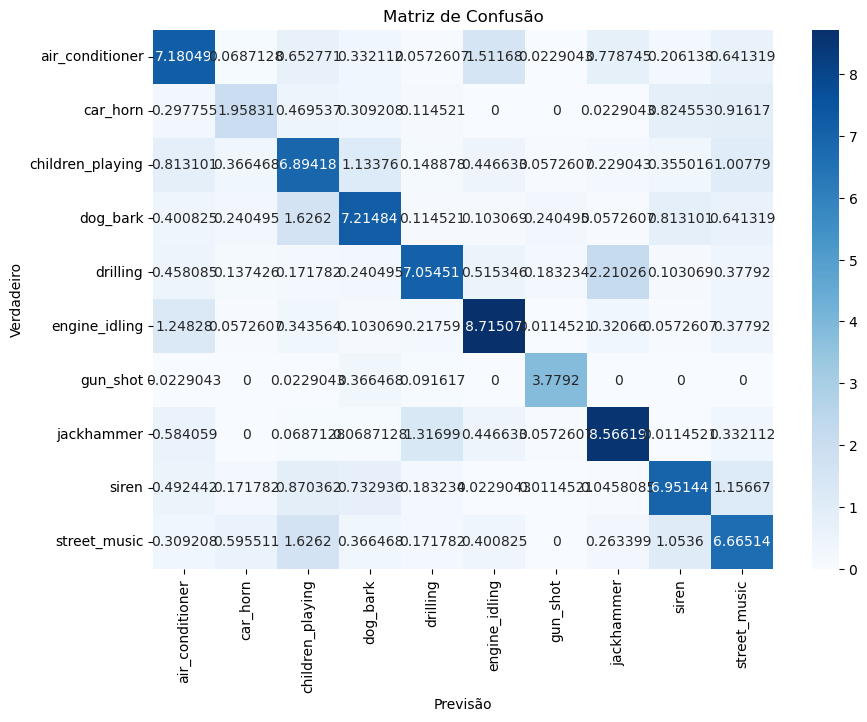

In [36]:
print(best_model.summary())
print("Learning rate: ", best_model_lr)
print("Number of epochs: ", best_model_epochs)
print("Batch Size: ", best_model_batch_size)
print("Accuracy: ", best_model_accuracy)
print("Loss: ", best_model_loss)
print("Standadr Deviation: ", best_model_std)

cm = pd.DataFrame(best_model_cfm, index=label_encoder.classes_, columns=label_encoder.classes_)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')

plt.title('Matriz de Confusão')
plt.xlabel('Previsão')
plt.ylabel('Verdadeiro')
plt.show()

## Referências

https://towardsdatascience.com/how-to-choose-the-right-activation-function-for-neural-networks-3941ff0e6f9c  
https://medium.com/thedeephub/learning-rate-and-its-strategies-in-neural-network-training-270a91ea0e5c  
https://www.kaggle.com/code/androbomb/simple-nn-with-python-multi-layer-perceptron  
https://medium.com/ensina-ai/rede-neural-perceptron-multicamadas-f9de8471f1a9  
https://iaexpert.academy/2020/05/04/quantas-camadas-escondidas-e-quantos-neuronios-incluir-numa-rede-neural-artificial/
https://towardsdatascience.com/how-to-choose-the-right-activation-function-for-neural-networks-3941ff0e6f9c  
https://github.com/enochkan/building-from-scratch/blob/main/optimizers/adam-optimizer-from-scratch.ipynb  
https://www.geeksforgeeks.org/ml-mini-batch-gradient-descent-with-python/